In [1]:
%matplotlib inline
from fastai import *
from fastai.text import *
from fastai.callbacks import *

In [2]:
import numpy as np
from pathlib import Path
import os
import torch.optim as optim
import random

# transformers
from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig

# our models of choice
from transformers import BertForSequenceClassification, BertTokenizer, BertConfig
from transformers import RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig
from transformers import XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig
from transformers import XLMForSequenceClassification, XLMTokenizer, XLMConfig
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig
from transformers import AlbertForSequenceClassification, AlbertTokenizer, AlbertConfig

try:
    from torch.utils.tensorboard import SummaryWriter
except ImportError:
    from tensorboardX import SummaryWriter

In [3]:
import fastai
import transformers
print('fastai version :', fastai.__version__)
print('transformers version :', transformers.__version__)
print(f'GPU is available: {torch.cuda.is_available()}')
device = torch.device("cuda" if torch.cuda.is_available()  else "cpu")

fastai version : 1.0.59
transformers version : 2.3.0
GPU is available: True


In [4]:
import argparse
import glob
import json
import logging
import os
import random

import numpy as np
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from torch.utils.data.distributed import DistributedSampler
from tqdm import tqdm, trange

from transformers import (
    WEIGHTS_NAME,
    AdamW,
    AlbertConfig,
    AlbertForSequenceClassification,
    AlbertTokenizer,
    BertConfig,
    BertForSequenceClassification,
    BertTokenizer,
    DistilBertConfig,
    DistilBertForSequenceClassification,
    DistilBertTokenizer,
    RobertaConfig,
    RobertaForSequenceClassification,
    RobertaTokenizer,
    XLMConfig,
    XLMForSequenceClassification,
    XLMRobertaConfig,
    XLMRobertaForSequenceClassification,
    XLMRobertaTokenizer,
    XLMTokenizer,
    XLNetConfig,
    XLNetForSequenceClassification,
    XLNetTokenizer,
    get_linear_schedule_with_warmup,
    get_cosine_schedule_with_warmup
)
from transformers import glue_compute_metrics as compute_metrics
from transformers import glue_convert_examples_to_features as convert_examples_to_features
from transformers import glue_output_modes as output_modes
from transformers import glue_processors as processors

In [5]:
seed = 42
def seed_all(seed_value):
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False
        
seed_all(seed)

## Prepare the full IMDB dataset and inspect the files under that path

In [6]:
path = untar_data(URLs.IMDB)
path

PosixPath('/home/projectx/.fastai/data/imdb')

In [7]:
path.ls()

[PosixPath('/home/projectx/.fastai/data/imdb/imdb.vocab'),
 PosixPath('/home/projectx/.fastai/data/imdb/models'),
 PosixPath('/home/projectx/.fastai/data/imdb/lm_databunch_RoBERTa'),
 PosixPath('/home/projectx/.fastai/data/imdb/test'),
 PosixPath('/home/projectx/.fastai/data/imdb/data_bunch_classification'),
 PosixPath('/home/projectx/.fastai/data/imdb/imdb_textlist_classifier'),
 PosixPath('/home/projectx/.fastai/data/imdb/fine_tuning_LM'),
 PosixPath('/home/projectx/.fastai/data/imdb/tmp_lm'),
 PosixPath('/home/projectx/.fastai/data/imdb/train'),
 PosixPath('/home/projectx/.fastai/data/imdb/lm_databunch'),
 PosixPath('/home/projectx/.fastai/data/imdb/tmp_clas'),
 PosixPath('/home/projectx/.fastai/data/imdb/README'),
 PosixPath('/home/projectx/.fastai/data/imdb/unsup')]

In [8]:
(path/'train').ls()

[PosixPath('/home/projectx/.fastai/data/imdb/train/unsupBow.feat'),
 PosixPath('/home/projectx/.fastai/data/imdb/train/pos'),
 PosixPath('/home/projectx/.fastai/data/imdb/train/labeledBow.feat'),
 PosixPath('/home/projectx/.fastai/data/imdb/train/neg')]

In [9]:
(path/'test').ls()

[PosixPath('/home/projectx/.fastai/data/imdb/test/pos'),
 PosixPath('/home/projectx/.fastai/data/imdb/test/labeledBow.feat'),
 PosixPath('/home/projectx/.fastai/data/imdb/test/neg')]

In [10]:
import glob

def text_label_pairs_from_folder(path, folders):
    text_label_pairs = [['sentence', 'label']]
    
    for idx, label in enumerate(folders):
        for fname in glob.glob(os.path.join(path, label, '*.*')):
            text_label_pairs.append(list([open(fname,'r').read(), str(idx)]))
    return text_label_pairs

In [11]:
trainpath = Path(path/'train')
testpath  = Path(path/'test')
train_IMDb = text_label_pairs_from_folder(trainpath, ['pos','neg'])
test_IMDb  = text_label_pairs_from_folder(testpath, ['pos','neg'])

In [12]:
len(train_IMDb), len(test_IMDb)

(25001, 25001)

In [13]:
class InputExample(object):
    """
    A single training/test example for simple sequence classification.

    Args:
        guid: Unique id for the example.
        text_a: string. The untokenized text of the first sequence. For single
        sequence tasks, only this sequence must be specified.
        text_b: (Optional) string. The untokenized text of the second sequence.
        Only must be specified for sequence pair tasks.
        label: (Optional) string. The label of the example. This should be
        specified for train and dev examples, but not for test examples.
    """

    def __init__(self, guid, text_a, text_b=None, label=None):
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label

    def __repr__(self):
        return str(self.to_json_string())

    def to_dict(self):
        """Serializes this instance to a Python dictionary."""
        output = copy.deepcopy(self.__dict__)
        return output

    def to_json_string(self):
        """Serializes this instance to a JSON string."""
        return json.dumps(self.to_dict(), indent=2, sort_keys=True) + "\n"

In [14]:
def _create_examples(lines, set_type):
        """Creates examples for the training and dev sets."""
        examples = []
        for (i, line) in enumerate(lines):
            if i == 0:
                continue
            guid = "%s-%s" % (set_type, i)
            text_a = line[0]
            label = line[1]
            examples.append(InputExample(guid=guid, text_a=text_a, text_b=None, label=label))
        return examples

In [15]:
example_IMDb_train = _create_examples(train_IMDb, 'train')
example_IMDb_test  = _create_examples(test_IMDb, 'test')

In [16]:
AlbertForSequenceClassification.pretrained_model_archive_map.keys()

dict_keys(['albert-base-v1', 'albert-large-v1', 'albert-xlarge-v1', 'albert-xxlarge-v1', 'albert-base-v2', 'albert-large-v2', 'albert-xlarge-v2', 'albert-xxlarge-v2'])

In [17]:
pretrained_model_name = 'albert-base-v2'
tokenizer = AlbertTokenizer.from_pretrained(pretrained_model_name)

In [18]:
features_IMDb_train = convert_examples_to_features(
                        example_IMDb_train,
                        tokenizer,
                        label_list=['0','1'],
                        max_length= 512,    # the maximum total input sequence length after tokenization.
                                            # Sequences longer than this will be truncated, shorter will be padded
                        output_mode="classification",
                        pad_on_left=bool('ALBERT' in ["xlnet"]),  # pad on the left for xlnet
                        pad_token=tokenizer.convert_tokens_to_ids([tokenizer.pad_token])[0],
                        pad_token_segment_id=4 if 'ALBERT' in ["xlnet"] else 0,
                        )

In [19]:
features_IMDb_test = convert_examples_to_features(
                        example_IMDb_test,
                        tokenizer,
                        label_list=['0','1'],
                        max_length= 512,    # the maximum total input sequence length after tokenization.
                                            # Sequences longer than this will be truncated, shorter will be padded
                        output_mode="classification",
                        pad_on_left=bool('ALBERT' in ["xlnet"]),  # pad on the left for xlnet
                        pad_token=tokenizer.convert_tokens_to_ids([tokenizer.pad_token])[0],
                        pad_token_segment_id=4 if 'ALBERT' in ["xlnet"] else 0,
                        )

In [20]:
# Convert to Tensors and build dataset

# for train
features = features_IMDb_train

all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
all_attention_mask = torch.tensor([f.attention_mask for f in features], dtype=torch.long)
all_token_type_ids = torch.tensor([f.token_type_ids for f in features], dtype=torch.long)
all_labels = torch.tensor([f.label for f in features], dtype=torch.long)

# create train_dataset
dataset_IMDb_train = TensorDataset(all_input_ids, all_attention_mask, all_token_type_ids, all_labels)

In [21]:
# Convert to Tensors and build dataset

# for test
features = features_IMDb_test

all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
all_attention_mask = torch.tensor([f.attention_mask for f in features], dtype=torch.long)
all_token_type_ids = torch.tensor([f.token_type_ids for f in features], dtype=torch.long)
all_labels = torch.tensor([f.label for f in features], dtype=torch.long)

# create train_dataset
dataset_IMDb_test = TensorDataset(all_input_ids, all_attention_mask, all_token_type_ids, all_labels)

In [22]:
len(dataset_IMDb_train), len(dataset_IMDb_test)

(25000, 25000)

### Transformers model Zoo
Create a dictionary of parameters required for creating different model classes

In [49]:
MODEL_CLASSES = {
    'bert': (BertForSequenceClassification, BertTokenizer, BertConfig),
    'xlnet': (XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig),
    'xlm': (XLMForSequenceClassification, XLMTokenizer, XLMConfig),
    'roberta': (RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig),
    'distilbert': (DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig),
    'albert': (AlbertForSequenceClassification, AlbertTokenizer, AlbertConfig)
}

In [50]:
model_class, tokenizer_class, config_class = MODEL_CLASSES['albert']

In [51]:
pretrained_model_name

'albert-base-v2'

In [52]:
# Create pretrained model 
config = config_class.from_pretrained(pretrained_model_name, num_labels = 2)
config.hidden_dropout_prob = 0.25
config.attention_probs_dropout_prob = 0.2

print(config)

{
  "architectures": [
    "AlbertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.2,
  "bos_token_id": 0,
  "do_sample": false,
  "down_scale_factor": 1,
  "embedding_size": 128,
  "eos_token_ids": 0,
  "finetuning_task": null,
  "gap_size": 0,
  "hidden_act": "gelu_new",
  "hidden_dropout_prob": 0.25,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "inner_group_num": 1,
  "intermediate_size": 3072,
  "is_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1
  },
  "layer_norm_eps": 1e-12,
  "length_penalty": 1.0,
  "max_length": 20,
  "max_position_embeddings": 512,
  "net_structure_type": 0,
  "num_attention_heads": 12,
  "num_beams": 1,
  "num_hidden_groups": 1,
  "num_hidden_layers": 12,
  "num_labels": 2,
  "num_memory_blocks": 0,
  "num_return_sequences": 1,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pad_token_id": 0,
  "pruned_heads": {},
  "repetiti

In [53]:
model = model_class.from_pretrained(pretrained_model_name, config = config)

In [54]:
model.to(device);

## Train loop

In [55]:
class args_for_training():
    def __init__(self):
        
        # general parameters
        self.train_batch_size   = 8
        self.eval_batch_size    = 8
        self.max_steps          = -1  # set to -1 if we define the training duration by num_epochs
        self.gradient_accumulation_steps = 1  # update for each batch we take in
        self.num_train_epochs   = 8
        self.device = device
        self.model_type         = 'albert'
        self.logging_steps      = 4000
        self.save_steps         = 4000
        self.local_rank         = -1
        self.output_dir = os.path.join(os.getcwd(),'ALBERT')
        self.evaluate_during_training = True
        self.task_name          = "sst-2"  # this is used to determine evaluation metric (we use simple accuracy)
        self.output_mode        = "classification"
        
        
        # optimizer parameters
        self.weight_decay  = 2.0
        self.learning_rate = 2e-5
        self.adam_epsilon  = 1e-8
        self.warmup_steps  = 4000
        self.model_name_or_path = pretrained_model_name
        self.max_grad_norm = 1.0
        
args = args_for_training()

In [56]:
def train(args, train_dataset, model, tokenizer):
    """ Train the model """
    if args.local_rank in [-1, 0]:
        tb_writer = SummaryWriter()
   
    train_sampler = RandomSampler(train_dataset)
    train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=args.train_batch_size)

    t_total = len(train_dataloader) // args.gradient_accumulation_steps * args.num_train_epochs

    # Prepare optimizer and schedule (linear warmup and decay)
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay": args.weight_decay,
        },
        {"params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], "weight_decay": 0.0},
    ]

    optimizer = AdamW(optimizer_grouped_parameters, lr=args.learning_rate, eps=args.adam_epsilon)
    scheduler = get_cosine_schedule_with_warmup(
        optimizer, num_warmup_steps=int(t_total*0.3), num_training_steps=t_total
    )
#     scheduler =  get get_linear_schedule_with_warmup(
#         optimizer, num_warmup_steps=args.warmup_steps, num_training_steps=t_total
#     )

    # Check if saved optimizer or scheduler states exist
    if os.path.isfile(os.path.join(args.model_name_or_path, "optimizer.pt")) and os.path.isfile(
        os.path.join(args.model_name_or_path, "scheduler.pt")
    ):
        # Load in optimizer and scheduler states
        optimizer.load_state_dict(torch.load(os.path.join(args.model_name_or_path, "optimizer.pt")))
        scheduler.load_state_dict(torch.load(os.path.join(args.model_name_or_path, "scheduler.pt")))


    global_step = 0
    epochs_trained = 0
    steps_trained_in_current_epoch = 0
    # Check if continuing training from a checkpoint
    if os.path.exists(args.model_name_or_path):
        # set global_step to gobal_step of last saved checkpoint from model path
        global_step = int(args.model_name_or_path.split("-")[-1].split("/")[0])
        epochs_trained = global_step // (len(train_dataloader) // args.gradient_accumulation_steps)
        steps_trained_in_current_epoch = global_step % (len(train_dataloader) // args.gradient_accumulation_steps)


    tr_loss, logging_loss = 0.0, 0.0
    accuracies = list()
    model.zero_grad()
    train_iterator = trange(
        epochs_trained, int(args.num_train_epochs), desc="Epoch", disable=False,
    )

    for _ in train_iterator:
        epoch_iterator = tqdm(train_dataloader, desc="Iteration", disable=False)
        for step, batch in enumerate(epoch_iterator):

            # Skip past any already trained steps if resuming training
            if steps_trained_in_current_epoch > 0:
                steps_trained_in_current_epoch -= 1
                continue

            model.train()
            batch = tuple(t.to(args.device) for t in batch)
            inputs = {"input_ids": batch[0], "attention_mask": batch[1], "labels": batch[3]}
            if args.model_type != "distilbert":
                inputs["token_type_ids"] = (
                    batch[2] if args.model_type in ["bert", "xlnet", "albert"] else None
                )  # XLM, DistilBERT, RoBERTa, and XLM-RoBERTa don't use segment_ids
            outputs = model(**inputs)
            loss = outputs[0]  # model outputs are always tuple in transformers (see doc)

            if args.gradient_accumulation_steps > 1:
                loss = loss / args.gradient_accumulation_steps
            
            loss.backward()

            tr_loss += loss.item()
            if (step + 1) % args.gradient_accumulation_steps == 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), args.max_grad_norm)

                optimizer.step() 
                scheduler.step()  # Update learning rate schedule
                model.zero_grad()
                global_step += 1

                if args.local_rank in [-1, 0] and args.logging_steps > 0 and global_step % args.logging_steps == 0:
                    logs = {}
                    if (
                        args.local_rank == -1 and args.evaluate_during_training
                    ):  # Only evaluate when single GPU otherwise metrics may not average well
                        results, accuracy = evaluate(args,train_dataset, model, tokenizer)
                        accuracies.append(accuracy)
                        for key, value in results.items():
                            eval_key = "eval_{}".format(key)
                            logs[eval_key] = value

                    loss_scalar = (tr_loss - logging_loss) / args.logging_steps
                    learning_rate_scalar = scheduler.get_lr()[0]
                    logs["learning_rate"] = learning_rate_scalar
                    logs["loss"] = loss_scalar
                    logging_loss = tr_loss

                    for key, value in logs.items():
                        tb_writer.add_scalar(key, value, global_step)
                    print(json.dumps({**logs, **{"step": global_step}}))

                if args.local_rank in [-1, 0] and args.save_steps > 0 and global_step % args.save_steps == 0:
                    # Save model checkpoint
                    output_dir = os.path.join(args.output_dir, "checkpoint-{}".format(global_step))
                    if not os.path.exists(output_dir):
                        os.makedirs(output_dir)
                    model_to_save = (
                        model.module if hasattr(model, "module") else model
                    )  # Take care of distributed/parallel training
                    model_to_save.save_pretrained(output_dir)
                    tokenizer.save_pretrained(output_dir)

                    torch.save(args, os.path.join(output_dir, "training_args.bin"))
                    logger.info("Saving model checkpoint to %s", output_dir)

                    torch.save(optimizer.state_dict(), os.path.join(output_dir, "optimizer.pt"))
                    torch.save(scheduler.state_dict(), os.path.join(output_dir, "scheduler.pt"))
                    logger.info("Saving optimizer and scheduler states to %s", output_dir)

            if args.max_steps > 0 and global_step > args.max_steps:
                epoch_iterator.close()
                break
        if args.max_steps > 0 and global_step > args.max_steps:
            train_iterator.close()
            break

    if args.local_rank in [-1, 0]:
        tb_writer.close()

    return global_step, tr_loss / global_step, accuracies

In [57]:
def simple_accuracy(preds, labels):
    
    return {"acc": (preds == labels).mean()}

In [58]:
def evaluate(args,dataset, model, tokenizer, prefix=""):
    # Loop to handle MNLI double evaluation (matched, mis-matched)
    eval_task_names = "sst-2"
    eval_outputs_dirs = (args.output_dir, args.output_dir + "-MM") if args.task_name == "mnli" else (args.output_dir,)

    results = {}
    accuracies = []
    for eval_task, eval_output_dir in zip(eval_task_names, eval_outputs_dirs):
        eval_dataset = dataset_IMDb_test

        if not os.path.exists(eval_output_dir) and args.local_rank in [-1, 0]:
            os.makedirs(eval_output_dir)

        
        # Note that DistributedSampler samples randomly
        eval_sampler = SequentialSampler(dataset)
        eval_dataloader = DataLoader(dataset, sampler=eval_sampler, batch_size=args.train_batch_size)

        
        # Eval!
        
        eval_loss = 0.0
        nb_eval_steps = 0
        preds = None
        out_label_ids = None
        for batch in tqdm(eval_dataloader, desc="Evaluating"):
            model.eval()
            batch = tuple(t.to(args.device) for t in batch)

            with torch.no_grad():
                inputs = {"input_ids": batch[0], "attention_mask": batch[1], "labels": batch[3]}
                if args.model_type != "distilbert":
                    inputs["token_type_ids"] = (
                        batch[2] if args.model_type in ["bert", "xlnet", "albert"] else None
                    )  # XLM, DistilBERT, RoBERTa, and XLM-RoBERTa don't use segment_ids
                outputs = model(**inputs)
                tmp_eval_loss, logits = outputs[:2]

                eval_loss += tmp_eval_loss.mean().item()
            nb_eval_steps += 1
            if preds is None:
                preds = logits.detach().cpu().numpy()
                out_label_ids = inputs["labels"].detach().cpu().numpy()
            else:
                preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
                out_label_ids = np.append(out_label_ids, inputs["labels"].detach().cpu().numpy(), axis=0)

        eval_loss = eval_loss / nb_eval_steps
        if args.output_mode == "classification":
            preds = np.argmax(preds, axis=1)
        elif args.output_mode == "regression":
            preds = np.squeeze(preds)
        result = simple_accuracy(preds, out_label_ids)
        results.update(result)
        accuracies.append(result['acc'])

        output_eval_file = os.path.join(eval_output_dir, prefix, "eval_results.txt")
        with open(output_eval_file, "w") as writer:
            logger.info("***** Eval results {} *****".format(prefix))
            for key in sorted(result.keys()):
                logger.info("  %s = %s", key, str(result[key]))
                writer.write("%s = %s\n" % (key, str(result[key])))

    return results, accuracies

In [59]:
logger = logging.getLogger(__name__)

In [60]:
global_step, tr_loss, accuracies = train(args, dataset_IMDb_train, model, tokenizer)
logger.info(" global_step = %s, average loss = %s", global_step, tr_loss)

Iteration:   4%|▍         | 126/3125 [01:01<23:53,  2.09it/s]


Iteration:   8%|▊         | 252/3125 [02:02<23:15,  2.06it/s]


Iteration:  12%|█▏        | 378/3125 [03:04<22:37,  2.02it/s]


Iteration:  16%|█▌        | 504/3125 [04:07<21:45,  2.01it/s]


Iteration:  20%|██        | 630/3125 [05:10<20:53,  1.99it/s]


Iteration:  24%|██▍       | 756/3125 [06:13<19:31,  2.02it/s]


Iteration:  28%|██▊       | 882/3125 [07:17<18:55,  1.98it/s]


Iteration:  32%|███▏      | 1007/3125 [08:20<19:00,  1.86it/s]


Iteration:  36%|███▌      | 1131/3125 [09:23<16:25,  2.02it/s]


Iteration:  40%|████      | 1255/3125 [10:25<15:29,  2.01it/s]


Iteration:  44%|████▍     | 1379/3125 [11:27<15:09,  1.92it/s]


Iteration:  48%|████▊     | 1503/3125 [12:29<13:34,  1.99it/s]


Iteration:  52%|█████▏    | 1627/3125 [13:32<12:30,  2.00it/s]


Iteration:  56%|█████▌    | 1751/3125 [14:34<11:13,  2.04it/s]


Iteration:  60%|██████    | 1875/3125 [15:37<10:43,  1.94it/s]


Iteration:  64%|██████▍   | 1999/3125 [16:39<09:53,  1.90it/s]


Iteration:  68%|██████▊   | 2123/3125 [17:42<08:16,  2.02it/s]


Iteration:  72%|███████▏  | 2247/3125 [18:45<07:30,  1.95it/s]


Iteration:  76%|███████▌  | 2371/3125 [19:48<06:27,  1.94it/s]


Iteration:  80%|███████▉  | 2495/3125 [20:51<05:08,  2.04it/s]


Iteration:  84%|████████▍ | 2619/3125 [21:53<04:26,  1.90it/s]


Iteration:  88%|████████▊ | 2743/3125 [22:56<03:09,  2.01it/s]


Iteration:  92%|█████████▏| 2867/3125 [23:59<02:15,  1.90it/s]


Iteration:  96%|█████████▌| 2991/3125 [25:01<01:09,  1.92it/s]


Iteration: 100%|█████████▉| 3115/3125 [26:04<00:05,  1.96it/s]


Iteration:   4%|▎         | 116/3125 [00:58<25:42,  1.95it/s]


Iteration:   8%|▊         | 242/3125 [02:01<24:03,  2.00it/s]


Iteration:  12%|█▏        | 368/3125 [03:05<23:42,  1.94it/s]


Iteration:  16%|█▌        | 494/3125 [04:09<22:07,  1.98it/s]


Iteration:  20%|█▉        | 620/3125 [05:13<21:45,  1.92it/s]


Iteration:  24%|██▍       | 746/3125 [06:16<19:57,  1.99it/s]


Iteration:  28%|██▊       | 872/3125 [07:20<19:35,  1.92it/s]


Iteration:  28%|██▊       | 874/3125 [07:21<18:54,  1.98it/s]

Evaluating:   0%|          | 0/3125 [00:00<?, ?it/s]

Evaluating:   0%|          | 1/3125 [00:00<09:10,  5.68it/s]

Evaluating:   0%|          | 2/3125 [00:00<09:08,  5.69it/s]

Evaluating:   0%|          | 3/3125 [00:00<09:12,  5.65it/s]

Evaluating:   0%|          | 4/3125 [00:00<09:12,  5.64it/s]

Evaluating:   0%|          | 5/3125 [00:00<09:14,  5.62it/s]

Evaluating:   0%|          | 6/3125 [00:01<09:15,  5.61it/s]

Evaluating:   0%|          | 7/3125 [00:01<09:17,  5.59it/s]

Evaluating:   0%|          | 8/3125 [00:01<09:21,  5.55it/s]

Evaluating:   0%|          | 9/3125 [00:01<09:25,  5.51it/s]

Evaluating:   0%|          | 10/3125 [00:01<09:26,  5.50it/s]

Evaluating:   0%|          | 11/3125 [00:01<09:35,  5.41it/s]

Evaluating:   0%|          | 12/3125 [00:02<09:35,  5.41it/s]

Evaluating:   0%|          | 13/3125 [00:02<09:35,  5.40it/s]

Evaluating:   0%|          | 14/3125 [00:02<09:36,  5.40it/s]

Evaluating

Evaluating:   4%|▎         | 116/3125 [00:21<09:22,  5.35it/s]

Evaluating:   4%|▎         | 117/3125 [00:21<09:21,  5.36it/s]

Evaluating:   4%|▍         | 118/3125 [00:22<09:18,  5.38it/s]

Evaluating:   4%|▍         | 119/3125 [00:22<09:17,  5.40it/s]

Evaluating:   4%|▍         | 120/3125 [00:22<09:15,  5.41it/s]

Evaluating:   4%|▍         | 121/3125 [00:22<09:15,  5.41it/s]

Evaluating:   4%|▍         | 122/3125 [00:22<09:14,  5.42it/s]

Evaluating:   4%|▍         | 123/3125 [00:23<09:13,  5.42it/s]

Evaluating:   4%|▍         | 124/3125 [00:23<09:12,  5.43it/s]

Evaluating:   4%|▍         | 125/3125 [00:23<09:11,  5.44it/s]

Evaluating:   4%|▍         | 126/3125 [00:23<09:11,  5.44it/s]

Evaluating:   4%|▍         | 127/3125 [00:23<09:10,  5.44it/s]

Evaluating:   4%|▍         | 128/3125 [00:23<09:09,  5.45it/s]

Evaluating:   4%|▍         | 129/3125 [00:24<09:10,  5.45it/s]

Evaluating:   4%|▍         | 130/3125 [00:24<09:10,  5.44it/s]

Evaluating:   4%|▍         | 131/3125 [0

Evaluating:   7%|▋         | 233/3125 [00:43<08:59,  5.36it/s]

Evaluating:   7%|▋         | 234/3125 [00:43<08:57,  5.38it/s]

Evaluating:   8%|▊         | 235/3125 [00:44<08:55,  5.39it/s]

Evaluating:   8%|▊         | 236/3125 [00:44<08:54,  5.41it/s]

Evaluating:   8%|▊         | 237/3125 [00:44<08:53,  5.42it/s]

Evaluating:   8%|▊         | 238/3125 [00:44<08:52,  5.42it/s]

Evaluating:   8%|▊         | 239/3125 [00:44<08:51,  5.43it/s]

Evaluating:   8%|▊         | 240/3125 [00:44<08:52,  5.41it/s]

Evaluating:   8%|▊         | 241/3125 [00:45<08:51,  5.42it/s]

Evaluating:   8%|▊         | 242/3125 [00:45<08:51,  5.43it/s]

Evaluating:   8%|▊         | 243/3125 [00:45<08:50,  5.44it/s]

Evaluating:   8%|▊         | 244/3125 [00:45<08:48,  5.45it/s]

Evaluating:   8%|▊         | 245/3125 [00:45<08:49,  5.44it/s]

Evaluating:   8%|▊         | 246/3125 [00:46<08:49,  5.43it/s]

Evaluating:   8%|▊         | 247/3125 [00:46<08:46,  5.46it/s]

Evaluating:   8%|▊         | 248/3125 [0

Evaluating:  11%|█         | 350/3125 [01:05<08:31,  5.43it/s]

Evaluating:  11%|█         | 351/3125 [01:05<08:30,  5.44it/s]

Evaluating:  11%|█▏        | 352/3125 [01:05<08:31,  5.42it/s]

Evaluating:  11%|█▏        | 353/3125 [01:05<08:30,  5.43it/s]

Evaluating:  11%|█▏        | 354/3125 [01:06<08:29,  5.43it/s]

Evaluating:  11%|█▏        | 355/3125 [01:06<08:30,  5.42it/s]

Evaluating:  11%|█▏        | 356/3125 [01:06<08:31,  5.41it/s]

Evaluating:  11%|█▏        | 357/3125 [01:06<08:33,  5.40it/s]

Evaluating:  11%|█▏        | 358/3125 [01:06<08:33,  5.39it/s]

Evaluating:  11%|█▏        | 359/3125 [01:07<08:33,  5.39it/s]

Evaluating:  12%|█▏        | 360/3125 [01:07<08:33,  5.38it/s]

Evaluating:  12%|█▏        | 361/3125 [01:07<08:33,  5.39it/s]

Evaluating:  12%|█▏        | 362/3125 [01:07<08:31,  5.40it/s]

Evaluating:  12%|█▏        | 363/3125 [01:07<08:38,  5.32it/s]

Evaluating:  12%|█▏        | 364/3125 [01:07<08:34,  5.37it/s]

Evaluating:  12%|█▏        | 365/3125 [0

Evaluating:  15%|█▍        | 467/3125 [01:27<08:15,  5.37it/s]

Evaluating:  15%|█▍        | 468/3125 [01:27<08:13,  5.39it/s]

Evaluating:  15%|█▌        | 469/3125 [01:27<08:12,  5.40it/s]

Evaluating:  15%|█▌        | 470/3125 [01:27<08:13,  5.38it/s]

Evaluating:  15%|█▌        | 471/3125 [01:27<08:13,  5.38it/s]

Evaluating:  15%|█▌        | 472/3125 [01:28<08:13,  5.37it/s]

Evaluating:  15%|█▌        | 473/3125 [01:28<08:11,  5.39it/s]

Evaluating:  15%|█▌        | 474/3125 [01:28<08:12,  5.39it/s]

Evaluating:  15%|█▌        | 475/3125 [01:28<08:12,  5.38it/s]

Evaluating:  15%|█▌        | 476/3125 [01:28<08:11,  5.39it/s]

Evaluating:  15%|█▌        | 477/3125 [01:29<08:11,  5.39it/s]

Evaluating:  15%|█▌        | 478/3125 [01:29<08:09,  5.41it/s]

Evaluating:  15%|█▌        | 479/3125 [01:29<08:06,  5.44it/s]

Evaluating:  15%|█▌        | 480/3125 [01:29<08:05,  5.45it/s]

Evaluating:  15%|█▌        | 481/3125 [01:29<08:03,  5.46it/s]

Evaluating:  15%|█▌        | 482/3125 [0

Evaluating:  19%|█▊        | 584/3125 [01:48<07:50,  5.40it/s]

Evaluating:  19%|█▊        | 585/3125 [01:49<07:51,  5.38it/s]

Evaluating:  19%|█▉        | 586/3125 [01:49<07:52,  5.37it/s]

Evaluating:  19%|█▉        | 587/3125 [01:49<07:54,  5.35it/s]

Evaluating:  19%|█▉        | 588/3125 [01:49<07:57,  5.32it/s]

Evaluating:  19%|█▉        | 589/3125 [01:49<07:53,  5.36it/s]

Evaluating:  19%|█▉        | 590/3125 [01:49<07:53,  5.35it/s]

Evaluating:  19%|█▉        | 591/3125 [01:50<07:53,  5.36it/s]

Evaluating:  19%|█▉        | 592/3125 [01:50<07:51,  5.37it/s]

Evaluating:  19%|█▉        | 593/3125 [01:50<07:49,  5.39it/s]

Evaluating:  19%|█▉        | 594/3125 [01:50<07:50,  5.38it/s]

Evaluating:  19%|█▉        | 595/3125 [01:50<07:49,  5.39it/s]

Evaluating:  19%|█▉        | 596/3125 [01:51<07:48,  5.40it/s]

Evaluating:  19%|█▉        | 597/3125 [01:51<07:54,  5.32it/s]

Evaluating:  19%|█▉        | 598/3125 [01:51<08:06,  5.19it/s]

Evaluating:  19%|█▉        | 599/3125 [0

Evaluating:  22%|██▏       | 701/3125 [02:10<07:30,  5.38it/s]

Evaluating:  22%|██▏       | 702/3125 [02:10<07:31,  5.37it/s]

Evaluating:  22%|██▏       | 703/3125 [02:10<07:29,  5.38it/s]

Evaluating:  23%|██▎       | 704/3125 [02:11<07:28,  5.40it/s]

Evaluating:  23%|██▎       | 705/3125 [02:11<07:27,  5.40it/s]

Evaluating:  23%|██▎       | 706/3125 [02:11<07:28,  5.39it/s]

Evaluating:  23%|██▎       | 707/3125 [02:11<07:26,  5.41it/s]

Evaluating:  23%|██▎       | 708/3125 [02:11<07:26,  5.41it/s]

Evaluating:  23%|██▎       | 709/3125 [02:12<07:27,  5.40it/s]

Evaluating:  23%|██▎       | 710/3125 [02:12<07:26,  5.41it/s]

Evaluating:  23%|██▎       | 711/3125 [02:12<07:25,  5.42it/s]

Evaluating:  23%|██▎       | 712/3125 [02:12<07:25,  5.41it/s]

Evaluating:  23%|██▎       | 713/3125 [02:12<07:25,  5.42it/s]

Evaluating:  23%|██▎       | 714/3125 [02:12<07:24,  5.42it/s]

Evaluating:  23%|██▎       | 715/3125 [02:13<07:26,  5.40it/s]

Evaluating:  23%|██▎       | 716/3125 [0

Evaluating:  26%|██▌       | 818/3125 [02:32<07:06,  5.41it/s]

Evaluating:  26%|██▌       | 819/3125 [02:32<07:07,  5.40it/s]

Evaluating:  26%|██▌       | 820/3125 [02:32<07:07,  5.39it/s]

Evaluating:  26%|██▋       | 821/3125 [02:32<07:06,  5.40it/s]

Evaluating:  26%|██▋       | 822/3125 [02:32<07:06,  5.40it/s]

Evaluating:  26%|██▋       | 823/3125 [02:33<07:05,  5.40it/s]

Evaluating:  26%|██▋       | 824/3125 [02:33<07:06,  5.39it/s]

Evaluating:  26%|██▋       | 825/3125 [02:33<07:06,  5.39it/s]

Evaluating:  26%|██▋       | 826/3125 [02:33<07:07,  5.38it/s]

Evaluating:  26%|██▋       | 827/3125 [02:33<07:07,  5.38it/s]

Evaluating:  26%|██▋       | 828/3125 [02:34<07:06,  5.38it/s]

Evaluating:  27%|██▋       | 829/3125 [02:34<07:06,  5.38it/s]

Evaluating:  27%|██▋       | 830/3125 [02:34<07:07,  5.37it/s]

Evaluating:  27%|██▋       | 831/3125 [02:34<07:06,  5.38it/s]

Evaluating:  27%|██▋       | 832/3125 [02:34<07:05,  5.39it/s]

Evaluating:  27%|██▋       | 833/3125 [0

Evaluating:  30%|██▉       | 935/3125 [02:53<06:49,  5.35it/s]

Evaluating:  30%|██▉       | 936/3125 [02:54<06:47,  5.37it/s]

Evaluating:  30%|██▉       | 937/3125 [02:54<06:45,  5.40it/s]

Evaluating:  30%|███       | 938/3125 [02:54<06:44,  5.41it/s]

Evaluating:  30%|███       | 939/3125 [02:54<06:44,  5.41it/s]

Evaluating:  30%|███       | 940/3125 [02:54<06:41,  5.45it/s]

Evaluating:  30%|███       | 941/3125 [02:55<06:40,  5.46it/s]

Evaluating:  30%|███       | 942/3125 [02:55<06:39,  5.47it/s]

Evaluating:  30%|███       | 943/3125 [02:55<06:38,  5.48it/s]

Evaluating:  30%|███       | 944/3125 [02:55<06:39,  5.46it/s]

Evaluating:  30%|███       | 945/3125 [02:55<06:39,  5.46it/s]

Evaluating:  30%|███       | 946/3125 [02:55<06:39,  5.45it/s]

Evaluating:  30%|███       | 947/3125 [02:56<06:40,  5.44it/s]

Evaluating:  30%|███       | 948/3125 [02:56<06:39,  5.45it/s]

Evaluating:  30%|███       | 949/3125 [02:56<06:40,  5.43it/s]

Evaluating:  30%|███       | 950/3125 [0

Evaluating:  34%|███▎      | 1051/3125 [03:15<06:24,  5.40it/s]

Evaluating:  34%|███▎      | 1052/3125 [03:15<06:24,  5.40it/s]

Evaluating:  34%|███▎      | 1053/3125 [03:15<06:23,  5.41it/s]

Evaluating:  34%|███▎      | 1054/3125 [03:15<06:22,  5.42it/s]

Evaluating:  34%|███▍      | 1055/3125 [03:16<06:22,  5.42it/s]

Evaluating:  34%|███▍      | 1056/3125 [03:16<06:22,  5.41it/s]

Evaluating:  34%|███▍      | 1057/3125 [03:16<06:21,  5.42it/s]

Evaluating:  34%|███▍      | 1058/3125 [03:16<06:20,  5.43it/s]

Evaluating:  34%|███▍      | 1059/3125 [03:16<06:20,  5.44it/s]

Evaluating:  34%|███▍      | 1060/3125 [03:17<06:19,  5.44it/s]

Evaluating:  34%|███▍      | 1061/3125 [03:17<06:19,  5.44it/s]

Evaluating:  34%|███▍      | 1062/3125 [03:17<06:18,  5.45it/s]

Evaluating:  34%|███▍      | 1063/3125 [03:17<06:18,  5.44it/s]

Evaluating:  34%|███▍      | 1064/3125 [03:17<06:18,  5.45it/s]

Evaluating:  34%|███▍      | 1065/3125 [03:17<06:18,  5.45it/s]

Evaluating:  34%|███▍    

Evaluating:  37%|███▋      | 1166/3125 [03:36<05:59,  5.45it/s]

Evaluating:  37%|███▋      | 1167/3125 [03:36<05:59,  5.45it/s]

Evaluating:  37%|███▋      | 1168/3125 [03:36<05:58,  5.45it/s]

Evaluating:  37%|███▋      | 1169/3125 [03:37<05:59,  5.45it/s]

Evaluating:  37%|███▋      | 1170/3125 [03:37<05:59,  5.45it/s]

Evaluating:  37%|███▋      | 1171/3125 [03:37<05:58,  5.45it/s]

Evaluating:  38%|███▊      | 1172/3125 [03:37<05:58,  5.45it/s]

Evaluating:  38%|███▊      | 1173/3125 [03:37<05:58,  5.45it/s]

Evaluating:  38%|███▊      | 1174/3125 [03:38<05:57,  5.45it/s]

Evaluating:  38%|███▊      | 1175/3125 [03:38<05:57,  5.45it/s]

Evaluating:  38%|███▊      | 1176/3125 [03:38<05:57,  5.45it/s]

Evaluating:  38%|███▊      | 1177/3125 [03:38<05:57,  5.45it/s]

Evaluating:  38%|███▊      | 1178/3125 [03:38<05:57,  5.44it/s]

Evaluating:  38%|███▊      | 1179/3125 [03:38<05:56,  5.46it/s]

Evaluating:  38%|███▊      | 1180/3125 [03:39<05:56,  5.45it/s]

Evaluating:  38%|███▊    

Evaluating:  41%|████      | 1281/3125 [03:57<05:39,  5.43it/s]

Evaluating:  41%|████      | 1282/3125 [03:57<05:39,  5.43it/s]

Evaluating:  41%|████      | 1283/3125 [03:58<05:39,  5.43it/s]

Evaluating:  41%|████      | 1284/3125 [03:58<05:38,  5.44it/s]

Evaluating:  41%|████      | 1285/3125 [03:58<05:38,  5.44it/s]

Evaluating:  41%|████      | 1286/3125 [03:58<05:38,  5.43it/s]

Evaluating:  41%|████      | 1287/3125 [03:58<05:38,  5.43it/s]

Evaluating:  41%|████      | 1288/3125 [03:58<05:37,  5.44it/s]

Evaluating:  41%|████      | 1289/3125 [03:59<05:37,  5.43it/s]

Evaluating:  41%|████▏     | 1290/3125 [03:59<05:37,  5.43it/s]

Evaluating:  41%|████▏     | 1291/3125 [03:59<05:37,  5.44it/s]

Evaluating:  41%|████▏     | 1292/3125 [03:59<05:36,  5.44it/s]

Evaluating:  41%|████▏     | 1293/3125 [03:59<05:36,  5.45it/s]

Evaluating:  41%|████▏     | 1294/3125 [04:00<05:36,  5.45it/s]

Evaluating:  41%|████▏     | 1295/3125 [04:00<05:35,  5.45it/s]

Evaluating:  41%|████▏   

Evaluating:  45%|████▍     | 1396/3125 [04:18<05:21,  5.38it/s]

Evaluating:  45%|████▍     | 1397/3125 [04:19<05:31,  5.22it/s]

Evaluating:  45%|████▍     | 1398/3125 [04:19<05:36,  5.13it/s]

Evaluating:  45%|████▍     | 1399/3125 [04:19<05:33,  5.17it/s]

Evaluating:  45%|████▍     | 1400/3125 [04:19<05:45,  4.99it/s]

Evaluating:  45%|████▍     | 1401/3125 [04:19<05:39,  5.07it/s]

Evaluating:  45%|████▍     | 1402/3125 [04:19<05:32,  5.18it/s]

Evaluating:  45%|████▍     | 1403/3125 [04:20<05:30,  5.20it/s]

Evaluating:  45%|████▍     | 1404/3125 [04:20<05:41,  5.04it/s]

Evaluating:  45%|████▍     | 1405/3125 [04:20<05:32,  5.17it/s]

Evaluating:  45%|████▍     | 1406/3125 [04:20<05:26,  5.26it/s]

Evaluating:  45%|████▌     | 1407/3125 [04:20<05:22,  5.33it/s]

Evaluating:  45%|████▌     | 1408/3125 [04:21<05:27,  5.25it/s]

Evaluating:  45%|████▌     | 1409/3125 [04:21<05:31,  5.17it/s]

Evaluating:  45%|████▌     | 1410/3125 [04:21<05:27,  5.23it/s]

Evaluating:  45%|████▌   

Evaluating:  48%|████▊     | 1511/3125 [04:40<05:03,  5.32it/s]

Evaluating:  48%|████▊     | 1512/3125 [04:40<05:03,  5.32it/s]

Evaluating:  48%|████▊     | 1513/3125 [04:40<05:03,  5.31it/s]

Evaluating:  48%|████▊     | 1514/3125 [04:41<05:03,  5.31it/s]

Evaluating:  48%|████▊     | 1515/3125 [04:41<05:01,  5.35it/s]

Evaluating:  49%|████▊     | 1516/3125 [04:41<05:00,  5.36it/s]

Evaluating:  49%|████▊     | 1517/3125 [04:41<04:59,  5.36it/s]

Evaluating:  49%|████▊     | 1518/3125 [04:41<04:58,  5.39it/s]

Evaluating:  49%|████▊     | 1519/3125 [04:41<04:57,  5.40it/s]

Evaluating:  49%|████▊     | 1520/3125 [04:42<04:56,  5.41it/s]

Evaluating:  49%|████▊     | 1521/3125 [04:42<04:55,  5.42it/s]

Evaluating:  49%|████▊     | 1522/3125 [04:42<04:55,  5.43it/s]

Evaluating:  49%|████▊     | 1523/3125 [04:42<04:54,  5.43it/s]

Evaluating:  49%|████▉     | 1524/3125 [04:42<04:56,  5.40it/s]

Evaluating:  49%|████▉     | 1525/3125 [04:43<05:13,  5.10it/s]

Evaluating:  49%|████▉   

Evaluating:  52%|█████▏    | 1626/3125 [05:01<04:37,  5.40it/s]

Evaluating:  52%|█████▏    | 1627/3125 [05:02<04:36,  5.41it/s]

Evaluating:  52%|█████▏    | 1628/3125 [05:02<04:36,  5.42it/s]

Evaluating:  52%|█████▏    | 1629/3125 [05:02<04:38,  5.36it/s]

Evaluating:  52%|█████▏    | 1630/3125 [05:02<04:38,  5.37it/s]

Evaluating:  52%|█████▏    | 1631/3125 [05:02<04:38,  5.37it/s]

Evaluating:  52%|█████▏    | 1632/3125 [05:03<04:36,  5.39it/s]

Evaluating:  52%|█████▏    | 1633/3125 [05:03<04:37,  5.38it/s]

Evaluating:  52%|█████▏    | 1634/3125 [05:03<04:37,  5.38it/s]

Evaluating:  52%|█████▏    | 1635/3125 [05:03<04:36,  5.40it/s]

Evaluating:  52%|█████▏    | 1636/3125 [05:03<04:35,  5.41it/s]

Evaluating:  52%|█████▏    | 1637/3125 [05:04<04:35,  5.41it/s]

Evaluating:  52%|█████▏    | 1638/3125 [05:04<04:34,  5.41it/s]

Evaluating:  52%|█████▏    | 1639/3125 [05:04<04:33,  5.42it/s]

Evaluating:  52%|█████▏    | 1640/3125 [05:04<04:33,  5.43it/s]

Evaluating:  53%|█████▎  

Evaluating:  56%|█████▌    | 1741/3125 [05:23<04:15,  5.41it/s]

Evaluating:  56%|█████▌    | 1742/3125 [05:23<04:16,  5.39it/s]

Evaluating:  56%|█████▌    | 1743/3125 [05:24<04:14,  5.42it/s]

Evaluating:  56%|█████▌    | 1744/3125 [05:24<04:13,  5.45it/s]

Evaluating:  56%|█████▌    | 1745/3125 [05:24<04:14,  5.43it/s]

Evaluating:  56%|█████▌    | 1746/3125 [05:24<04:19,  5.32it/s]

Evaluating:  56%|█████▌    | 1747/3125 [05:24<04:26,  5.16it/s]

Evaluating:  56%|█████▌    | 1748/3125 [05:25<04:27,  5.14it/s]

Evaluating:  56%|█████▌    | 1749/3125 [05:25<04:27,  5.14it/s]

Evaluating:  56%|█████▌    | 1750/3125 [05:25<04:36,  4.98it/s]

Evaluating:  56%|█████▌    | 1751/3125 [05:25<04:38,  4.93it/s]

Evaluating:  56%|█████▌    | 1752/3125 [05:25<04:30,  5.08it/s]

Evaluating:  56%|█████▌    | 1753/3125 [05:26<04:27,  5.13it/s]

Evaluating:  56%|█████▌    | 1754/3125 [05:26<04:28,  5.11it/s]

Evaluating:  56%|█████▌    | 1755/3125 [05:26<04:26,  5.14it/s]

Evaluating:  56%|█████▌  

Evaluating:  59%|█████▉    | 1856/3125 [05:45<03:52,  5.45it/s]

Evaluating:  59%|█████▉    | 1857/3125 [05:45<03:52,  5.45it/s]

Evaluating:  59%|█████▉    | 1858/3125 [05:45<03:52,  5.44it/s]

Evaluating:  59%|█████▉    | 1859/3125 [05:45<03:52,  5.44it/s]

Evaluating:  60%|█████▉    | 1860/3125 [05:46<03:52,  5.43it/s]

Evaluating:  60%|█████▉    | 1861/3125 [05:46<03:52,  5.43it/s]

Evaluating:  60%|█████▉    | 1862/3125 [05:46<03:52,  5.43it/s]

Evaluating:  60%|█████▉    | 1863/3125 [05:46<03:52,  5.43it/s]

Evaluating:  60%|█████▉    | 1864/3125 [05:46<03:52,  5.44it/s]

Evaluating:  60%|█████▉    | 1865/3125 [05:46<03:51,  5.44it/s]

Evaluating:  60%|█████▉    | 1866/3125 [05:47<03:51,  5.43it/s]

Evaluating:  60%|█████▉    | 1867/3125 [05:47<03:51,  5.43it/s]

Evaluating:  60%|█████▉    | 1868/3125 [05:47<03:51,  5.43it/s]

Evaluating:  60%|█████▉    | 1869/3125 [05:47<03:51,  5.42it/s]

Evaluating:  60%|█████▉    | 1870/3125 [05:47<03:51,  5.42it/s]

Evaluating:  60%|█████▉  

Evaluating:  63%|██████▎   | 1971/3125 [06:06<03:31,  5.45it/s]

Evaluating:  63%|██████▎   | 1972/3125 [06:06<03:31,  5.45it/s]

Evaluating:  63%|██████▎   | 1973/3125 [06:06<03:31,  5.45it/s]

Evaluating:  63%|██████▎   | 1974/3125 [06:06<03:31,  5.45it/s]

Evaluating:  63%|██████▎   | 1975/3125 [06:07<03:31,  5.45it/s]

Evaluating:  63%|██████▎   | 1976/3125 [06:07<03:30,  5.45it/s]

Evaluating:  63%|██████▎   | 1977/3125 [06:07<03:30,  5.45it/s]

Evaluating:  63%|██████▎   | 1978/3125 [06:07<03:30,  5.45it/s]

Evaluating:  63%|██████▎   | 1979/3125 [06:07<03:30,  5.44it/s]

Evaluating:  63%|██████▎   | 1980/3125 [06:08<03:30,  5.45it/s]

Evaluating:  63%|██████▎   | 1981/3125 [06:08<03:29,  5.45it/s]

Evaluating:  63%|██████▎   | 1982/3125 [06:08<03:29,  5.46it/s]

Evaluating:  63%|██████▎   | 1983/3125 [06:08<03:29,  5.45it/s]

Evaluating:  63%|██████▎   | 1984/3125 [06:08<03:29,  5.45it/s]

Evaluating:  64%|██████▎   | 1985/3125 [06:09<03:29,  5.45it/s]

Evaluating:  64%|██████▎ 

Evaluating:  67%|██████▋   | 2086/3125 [06:27<03:10,  5.45it/s]

Evaluating:  67%|██████▋   | 2087/3125 [06:27<03:10,  5.45it/s]

Evaluating:  67%|██████▋   | 2088/3125 [06:27<03:10,  5.45it/s]

Evaluating:  67%|██████▋   | 2089/3125 [06:28<03:09,  5.46it/s]

Evaluating:  67%|██████▋   | 2090/3125 [06:28<03:09,  5.45it/s]

Evaluating:  67%|██████▋   | 2091/3125 [06:28<03:09,  5.45it/s]

Evaluating:  67%|██████▋   | 2092/3125 [06:28<03:09,  5.45it/s]

Evaluating:  67%|██████▋   | 2093/3125 [06:28<03:11,  5.39it/s]

Evaluating:  67%|██████▋   | 2094/3125 [06:29<03:12,  5.35it/s]

Evaluating:  67%|██████▋   | 2095/3125 [06:29<03:11,  5.38it/s]

Evaluating:  67%|██████▋   | 2096/3125 [06:29<03:11,  5.38it/s]

Evaluating:  67%|██████▋   | 2097/3125 [06:29<03:11,  5.38it/s]

Evaluating:  67%|██████▋   | 2098/3125 [06:29<03:14,  5.27it/s]

Evaluating:  67%|██████▋   | 2099/3125 [06:30<03:16,  5.22it/s]

Evaluating:  67%|██████▋   | 2100/3125 [06:30<03:16,  5.21it/s]

Evaluating:  67%|██████▋ 

Evaluating:  70%|███████   | 2201/3125 [06:49<02:54,  5.30it/s]

Evaluating:  70%|███████   | 2202/3125 [06:49<02:52,  5.34it/s]

Evaluating:  70%|███████   | 2203/3125 [06:49<02:51,  5.36it/s]

Evaluating:  71%|███████   | 2204/3125 [06:49<02:52,  5.34it/s]

Evaluating:  71%|███████   | 2205/3125 [06:49<02:52,  5.35it/s]

Evaluating:  71%|███████   | 2206/3125 [06:50<02:52,  5.34it/s]

Evaluating:  71%|███████   | 2207/3125 [06:50<02:51,  5.36it/s]

Evaluating:  71%|███████   | 2208/3125 [06:50<02:50,  5.38it/s]

Evaluating:  71%|███████   | 2209/3125 [06:50<02:49,  5.40it/s]

Evaluating:  71%|███████   | 2210/3125 [06:50<02:48,  5.42it/s]

Evaluating:  71%|███████   | 2211/3125 [06:51<02:48,  5.43it/s]

Evaluating:  71%|███████   | 2212/3125 [06:51<02:48,  5.43it/s]

Evaluating:  71%|███████   | 2213/3125 [06:51<02:48,  5.42it/s]

Evaluating:  71%|███████   | 2214/3125 [06:51<02:48,  5.41it/s]

Evaluating:  71%|███████   | 2215/3125 [06:51<02:48,  5.41it/s]

Evaluating:  71%|███████ 

Evaluating:  74%|███████▍  | 2316/3125 [07:10<02:29,  5.40it/s]

Evaluating:  74%|███████▍  | 2317/3125 [07:10<02:29,  5.41it/s]

Evaluating:  74%|███████▍  | 2318/3125 [07:11<02:29,  5.42it/s]

Evaluating:  74%|███████▍  | 2319/3125 [07:11<02:28,  5.43it/s]

Evaluating:  74%|███████▍  | 2320/3125 [07:11<02:28,  5.42it/s]

Evaluating:  74%|███████▍  | 2321/3125 [07:11<02:29,  5.37it/s]

Evaluating:  74%|███████▍  | 2322/3125 [07:11<02:33,  5.24it/s]

Evaluating:  74%|███████▍  | 2323/3125 [07:12<02:31,  5.30it/s]

Evaluating:  74%|███████▍  | 2324/3125 [07:12<02:37,  5.09it/s]

Evaluating:  74%|███████▍  | 2325/3125 [07:12<02:35,  5.16it/s]

Evaluating:  74%|███████▍  | 2326/3125 [07:12<02:32,  5.23it/s]

Evaluating:  74%|███████▍  | 2327/3125 [07:12<02:30,  5.29it/s]

Evaluating:  74%|███████▍  | 2328/3125 [07:13<02:29,  5.34it/s]

Evaluating:  75%|███████▍  | 2329/3125 [07:13<02:28,  5.36it/s]

Evaluating:  75%|███████▍  | 2330/3125 [07:13<02:29,  5.31it/s]

Evaluating:  75%|███████▍

Evaluating:  78%|███████▊  | 2431/3125 [07:32<02:08,  5.39it/s]

Evaluating:  78%|███████▊  | 2432/3125 [07:32<02:09,  5.36it/s]

Evaluating:  78%|███████▊  | 2433/3125 [07:32<02:08,  5.37it/s]

Evaluating:  78%|███████▊  | 2434/3125 [07:33<02:08,  5.39it/s]

Evaluating:  78%|███████▊  | 2435/3125 [07:33<02:07,  5.41it/s]

Evaluating:  78%|███████▊  | 2436/3125 [07:33<02:06,  5.43it/s]

Evaluating:  78%|███████▊  | 2437/3125 [07:33<02:06,  5.43it/s]

Evaluating:  78%|███████▊  | 2438/3125 [07:33<02:06,  5.43it/s]

Evaluating:  78%|███████▊  | 2439/3125 [07:33<02:06,  5.44it/s]

Evaluating:  78%|███████▊  | 2440/3125 [07:34<02:05,  5.45it/s]

Evaluating:  78%|███████▊  | 2441/3125 [07:34<02:05,  5.45it/s]

Evaluating:  78%|███████▊  | 2442/3125 [07:34<02:06,  5.42it/s]

Evaluating:  78%|███████▊  | 2443/3125 [07:34<02:06,  5.37it/s]

Evaluating:  78%|███████▊  | 2444/3125 [07:34<02:07,  5.35it/s]

Evaluating:  78%|███████▊  | 2445/3125 [07:35<02:06,  5.37it/s]

Evaluating:  78%|███████▊

Evaluating:  81%|████████▏ | 2546/3125 [07:53<01:50,  5.22it/s]

Evaluating:  82%|████████▏ | 2547/3125 [07:54<01:48,  5.31it/s]

Evaluating:  82%|████████▏ | 2548/3125 [07:54<01:47,  5.37it/s]

Evaluating:  82%|████████▏ | 2549/3125 [07:54<01:46,  5.41it/s]

Evaluating:  82%|████████▏ | 2550/3125 [07:54<01:45,  5.45it/s]

Evaluating:  82%|████████▏ | 2551/3125 [07:54<01:45,  5.42it/s]

Evaluating:  82%|████████▏ | 2552/3125 [07:54<01:45,  5.44it/s]

Evaluating:  82%|████████▏ | 2553/3125 [07:55<01:45,  5.44it/s]

Evaluating:  82%|████████▏ | 2554/3125 [07:55<01:45,  5.44it/s]

Evaluating:  82%|████████▏ | 2555/3125 [07:55<01:44,  5.44it/s]

Evaluating:  82%|████████▏ | 2556/3125 [07:55<01:44,  5.44it/s]

Evaluating:  82%|████████▏ | 2557/3125 [07:55<01:44,  5.44it/s]

Evaluating:  82%|████████▏ | 2558/3125 [07:56<01:44,  5.43it/s]

Evaluating:  82%|████████▏ | 2559/3125 [07:56<01:44,  5.41it/s]

Evaluating:  82%|████████▏ | 2560/3125 [07:56<01:46,  5.29it/s]

Evaluating:  82%|████████

Evaluating:  85%|████████▌ | 2661/3125 [08:15<01:25,  5.43it/s]

Evaluating:  85%|████████▌ | 2662/3125 [08:15<01:25,  5.43it/s]

Evaluating:  85%|████████▌ | 2663/3125 [08:15<01:25,  5.43it/s]

Evaluating:  85%|████████▌ | 2664/3125 [08:15<01:24,  5.43it/s]

Evaluating:  85%|████████▌ | 2665/3125 [08:15<01:24,  5.43it/s]

Evaluating:  85%|████████▌ | 2666/3125 [08:16<01:24,  5.43it/s]

Evaluating:  85%|████████▌ | 2667/3125 [08:16<01:24,  5.43it/s]

Evaluating:  85%|████████▌ | 2668/3125 [08:16<01:24,  5.43it/s]

Evaluating:  85%|████████▌ | 2669/3125 [08:16<01:23,  5.44it/s]

Evaluating:  85%|████████▌ | 2670/3125 [08:16<01:23,  5.42it/s]

Evaluating:  85%|████████▌ | 2671/3125 [08:16<01:23,  5.43it/s]

Evaluating:  86%|████████▌ | 2672/3125 [08:17<01:23,  5.43it/s]

Evaluating:  86%|████████▌ | 2673/3125 [08:17<01:23,  5.43it/s]

Evaluating:  86%|████████▌ | 2674/3125 [08:17<01:23,  5.43it/s]

Evaluating:  86%|████████▌ | 2675/3125 [08:17<01:22,  5.43it/s]

Evaluating:  86%|████████

Evaluating:  89%|████████▉ | 2776/3125 [08:36<01:07,  5.17it/s]

Evaluating:  89%|████████▉ | 2777/3125 [08:36<01:07,  5.17it/s]

Evaluating:  89%|████████▉ | 2778/3125 [08:36<01:06,  5.21it/s]

Evaluating:  89%|████████▉ | 2779/3125 [08:37<01:05,  5.26it/s]

Evaluating:  89%|████████▉ | 2780/3125 [08:37<01:05,  5.31it/s]

Evaluating:  89%|████████▉ | 2781/3125 [08:37<01:04,  5.33it/s]

Evaluating:  89%|████████▉ | 2782/3125 [08:37<01:03,  5.37it/s]

Evaluating:  89%|████████▉ | 2783/3125 [08:37<01:03,  5.36it/s]

Evaluating:  89%|████████▉ | 2784/3125 [08:38<01:03,  5.39it/s]

Evaluating:  89%|████████▉ | 2785/3125 [08:38<01:02,  5.41it/s]

Evaluating:  89%|████████▉ | 2786/3125 [08:38<01:02,  5.43it/s]

Evaluating:  89%|████████▉ | 2787/3125 [08:38<01:02,  5.43it/s]

Evaluating:  89%|████████▉ | 2788/3125 [08:38<01:02,  5.42it/s]

Evaluating:  89%|████████▉ | 2789/3125 [08:39<01:03,  5.33it/s]

Evaluating:  89%|████████▉ | 2790/3125 [08:39<01:04,  5.21it/s]

Evaluating:  89%|████████

Evaluating:  93%|█████████▎| 2891/3125 [08:58<00:43,  5.34it/s]

Evaluating:  93%|█████████▎| 2892/3125 [08:58<00:43,  5.32it/s]

Evaluating:  93%|█████████▎| 2893/3125 [08:58<00:43,  5.35it/s]

Evaluating:  93%|█████████▎| 2894/3125 [08:58<00:42,  5.38it/s]

Evaluating:  93%|█████████▎| 2895/3125 [08:58<00:42,  5.40it/s]

Evaluating:  93%|█████████▎| 2896/3125 [08:58<00:42,  5.41it/s]

Evaluating:  93%|█████████▎| 2897/3125 [08:59<00:42,  5.41it/s]

Evaluating:  93%|█████████▎| 2898/3125 [08:59<00:42,  5.37it/s]

Evaluating:  93%|█████████▎| 2899/3125 [08:59<00:42,  5.28it/s]

Evaluating:  93%|█████████▎| 2900/3125 [08:59<00:42,  5.28it/s]

Evaluating:  93%|█████████▎| 2901/3125 [08:59<00:42,  5.32it/s]

Evaluating:  93%|█████████▎| 2902/3125 [09:00<00:41,  5.36it/s]

Evaluating:  93%|█████████▎| 2903/3125 [09:00<00:41,  5.39it/s]

Evaluating:  93%|█████████▎| 2904/3125 [09:00<00:40,  5.42it/s]

Evaluating:  93%|█████████▎| 2905/3125 [09:00<00:40,  5.44it/s]

Evaluating:  93%|████████

Evaluating:  96%|█████████▌| 3006/3125 [09:19<00:22,  5.33it/s]

Evaluating:  96%|█████████▌| 3007/3125 [09:19<00:22,  5.26it/s]

Evaluating:  96%|█████████▋| 3008/3125 [09:20<00:22,  5.21it/s]

Evaluating:  96%|█████████▋| 3009/3125 [09:20<00:22,  5.24it/s]

Evaluating:  96%|█████████▋| 3010/3125 [09:20<00:22,  5.21it/s]

Evaluating:  96%|█████████▋| 3011/3125 [09:20<00:22,  5.09it/s]

Evaluating:  96%|█████████▋| 3012/3125 [09:20<00:22,  5.09it/s]

Evaluating:  96%|█████████▋| 3013/3125 [09:21<00:21,  5.17it/s]

Evaluating:  96%|█████████▋| 3014/3125 [09:21<00:21,  5.16it/s]

Evaluating:  96%|█████████▋| 3015/3125 [09:21<00:21,  5.18it/s]

Evaluating:  97%|█████████▋| 3016/3125 [09:21<00:20,  5.23it/s]

Evaluating:  97%|█████████▋| 3017/3125 [09:21<00:20,  5.27it/s]

Evaluating:  97%|█████████▋| 3018/3125 [09:21<00:20,  5.30it/s]

Evaluating:  97%|█████████▋| 3019/3125 [09:22<00:19,  5.31it/s]

Evaluating:  97%|█████████▋| 3020/3125 [09:22<00:19,  5.33it/s]

Evaluating:  97%|████████

Evaluating: 100%|█████████▉| 3121/3125 [09:41<00:00,  5.44it/s]

Evaluating: 100%|█████████▉| 3122/3125 [09:41<00:00,  5.44it/s]

Evaluating: 100%|█████████▉| 3123/3125 [09:41<00:00,  5.45it/s]

Evaluating: 100%|█████████▉| 3124/3125 [09:41<00:00,  5.45it/s]

Evaluating: 100%|██████████| 3125/3125 [09:42<00:00,  5.46it/s]

{"eval_acc": 0.85088, "learning_rate": 1.0666666666666667e-05, "loss": 0.6711458333749324, "step": 4000}



Iteration:  32%|███▏      | 999/3125 [18:08<18:16,  1.94it/s]


Iteration:  36%|███▌      | 1123/3125 [19:11<16:49,  1.98it/s]


Iteration:  40%|███▉      | 1247/3125 [20:12<15:26,  2.03it/s]


Iteration:  44%|████▍     | 1371/3125 [21:15<14:14,  2.05it/s]


Iteration:  48%|████▊     | 1495/3125 [22:17<13:57,  1.95it/s]


Iteration:  52%|█████▏    | 1619/3125 [23:19<12:24,  2.02it/s]


Iteration:  56%|█████▌    | 1743/3125 [24:21<12:00,  1.92it/s]


Iteration:  60%|█████▉    | 1867/3125 [25:23<10:25,  2.01it/s]


Iteration:  64%|██████▎   | 1991/3125 [26:25<09:18,  2.03it/s]


Iteration:  68%|██████▊   | 2115/3125 [27:27<08:20,  2.02it/s]


Iteration:  72%|███████▏  | 2239/3125 [28:30<07:40,  1.92it/s]


Iteration:  76%|███████▌  | 2363/3125 [29:34<06:22,  1.99it/s]


Iteration:  80%|███████▉  | 2487/3125 [30:36<05:29,  1.93it/s]


Iteration:  84%|████████▎ | 2611/3125 [31:38<04:10,  2.05it/s]


Iteration:  88%|████████▊ | 2735/3125 [32:41<03:29,  1.86it/s]


Iteration:  91%|█████████▏| 2859/3125 [33:43<02:11,  2.03it/s]


Iteration:  95%|█████████▌| 2983/3125 [34:45<01:11,  1.99it/s]


Iteration:  99%|█████████▉| 3107/3125 [35:48<00:08,  2.01it/s]


Iteration:   3%|▎         | 108/3125 [00:54<24:54,  2.02it/s]


Iteration:   7%|▋         | 234/3125 [01:57<23:53,  2.02it/s]


Iteration:  12%|█▏        | 360/3125 [03:00<22:43,  2.03it/s]


Iteration:  16%|█▌        | 486/3125 [04:04<21:46,  2.02it/s]


Iteration:  20%|█▉        | 612/3125 [05:08<21:56,  1.91it/s]


Iteration:  24%|██▎       | 738/3125 [06:12<19:55,  2.00it/s]


Iteration:  28%|██▊       | 864/3125 [07:15<18:23,  2.05it/s]


Iteration:  32%|███▏      | 990/3125 [08:19<17:35,  2.02it/s]


Iteration:  36%|███▌      | 1114/3125 [09:21<16:40,  2.01it/s]


Iteration:  40%|███▉      | 1238/3125 [10:24<15:42,  2.00it/s]


Iteration:  44%|████▎     | 1362/3125 [11:26<15:23,  1.91it/s]


Iteration:  48%|████▊     | 1486/3125 [12:28<13:33,  2.02it/s]


Iteration:  52%|█████▏    | 1610/3125 [13:31<12:36,  2.00it/s]


Iteration:  55%|█████▌    | 1734/3125 [14:33<11:22,  2.04it/s]


Iteration:  56%|█████▌    | 1749/3125 [14:41<11:54,  1.93it/s]

Evaluating:   0%|          | 0/3125 [00:00<?, ?it/s]

Evaluating:   0%|          | 1/3125 [00:00<09:32,  5.46it/s]

Evaluating:   0%|          | 2/3125 [00:00<09:31,  5.46it/s]

Evaluating:   0%|          | 3/3125 [00:00<09:32,  5.45it/s]

Evaluating:   0%|          | 4/3125 [00:00<09:33,  5.44it/s]

Evaluating:   0%|          | 5/3125 [00:00<09:34,  5.44it/s]

Evaluating:   0%|          | 6/3125 [00:01<09:33,  5.43it/s]

Evaluating:   0%|          | 7/3125 [00:01<09:33,  5.44it/s]

Evaluating:   0%|          | 8/3125 [00:01<09:33,  5.44it/s]

Evaluating:   0%|          | 9/3125 [00:01<09:33,  5.43it/s]

Evaluating:   0%|          | 10/3125 [00:01<09:33,  5.43it/s]

Evaluating:   0%|          | 11/3125 [00:02<09:33,  5.43it/s]

Evaluating:   0%|          | 12/3125 [00:02<09:33,  5.43it/s]

Evaluating:   0%|          | 13/3125 [00:02<09:32,  5.43it/s]

Evaluating:   0%|          | 14/3125 [00:02<09:31,  5.44it/s]

Evaluatin

Evaluating:   3%|▎         | 104/3125 [00:19<09:30,  5.30it/s]

Evaluating:   3%|▎         | 105/3125 [00:19<09:29,  5.30it/s]

Evaluating:   3%|▎         | 106/3125 [00:19<09:30,  5.29it/s]

Evaluating:   3%|▎         | 107/3125 [00:19<09:27,  5.32it/s]

Evaluating:   3%|▎         | 108/3125 [00:19<09:27,  5.31it/s]

Evaluating:   3%|▎         | 109/3125 [00:20<09:29,  5.29it/s]

Evaluating:   4%|▎         | 110/3125 [00:20<09:38,  5.21it/s]

Evaluating:   4%|▎         | 111/3125 [00:20<09:43,  5.16it/s]

Evaluating:   4%|▎         | 112/3125 [00:20<09:39,  5.20it/s]

Evaluating:   4%|▎         | 113/3125 [00:20<09:28,  5.30it/s]

Evaluating:   4%|▎         | 114/3125 [00:21<09:23,  5.34it/s]

Evaluating:   4%|▎         | 115/3125 [00:21<09:23,  5.34it/s]

Evaluating:   4%|▎         | 116/3125 [00:21<09:28,  5.29it/s]

Evaluating:   4%|▎         | 117/3125 [00:21<09:27,  5.30it/s]

Evaluating:   4%|▍         | 118/3125 [00:21<09:28,  5.29it/s]

Evaluating:   4%|▍         | 119/3125 [0

Evaluating:   7%|▋         | 221/3125 [00:41<09:19,  5.19it/s]

Evaluating:   7%|▋         | 222/3125 [00:41<09:07,  5.30it/s]

Evaluating:   7%|▋         | 223/3125 [00:41<09:04,  5.33it/s]

Evaluating:   7%|▋         | 224/3125 [00:41<09:06,  5.30it/s]

Evaluating:   7%|▋         | 225/3125 [00:42<09:12,  5.25it/s]

Evaluating:   7%|▋         | 226/3125 [00:42<09:13,  5.24it/s]

Evaluating:   7%|▋         | 227/3125 [00:42<09:07,  5.30it/s]

Evaluating:   7%|▋         | 228/3125 [00:42<09:03,  5.33it/s]

Evaluating:   7%|▋         | 229/3125 [00:42<09:01,  5.35it/s]

Evaluating:   7%|▋         | 230/3125 [00:42<09:15,  5.21it/s]

Evaluating:   7%|▋         | 231/3125 [00:43<09:13,  5.23it/s]

Evaluating:   7%|▋         | 232/3125 [00:43<09:08,  5.27it/s]

Evaluating:   7%|▋         | 233/3125 [00:43<09:05,  5.30it/s]

Evaluating:   7%|▋         | 234/3125 [00:43<08:57,  5.38it/s]

Evaluating:   8%|▊         | 235/3125 [00:43<08:55,  5.40it/s]

Evaluating:   8%|▊         | 236/3125 [0

Evaluating:  11%|█         | 338/3125 [01:03<08:33,  5.43it/s]

Evaluating:  11%|█         | 339/3125 [01:03<08:31,  5.44it/s]

Evaluating:  11%|█         | 340/3125 [01:03<08:32,  5.44it/s]

Evaluating:  11%|█         | 341/3125 [01:03<08:32,  5.43it/s]

Evaluating:  11%|█         | 342/3125 [01:03<08:32,  5.44it/s]

Evaluating:  11%|█         | 343/3125 [01:04<08:31,  5.44it/s]

Evaluating:  11%|█         | 344/3125 [01:04<08:31,  5.44it/s]

Evaluating:  11%|█         | 345/3125 [01:04<08:31,  5.44it/s]

Evaluating:  11%|█         | 346/3125 [01:04<08:30,  5.44it/s]

Evaluating:  11%|█         | 347/3125 [01:04<08:30,  5.44it/s]

Evaluating:  11%|█         | 348/3125 [01:05<08:29,  5.45it/s]

Evaluating:  11%|█         | 349/3125 [01:05<08:29,  5.45it/s]

Evaluating:  11%|█         | 350/3125 [01:05<08:29,  5.45it/s]

Evaluating:  11%|█         | 351/3125 [01:05<08:28,  5.45it/s]

Evaluating:  11%|█▏        | 352/3125 [01:05<08:28,  5.46it/s]

Evaluating:  11%|█▏        | 353/3125 [0

Evaluating:  15%|█▍        | 455/3125 [01:24<07:59,  5.57it/s]

Evaluating:  15%|█▍        | 456/3125 [01:24<08:00,  5.55it/s]

Evaluating:  15%|█▍        | 457/3125 [01:24<08:01,  5.55it/s]

Evaluating:  15%|█▍        | 458/3125 [01:25<08:01,  5.54it/s]

Evaluating:  15%|█▍        | 459/3125 [01:25<08:02,  5.53it/s]

Evaluating:  15%|█▍        | 460/3125 [01:25<08:03,  5.52it/s]

Evaluating:  15%|█▍        | 461/3125 [01:25<08:04,  5.50it/s]

Evaluating:  15%|█▍        | 462/3125 [01:25<08:05,  5.49it/s]

Evaluating:  15%|█▍        | 463/3125 [01:25<08:05,  5.48it/s]

Evaluating:  15%|█▍        | 464/3125 [01:26<08:05,  5.48it/s]

Evaluating:  15%|█▍        | 465/3125 [01:26<08:05,  5.48it/s]

Evaluating:  15%|█▍        | 466/3125 [01:26<08:05,  5.47it/s]

Evaluating:  15%|█▍        | 467/3125 [01:26<08:06,  5.47it/s]

Evaluating:  15%|█▍        | 468/3125 [01:26<08:06,  5.46it/s]

Evaluating:  15%|█▌        | 469/3125 [01:27<08:06,  5.46it/s]

Evaluating:  15%|█▌        | 470/3125 [0

Evaluating:  18%|█▊        | 572/3125 [01:45<07:48,  5.44it/s]

Evaluating:  18%|█▊        | 573/3125 [01:45<07:48,  5.44it/s]

Evaluating:  18%|█▊        | 574/3125 [01:46<07:47,  5.46it/s]

Evaluating:  18%|█▊        | 575/3125 [01:46<07:45,  5.47it/s]

Evaluating:  18%|█▊        | 576/3125 [01:46<07:44,  5.49it/s]

Evaluating:  18%|█▊        | 577/3125 [01:46<07:45,  5.48it/s]

Evaluating:  18%|█▊        | 578/3125 [01:46<07:45,  5.47it/s]

Evaluating:  19%|█▊        | 579/3125 [01:47<07:46,  5.46it/s]

Evaluating:  19%|█▊        | 580/3125 [01:47<07:45,  5.46it/s]

Evaluating:  19%|█▊        | 581/3125 [01:47<07:45,  5.46it/s]

Evaluating:  19%|█▊        | 582/3125 [01:47<07:44,  5.48it/s]

Evaluating:  19%|█▊        | 583/3125 [01:47<07:44,  5.48it/s]

Evaluating:  19%|█▊        | 584/3125 [01:47<07:43,  5.48it/s]

Evaluating:  19%|█▊        | 585/3125 [01:48<07:44,  5.47it/s]

Evaluating:  19%|█▉        | 586/3125 [01:48<07:43,  5.48it/s]

Evaluating:  19%|█▉        | 587/3125 [0

Evaluating:  22%|██▏       | 689/3125 [02:07<07:24,  5.48it/s]

Evaluating:  22%|██▏       | 690/3125 [02:07<07:22,  5.50it/s]

Evaluating:  22%|██▏       | 691/3125 [02:07<07:21,  5.51it/s]

Evaluating:  22%|██▏       | 692/3125 [02:07<07:21,  5.51it/s]

Evaluating:  22%|██▏       | 693/3125 [02:07<07:22,  5.49it/s]

Evaluating:  22%|██▏       | 694/3125 [02:08<07:23,  5.49it/s]

Evaluating:  22%|██▏       | 695/3125 [02:08<07:23,  5.48it/s]

Evaluating:  22%|██▏       | 696/3125 [02:08<07:23,  5.47it/s]

Evaluating:  22%|██▏       | 697/3125 [02:08<07:23,  5.47it/s]

Evaluating:  22%|██▏       | 698/3125 [02:08<07:23,  5.47it/s]

Evaluating:  22%|██▏       | 699/3125 [02:09<07:22,  5.48it/s]

Evaluating:  22%|██▏       | 700/3125 [02:09<07:21,  5.49it/s]

Evaluating:  22%|██▏       | 701/3125 [02:09<07:21,  5.49it/s]

Evaluating:  22%|██▏       | 702/3125 [02:09<07:21,  5.48it/s]

Evaluating:  22%|██▏       | 703/3125 [02:09<07:22,  5.47it/s]

Evaluating:  23%|██▎       | 704/3125 [0

Evaluating:  26%|██▌       | 806/3125 [02:29<07:06,  5.43it/s]

Evaluating:  26%|██▌       | 807/3125 [02:29<07:06,  5.44it/s]

Evaluating:  26%|██▌       | 808/3125 [02:29<07:05,  5.44it/s]

Evaluating:  26%|██▌       | 809/3125 [02:29<07:04,  5.46it/s]

Evaluating:  26%|██▌       | 810/3125 [02:29<07:02,  5.47it/s]

Evaluating:  26%|██▌       | 811/3125 [02:29<07:02,  5.48it/s]

Evaluating:  26%|██▌       | 812/3125 [02:30<07:02,  5.48it/s]

Evaluating:  26%|██▌       | 813/3125 [02:30<07:01,  5.48it/s]

Evaluating:  26%|██▌       | 814/3125 [02:30<07:03,  5.45it/s]

Evaluating:  26%|██▌       | 815/3125 [02:30<07:04,  5.44it/s]

Evaluating:  26%|██▌       | 816/3125 [02:30<07:04,  5.43it/s]

Evaluating:  26%|██▌       | 817/3125 [02:31<07:04,  5.43it/s]

Evaluating:  26%|██▌       | 818/3125 [02:31<07:03,  5.44it/s]

Evaluating:  26%|██▌       | 819/3125 [02:31<07:01,  5.46it/s]

Evaluating:  26%|██▌       | 820/3125 [02:31<07:00,  5.48it/s]

Evaluating:  26%|██▋       | 821/3125 [0

Evaluating:  30%|██▉       | 923/3125 [02:50<06:45,  5.43it/s]

Evaluating:  30%|██▉       | 924/3125 [02:50<06:44,  5.44it/s]

Evaluating:  30%|██▉       | 925/3125 [02:50<06:44,  5.44it/s]

Evaluating:  30%|██▉       | 926/3125 [02:50<06:43,  5.45it/s]

Evaluating:  30%|██▉       | 927/3125 [02:51<06:40,  5.48it/s]

Evaluating:  30%|██▉       | 928/3125 [02:51<06:39,  5.49it/s]

Evaluating:  30%|██▉       | 929/3125 [02:51<06:38,  5.51it/s]

Evaluating:  30%|██▉       | 930/3125 [02:51<06:38,  5.51it/s]

Evaluating:  30%|██▉       | 931/3125 [02:51<06:38,  5.50it/s]

Evaluating:  30%|██▉       | 932/3125 [02:52<06:41,  5.46it/s]

Evaluating:  30%|██▉       | 933/3125 [02:52<06:43,  5.43it/s]

Evaluating:  30%|██▉       | 934/3125 [02:52<06:43,  5.43it/s]

Evaluating:  30%|██▉       | 935/3125 [02:52<06:42,  5.44it/s]

Evaluating:  30%|██▉       | 936/3125 [02:52<06:42,  5.44it/s]

Evaluating:  30%|██▉       | 937/3125 [02:52<06:42,  5.43it/s]

Evaluating:  30%|███       | 938/3125 [0

Evaluating:  33%|███▎      | 1039/3125 [03:11<06:22,  5.46it/s]

Evaluating:  33%|███▎      | 1040/3125 [03:11<06:22,  5.45it/s]

Evaluating:  33%|███▎      | 1041/3125 [03:12<06:21,  5.46it/s]

Evaluating:  33%|███▎      | 1042/3125 [03:12<06:21,  5.46it/s]

Evaluating:  33%|███▎      | 1043/3125 [03:12<06:21,  5.46it/s]

Evaluating:  33%|███▎      | 1044/3125 [03:12<06:21,  5.46it/s]

Evaluating:  33%|███▎      | 1045/3125 [03:12<06:21,  5.46it/s]

Evaluating:  33%|███▎      | 1046/3125 [03:12<06:20,  5.46it/s]

Evaluating:  34%|███▎      | 1047/3125 [03:13<06:20,  5.46it/s]

Evaluating:  34%|███▎      | 1048/3125 [03:13<06:20,  5.46it/s]

Evaluating:  34%|███▎      | 1049/3125 [03:13<06:20,  5.46it/s]

Evaluating:  34%|███▎      | 1050/3125 [03:13<06:20,  5.45it/s]

Evaluating:  34%|███▎      | 1051/3125 [03:13<06:21,  5.44it/s]

Evaluating:  34%|███▎      | 1052/3125 [03:14<06:21,  5.44it/s]

Evaluating:  34%|███▎      | 1053/3125 [03:14<06:21,  5.43it/s]

Evaluating:  34%|███▎    

Evaluating:  37%|███▋      | 1154/3125 [03:32<06:01,  5.45it/s]

Evaluating:  37%|███▋      | 1155/3125 [03:32<06:01,  5.44it/s]

Evaluating:  37%|███▋      | 1156/3125 [03:33<06:01,  5.44it/s]

Evaluating:  37%|███▋      | 1157/3125 [03:33<06:01,  5.45it/s]

Evaluating:  37%|███▋      | 1158/3125 [03:33<06:00,  5.45it/s]

Evaluating:  37%|███▋      | 1159/3125 [03:33<06:00,  5.45it/s]

Evaluating:  37%|███▋      | 1160/3125 [03:33<06:00,  5.45it/s]

Evaluating:  37%|███▋      | 1161/3125 [03:34<06:00,  5.45it/s]

Evaluating:  37%|███▋      | 1162/3125 [03:34<06:00,  5.45it/s]

Evaluating:  37%|███▋      | 1163/3125 [03:34<06:00,  5.44it/s]

Evaluating:  37%|███▋      | 1164/3125 [03:34<05:59,  5.45it/s]

Evaluating:  37%|███▋      | 1165/3125 [03:34<05:59,  5.45it/s]

Evaluating:  37%|███▋      | 1166/3125 [03:34<05:59,  5.45it/s]

Evaluating:  37%|███▋      | 1167/3125 [03:35<05:59,  5.45it/s]

Evaluating:  37%|███▋      | 1168/3125 [03:35<05:58,  5.45it/s]

Evaluating:  37%|███▋    

Evaluating:  41%|████      | 1269/3125 [03:53<05:40,  5.45it/s]

Evaluating:  41%|████      | 1270/3125 [03:54<05:40,  5.44it/s]

Evaluating:  41%|████      | 1271/3125 [03:54<05:40,  5.44it/s]

Evaluating:  41%|████      | 1272/3125 [03:54<05:40,  5.44it/s]

Evaluating:  41%|████      | 1273/3125 [03:54<05:40,  5.44it/s]

Evaluating:  41%|████      | 1274/3125 [03:54<05:40,  5.43it/s]

Evaluating:  41%|████      | 1275/3125 [03:54<05:40,  5.44it/s]

Evaluating:  41%|████      | 1276/3125 [03:55<05:40,  5.44it/s]

Evaluating:  41%|████      | 1277/3125 [03:55<05:40,  5.43it/s]

Evaluating:  41%|████      | 1278/3125 [03:55<05:39,  5.44it/s]

Evaluating:  41%|████      | 1279/3125 [03:55<05:39,  5.44it/s]

Evaluating:  41%|████      | 1280/3125 [03:55<05:39,  5.44it/s]

Evaluating:  41%|████      | 1281/3125 [03:56<05:39,  5.44it/s]

Evaluating:  41%|████      | 1282/3125 [03:56<05:38,  5.44it/s]

Evaluating:  41%|████      | 1283/3125 [03:56<05:38,  5.44it/s]

Evaluating:  41%|████    

Evaluating:  44%|████▍     | 1384/3125 [04:14<05:19,  5.45it/s]

Evaluating:  44%|████▍     | 1385/3125 [04:15<05:18,  5.46it/s]

Evaluating:  44%|████▍     | 1386/3125 [04:15<05:18,  5.46it/s]

Evaluating:  44%|████▍     | 1387/3125 [04:15<05:18,  5.46it/s]

Evaluating:  44%|████▍     | 1388/3125 [04:15<05:18,  5.46it/s]

Evaluating:  44%|████▍     | 1389/3125 [04:15<05:18,  5.45it/s]

Evaluating:  44%|████▍     | 1390/3125 [04:16<05:18,  5.45it/s]

Evaluating:  45%|████▍     | 1391/3125 [04:16<05:18,  5.45it/s]

Evaluating:  45%|████▍     | 1392/3125 [04:16<05:17,  5.46it/s]

Evaluating:  45%|████▍     | 1393/3125 [04:16<05:17,  5.46it/s]

Evaluating:  45%|████▍     | 1394/3125 [04:16<05:17,  5.46it/s]

Evaluating:  45%|████▍     | 1395/3125 [04:17<05:16,  5.46it/s]

Evaluating:  45%|████▍     | 1396/3125 [04:17<05:16,  5.46it/s]

Evaluating:  45%|████▍     | 1397/3125 [04:17<05:16,  5.45it/s]

Evaluating:  45%|████▍     | 1398/3125 [04:17<05:16,  5.45it/s]

Evaluating:  45%|████▍   

Evaluating:  48%|████▊     | 1499/3125 [04:36<05:00,  5.42it/s]

Evaluating:  48%|████▊     | 1500/3125 [04:36<04:59,  5.43it/s]

Evaluating:  48%|████▊     | 1501/3125 [04:36<04:58,  5.43it/s]

Evaluating:  48%|████▊     | 1502/3125 [04:36<05:06,  5.30it/s]

Evaluating:  48%|████▊     | 1503/3125 [04:37<05:11,  5.21it/s]

Evaluating:  48%|████▊     | 1504/3125 [04:37<05:13,  5.17it/s]

Evaluating:  48%|████▊     | 1505/3125 [04:37<05:09,  5.24it/s]

Evaluating:  48%|████▊     | 1506/3125 [04:37<05:12,  5.18it/s]

Evaluating:  48%|████▊     | 1507/3125 [04:37<05:14,  5.14it/s]

Evaluating:  48%|████▊     | 1508/3125 [04:38<05:16,  5.10it/s]

Evaluating:  48%|████▊     | 1509/3125 [04:38<05:16,  5.11it/s]

Evaluating:  48%|████▊     | 1510/3125 [04:38<05:17,  5.09it/s]

Evaluating:  48%|████▊     | 1511/3125 [04:38<05:18,  5.06it/s]

Evaluating:  48%|████▊     | 1512/3125 [04:38<05:18,  5.06it/s]

Evaluating:  48%|████▊     | 1513/3125 [04:39<05:12,  5.15it/s]

Evaluating:  48%|████▊   

Evaluating:  52%|█████▏    | 1614/3125 [04:57<04:37,  5.45it/s]

Evaluating:  52%|█████▏    | 1615/3125 [04:57<04:36,  5.46it/s]

Evaluating:  52%|█████▏    | 1616/3125 [04:57<04:36,  5.46it/s]

Evaluating:  52%|█████▏    | 1617/3125 [04:58<04:36,  5.45it/s]

Evaluating:  52%|█████▏    | 1618/3125 [04:58<04:36,  5.45it/s]

Evaluating:  52%|█████▏    | 1619/3125 [04:58<04:36,  5.45it/s]

Evaluating:  52%|█████▏    | 1620/3125 [04:58<04:36,  5.45it/s]

Evaluating:  52%|█████▏    | 1621/3125 [04:58<04:35,  5.46it/s]

Evaluating:  52%|█████▏    | 1622/3125 [04:59<04:35,  5.46it/s]

Evaluating:  52%|█████▏    | 1623/3125 [04:59<04:34,  5.46it/s]

Evaluating:  52%|█████▏    | 1624/3125 [04:59<04:35,  5.46it/s]

Evaluating:  52%|█████▏    | 1625/3125 [04:59<04:34,  5.46it/s]

Evaluating:  52%|█████▏    | 1626/3125 [04:59<04:34,  5.45it/s]

Evaluating:  52%|█████▏    | 1627/3125 [04:59<04:34,  5.45it/s]

Evaluating:  52%|█████▏    | 1628/3125 [05:00<04:34,  5.45it/s]

Evaluating:  52%|█████▏  

Evaluating:  55%|█████▌    | 1729/3125 [05:18<04:16,  5.43it/s]

Evaluating:  55%|█████▌    | 1730/3125 [05:18<04:16,  5.44it/s]

Evaluating:  55%|█████▌    | 1731/3125 [05:19<04:16,  5.44it/s]

Evaluating:  55%|█████▌    | 1732/3125 [05:19<04:18,  5.39it/s]

Evaluating:  55%|█████▌    | 1733/3125 [05:19<04:19,  5.37it/s]

Evaluating:  55%|█████▌    | 1734/3125 [05:19<04:19,  5.35it/s]

Evaluating:  56%|█████▌    | 1735/3125 [05:19<04:20,  5.33it/s]

Evaluating:  56%|█████▌    | 1736/3125 [05:20<04:23,  5.26it/s]

Evaluating:  56%|█████▌    | 1737/3125 [05:20<04:23,  5.27it/s]

Evaluating:  56%|█████▌    | 1738/3125 [05:20<04:20,  5.32it/s]

Evaluating:  56%|█████▌    | 1739/3125 [05:20<04:19,  5.35it/s]

Evaluating:  56%|█████▌    | 1740/3125 [05:20<04:19,  5.34it/s]

Evaluating:  56%|█████▌    | 1741/3125 [05:21<04:17,  5.37it/s]

Evaluating:  56%|█████▌    | 1742/3125 [05:21<04:17,  5.38it/s]

Evaluating:  56%|█████▌    | 1743/3125 [05:21<04:17,  5.37it/s]

Evaluating:  56%|█████▌  

Evaluating:  59%|█████▉    | 1844/3125 [05:40<03:59,  5.34it/s]

Evaluating:  59%|█████▉    | 1845/3125 [05:40<03:57,  5.39it/s]

Evaluating:  59%|█████▉    | 1846/3125 [05:40<03:56,  5.42it/s]

Evaluating:  59%|█████▉    | 1847/3125 [05:40<03:55,  5.44it/s]

Evaluating:  59%|█████▉    | 1848/3125 [05:40<03:54,  5.44it/s]

Evaluating:  59%|█████▉    | 1849/3125 [05:40<03:54,  5.44it/s]

Evaluating:  59%|█████▉    | 1850/3125 [05:41<03:54,  5.44it/s]

Evaluating:  59%|█████▉    | 1851/3125 [05:41<03:55,  5.42it/s]

Evaluating:  59%|█████▉    | 1852/3125 [05:41<03:55,  5.40it/s]

Evaluating:  59%|█████▉    | 1853/3125 [05:41<03:55,  5.41it/s]

Evaluating:  59%|█████▉    | 1854/3125 [05:41<03:54,  5.42it/s]

Evaluating:  59%|█████▉    | 1855/3125 [05:42<03:54,  5.43it/s]

Evaluating:  59%|█████▉    | 1856/3125 [05:42<03:53,  5.43it/s]

Evaluating:  59%|█████▉    | 1857/3125 [05:42<03:53,  5.44it/s]

Evaluating:  59%|█████▉    | 1858/3125 [05:42<03:52,  5.44it/s]

Evaluating:  59%|█████▉  

Evaluating:  63%|██████▎   | 1959/3125 [06:01<03:37,  5.36it/s]

Evaluating:  63%|██████▎   | 1960/3125 [06:01<03:36,  5.38it/s]

Evaluating:  63%|██████▎   | 1961/3125 [06:01<03:36,  5.38it/s]

Evaluating:  63%|██████▎   | 1962/3125 [06:01<03:35,  5.39it/s]

Evaluating:  63%|██████▎   | 1963/3125 [06:02<03:35,  5.38it/s]

Evaluating:  63%|██████▎   | 1964/3125 [06:02<03:34,  5.40it/s]

Evaluating:  63%|██████▎   | 1965/3125 [06:02<03:34,  5.41it/s]

Evaluating:  63%|██████▎   | 1966/3125 [06:02<03:34,  5.40it/s]

Evaluating:  63%|██████▎   | 1967/3125 [06:02<03:34,  5.41it/s]

Evaluating:  63%|██████▎   | 1968/3125 [06:03<03:33,  5.41it/s]

Evaluating:  63%|██████▎   | 1969/3125 [06:03<03:34,  5.40it/s]

Evaluating:  63%|██████▎   | 1970/3125 [06:03<03:33,  5.41it/s]

Evaluating:  63%|██████▎   | 1971/3125 [06:03<03:33,  5.41it/s]

Evaluating:  63%|██████▎   | 1972/3125 [06:03<03:33,  5.40it/s]

Evaluating:  63%|██████▎   | 1973/3125 [06:03<03:33,  5.40it/s]

Evaluating:  63%|██████▎ 

Evaluating:  66%|██████▋   | 2074/3125 [06:22<03:15,  5.37it/s]

Evaluating:  66%|██████▋   | 2075/3125 [06:22<03:14,  5.39it/s]

Evaluating:  66%|██████▋   | 2076/3125 [06:23<03:14,  5.41it/s]

Evaluating:  66%|██████▋   | 2077/3125 [06:23<03:13,  5.41it/s]

Evaluating:  66%|██████▋   | 2078/3125 [06:23<03:13,  5.42it/s]

Evaluating:  67%|██████▋   | 2079/3125 [06:23<03:13,  5.41it/s]

Evaluating:  67%|██████▋   | 2080/3125 [06:23<03:12,  5.42it/s]

Evaluating:  67%|██████▋   | 2081/3125 [06:24<03:16,  5.32it/s]

Evaluating:  67%|██████▋   | 2082/3125 [06:24<03:15,  5.34it/s]

Evaluating:  67%|██████▋   | 2083/3125 [06:24<03:14,  5.37it/s]

Evaluating:  67%|██████▋   | 2084/3125 [06:24<03:13,  5.39it/s]

Evaluating:  67%|██████▋   | 2085/3125 [06:24<03:12,  5.40it/s]

Evaluating:  67%|██████▋   | 2086/3125 [06:25<03:12,  5.40it/s]

Evaluating:  67%|██████▋   | 2087/3125 [06:25<03:11,  5.42it/s]

Evaluating:  67%|██████▋   | 2088/3125 [06:25<03:11,  5.42it/s]

Evaluating:  67%|██████▋ 

Evaluating:  70%|███████   | 2189/3125 [06:43<02:51,  5.46it/s]

Evaluating:  70%|███████   | 2190/3125 [06:44<02:51,  5.46it/s]

Evaluating:  70%|███████   | 2191/3125 [06:44<02:50,  5.46it/s]

Evaluating:  70%|███████   | 2192/3125 [06:44<02:50,  5.46it/s]

Evaluating:  70%|███████   | 2193/3125 [06:44<02:50,  5.46it/s]

Evaluating:  70%|███████   | 2194/3125 [06:44<02:50,  5.45it/s]

Evaluating:  70%|███████   | 2195/3125 [06:45<02:50,  5.45it/s]

Evaluating:  70%|███████   | 2196/3125 [06:45<02:50,  5.45it/s]

Evaluating:  70%|███████   | 2197/3125 [06:45<02:50,  5.45it/s]

Evaluating:  70%|███████   | 2198/3125 [06:45<02:49,  5.46it/s]

Evaluating:  70%|███████   | 2199/3125 [06:45<02:49,  5.45it/s]

Evaluating:  70%|███████   | 2200/3125 [06:46<02:49,  5.45it/s]

Evaluating:  70%|███████   | 2201/3125 [06:46<02:49,  5.45it/s]

Evaluating:  70%|███████   | 2202/3125 [06:46<02:49,  5.45it/s]

Evaluating:  70%|███████   | 2203/3125 [06:46<02:49,  5.45it/s]

Evaluating:  71%|███████ 

Evaluating:  74%|███████▎  | 2304/3125 [07:05<02:30,  5.45it/s]

Evaluating:  74%|███████▍  | 2305/3125 [07:05<02:30,  5.45it/s]

Evaluating:  74%|███████▍  | 2306/3125 [07:05<02:30,  5.45it/s]

Evaluating:  74%|███████▍  | 2307/3125 [07:05<02:29,  5.46it/s]

Evaluating:  74%|███████▍  | 2308/3125 [07:06<02:29,  5.47it/s]

Evaluating:  74%|███████▍  | 2309/3125 [07:06<02:29,  5.47it/s]

Evaluating:  74%|███████▍  | 2310/3125 [07:06<02:29,  5.46it/s]

Evaluating:  74%|███████▍  | 2311/3125 [07:06<02:29,  5.45it/s]

Evaluating:  74%|███████▍  | 2312/3125 [07:06<02:29,  5.45it/s]

Evaluating:  74%|███████▍  | 2313/3125 [07:07<02:29,  5.45it/s]

Evaluating:  74%|███████▍  | 2314/3125 [07:07<02:28,  5.45it/s]

Evaluating:  74%|███████▍  | 2315/3125 [07:07<02:28,  5.44it/s]

Evaluating:  74%|███████▍  | 2316/3125 [07:07<02:30,  5.36it/s]

Evaluating:  74%|███████▍  | 2317/3125 [07:07<02:31,  5.32it/s]

Evaluating:  74%|███████▍  | 2318/3125 [07:07<02:30,  5.36it/s]

Evaluating:  74%|███████▍

Evaluating:  77%|███████▋  | 2419/3125 [07:26<02:12,  5.32it/s]

Evaluating:  77%|███████▋  | 2420/3125 [07:26<02:11,  5.35it/s]

Evaluating:  77%|███████▋  | 2421/3125 [07:26<02:11,  5.34it/s]

Evaluating:  78%|███████▊  | 2422/3125 [07:27<02:10,  5.38it/s]

Evaluating:  78%|███████▊  | 2423/3125 [07:27<02:09,  5.40it/s]

Evaluating:  78%|███████▊  | 2424/3125 [07:27<02:10,  5.38it/s]

Evaluating:  78%|███████▊  | 2425/3125 [07:27<02:09,  5.40it/s]

Evaluating:  78%|███████▊  | 2426/3125 [07:27<02:09,  5.41it/s]

Evaluating:  78%|███████▊  | 2427/3125 [07:28<02:08,  5.42it/s]

Evaluating:  78%|███████▊  | 2428/3125 [07:28<02:08,  5.42it/s]

Evaluating:  78%|███████▊  | 2429/3125 [07:28<02:08,  5.43it/s]

Evaluating:  78%|███████▊  | 2430/3125 [07:28<02:07,  5.44it/s]

Evaluating:  78%|███████▊  | 2431/3125 [07:28<02:07,  5.44it/s]

Evaluating:  78%|███████▊  | 2432/3125 [07:29<02:07,  5.44it/s]

Evaluating:  78%|███████▊  | 2433/3125 [07:29<02:07,  5.44it/s]

Evaluating:  78%|███████▊

Evaluating:  81%|████████  | 2534/3125 [07:47<01:48,  5.45it/s]

Evaluating:  81%|████████  | 2535/3125 [07:48<01:48,  5.45it/s]

Evaluating:  81%|████████  | 2536/3125 [07:48<01:48,  5.45it/s]

Evaluating:  81%|████████  | 2537/3125 [07:48<01:47,  5.45it/s]

Evaluating:  81%|████████  | 2538/3125 [07:48<01:47,  5.45it/s]

Evaluating:  81%|████████  | 2539/3125 [07:48<01:47,  5.45it/s]

Evaluating:  81%|████████▏ | 2540/3125 [07:48<01:47,  5.43it/s]

Evaluating:  81%|████████▏ | 2541/3125 [07:49<01:47,  5.44it/s]

Evaluating:  81%|████████▏ | 2542/3125 [07:49<01:47,  5.44it/s]

Evaluating:  81%|████████▏ | 2543/3125 [07:49<01:46,  5.44it/s]

Evaluating:  81%|████████▏ | 2544/3125 [07:49<01:46,  5.44it/s]

Evaluating:  81%|████████▏ | 2545/3125 [07:49<01:46,  5.44it/s]

Evaluating:  81%|████████▏ | 2546/3125 [07:50<01:46,  5.44it/s]

Evaluating:  82%|████████▏ | 2547/3125 [07:50<01:46,  5.44it/s]

Evaluating:  82%|████████▏ | 2548/3125 [07:50<01:46,  5.43it/s]

Evaluating:  82%|████████

Evaluating:  85%|████████▍ | 2649/3125 [08:09<01:27,  5.45it/s]

Evaluating:  85%|████████▍ | 2650/3125 [08:09<01:27,  5.44it/s]

Evaluating:  85%|████████▍ | 2651/3125 [08:09<01:27,  5.44it/s]

Evaluating:  85%|████████▍ | 2652/3125 [08:09<01:26,  5.45it/s]

Evaluating:  85%|████████▍ | 2653/3125 [08:10<01:26,  5.44it/s]

Evaluating:  85%|████████▍ | 2654/3125 [08:10<01:26,  5.44it/s]

Evaluating:  85%|████████▍ | 2655/3125 [08:10<01:26,  5.44it/s]

Evaluating:  85%|████████▍ | 2656/3125 [08:10<01:26,  5.43it/s]

Evaluating:  85%|████████▌ | 2657/3125 [08:10<01:26,  5.42it/s]

Evaluating:  85%|████████▌ | 2658/3125 [08:11<01:26,  5.42it/s]

Evaluating:  85%|████████▌ | 2659/3125 [08:11<01:25,  5.42it/s]

Evaluating:  85%|████████▌ | 2660/3125 [08:11<01:25,  5.42it/s]

Evaluating:  85%|████████▌ | 2661/3125 [08:11<01:25,  5.43it/s]

Evaluating:  85%|████████▌ | 2662/3125 [08:11<01:24,  5.45it/s]

Evaluating:  85%|████████▌ | 2663/3125 [08:12<01:24,  5.44it/s]

Evaluating:  85%|████████

Evaluating:  88%|████████▊ | 2764/3125 [08:30<01:08,  5.29it/s]

Evaluating:  88%|████████▊ | 2765/3125 [08:31<01:07,  5.31it/s]

Evaluating:  89%|████████▊ | 2766/3125 [08:31<01:07,  5.33it/s]

Evaluating:  89%|████████▊ | 2767/3125 [08:31<01:06,  5.36it/s]

Evaluating:  89%|████████▊ | 2768/3125 [08:31<01:06,  5.38it/s]

Evaluating:  89%|████████▊ | 2769/3125 [08:31<01:05,  5.40it/s]

Evaluating:  89%|████████▊ | 2770/3125 [08:31<01:05,  5.40it/s]

Evaluating:  89%|████████▊ | 2771/3125 [08:32<01:05,  5.41it/s]

Evaluating:  89%|████████▊ | 2772/3125 [08:32<01:05,  5.42it/s]

Evaluating:  89%|████████▊ | 2773/3125 [08:32<01:04,  5.43it/s]

Evaluating:  89%|████████▉ | 2774/3125 [08:32<01:04,  5.43it/s]

Evaluating:  89%|████████▉ | 2775/3125 [08:32<01:04,  5.43it/s]

Evaluating:  89%|████████▉ | 2776/3125 [08:33<01:04,  5.44it/s]

Evaluating:  89%|████████▉ | 2777/3125 [08:33<01:03,  5.44it/s]

Evaluating:  89%|████████▉ | 2778/3125 [08:33<01:03,  5.44it/s]

Evaluating:  89%|████████

Evaluating:  92%|█████████▏| 2879/3125 [08:52<00:46,  5.29it/s]

Evaluating:  92%|█████████▏| 2880/3125 [08:52<00:45,  5.33it/s]

Evaluating:  92%|█████████▏| 2881/3125 [08:52<00:45,  5.37it/s]

Evaluating:  92%|█████████▏| 2882/3125 [08:52<00:46,  5.26it/s]

Evaluating:  92%|█████████▏| 2883/3125 [08:53<00:46,  5.25it/s]

Evaluating:  92%|█████████▏| 2884/3125 [08:53<00:45,  5.26it/s]

Evaluating:  92%|█████████▏| 2885/3125 [08:53<00:46,  5.21it/s]

Evaluating:  92%|█████████▏| 2886/3125 [08:53<00:45,  5.24it/s]

Evaluating:  92%|█████████▏| 2887/3125 [08:53<00:45,  5.19it/s]

Evaluating:  92%|█████████▏| 2888/3125 [08:53<00:45,  5.25it/s]

Evaluating:  92%|█████████▏| 2889/3125 [08:54<00:45,  5.18it/s]

Evaluating:  92%|█████████▏| 2890/3125 [08:54<00:44,  5.22it/s]

Evaluating:  93%|█████████▎| 2891/3125 [08:54<00:45,  5.17it/s]

Evaluating:  93%|█████████▎| 2892/3125 [08:54<00:44,  5.20it/s]

Evaluating:  93%|█████████▎| 2893/3125 [08:54<00:44,  5.16it/s]

Evaluating:  93%|████████

Evaluating:  96%|█████████▌| 2994/3125 [09:14<00:24,  5.40it/s]

Evaluating:  96%|█████████▌| 2995/3125 [09:14<00:24,  5.41it/s]

Evaluating:  96%|█████████▌| 2996/3125 [09:14<00:24,  5.31it/s]

Evaluating:  96%|█████████▌| 2997/3125 [09:14<00:24,  5.26it/s]

Evaluating:  96%|█████████▌| 2998/3125 [09:14<00:23,  5.32it/s]

Evaluating:  96%|█████████▌| 2999/3125 [09:15<00:23,  5.37it/s]

Evaluating:  96%|█████████▌| 3000/3125 [09:15<00:23,  5.39it/s]

Evaluating:  96%|█████████▌| 3001/3125 [09:15<00:22,  5.41it/s]

Evaluating:  96%|█████████▌| 3002/3125 [09:15<00:22,  5.42it/s]

Evaluating:  96%|█████████▌| 3003/3125 [09:15<00:22,  5.42it/s]

Evaluating:  96%|█████████▌| 3004/3125 [09:15<00:22,  5.43it/s]

Evaluating:  96%|█████████▌| 3005/3125 [09:16<00:22,  5.44it/s]

Evaluating:  96%|█████████▌| 3006/3125 [09:16<00:21,  5.44it/s]

Evaluating:  96%|█████████▌| 3007/3125 [09:16<00:21,  5.46it/s]

Evaluating:  96%|█████████▋| 3008/3125 [09:16<00:21,  5.46it/s]

Evaluating:  96%|████████

Evaluating:  99%|█████████▉| 3109/3125 [09:35<00:03,  5.16it/s]

Evaluating: 100%|█████████▉| 3110/3125 [09:35<00:02,  5.18it/s]

Evaluating: 100%|█████████▉| 3111/3125 [09:35<00:02,  5.27it/s]

Evaluating: 100%|█████████▉| 3112/3125 [09:35<00:02,  5.24it/s]

Evaluating: 100%|█████████▉| 3113/3125 [09:36<00:02,  5.16it/s]

Evaluating: 100%|█████████▉| 3114/3125 [09:36<00:02,  5.21it/s]

Evaluating: 100%|█████████▉| 3115/3125 [09:36<00:01,  5.27it/s]

Evaluating: 100%|█████████▉| 3116/3125 [09:36<00:01,  5.24it/s]

Evaluating: 100%|█████████▉| 3117/3125 [09:36<00:01,  5.16it/s]

Evaluating: 100%|█████████▉| 3118/3125 [09:37<00:01,  5.13it/s]

Evaluating: 100%|█████████▉| 3119/3125 [09:37<00:01,  5.12it/s]

Evaluating: 100%|█████████▉| 3120/3125 [09:37<00:00,  5.11it/s]

Evaluating: 100%|█████████▉| 3121/3125 [09:37<00:00,  5.09it/s]

Evaluating: 100%|█████████▉| 3122/3125 [09:37<00:00,  5.11it/s]

Evaluating: 100%|█████████▉| 3123/3125 [09:38<00:00,  5.12it/s]

Evaluating: 100%|████████

{"eval_acc": 0.8842, "learning_rate": 1.9959742939952393e-05, "loss": 0.4386841628141701, "step": 8000}



Iteration:  60%|█████▉    | 1872/3125 [25:22<10:09,  2.06it/s]


Iteration:  64%|██████▍   | 1996/3125 [26:25<09:34,  1.97it/s]


Iteration:  68%|██████▊   | 2120/3125 [27:26<08:38,  1.94it/s]


Iteration:  72%|███████▏  | 2244/3125 [28:29<07:19,  2.01it/s]


Iteration:  76%|███████▌  | 2368/3125 [29:31<06:17,  2.01it/s]


Iteration:  80%|███████▉  | 2492/3125 [30:34<05:11,  2.03it/s]


Iteration:  84%|████████▎ | 2616/3125 [31:36<04:17,  1.98it/s]


Iteration:  88%|████████▊ | 2740/3125 [32:39<03:13,  1.99it/s]


Iteration:  92%|█████████▏| 2864/3125 [33:41<02:08,  2.03it/s]


Iteration:  96%|█████████▌| 2988/3125 [34:44<01:09,  1.98it/s]


Iteration: 100%|█████████▉| 3112/3125 [35:47<00:06,  2.01it/s]


Iteration:   4%|▎         | 113/3125 [00:57<25:42,  1.95it/s]


Iteration:   8%|▊         | 239/3125 [02:01<25:11,  1.91it/s]


Iteration:  12%|█▏        | 365/3125 [03:04<23:32,  1.95it/s]


Iteration:  16%|█▌        | 491/3125 [04:08<23:14,  1.89it/s]


Iteration:  20%|█▉        | 617/3125 [05:11<21:04,  1.98it/s]


Iteration:  24%|██▍       | 743/3125 [06:15<20:26,  1.94it/s]


Iteration:  28%|██▊       | 869/3125 [07:19<19:13,  1.95it/s]


Iteration:  32%|███▏      | 995/3125 [08:23<17:44,  2.00it/s]


Iteration:  36%|███▌      | 1119/3125 [09:25<16:23,  2.04it/s]


Iteration:  40%|███▉      | 1243/3125 [10:28<16:26,  1.91it/s]


Iteration:  44%|████▎     | 1367/3125 [11:29<14:43,  1.99it/s]


Iteration:  48%|████▊     | 1491/3125 [12:31<13:42,  1.99it/s]


Iteration:  52%|█████▏    | 1615/3125 [13:33<13:06,  1.92it/s]


Iteration:  56%|█████▌    | 1739/3125 [14:34<11:25,  2.02it/s]


Iteration:  60%|█████▉    | 1863/3125 [15:37<10:56,  1.92it/s]


Iteration:  64%|██████▎   | 1987/3125 [16:39<09:43,  1.95it/s]


Iteration:  68%|██████▊   | 2111/3125 [17:41<08:27,  2.00it/s]


Iteration:  72%|███████▏  | 2235/3125 [18:42<07:16,  2.04it/s]


Iteration:  75%|███████▌  | 2359/3125 [19:44<06:16,  2.04it/s]


Iteration:  79%|███████▉  | 2483/3125 [20:46<05:17,  2.02it/s]


Iteration:  83%|████████▎ | 2607/3125 [21:48<04:16,  2.02it/s]


Iteration:  84%|████████▍ | 2624/3125 [21:56<04:08,  2.02it/s]

Evaluating:   0%|          | 0/3125 [00:00<?, ?it/s]

Evaluating:   0%|          | 1/3125 [00:00<08:47,  5.93it/s]

Evaluating:   0%|          | 2/3125 [00:00<08:49,  5.89it/s]

Evaluating:   0%|          | 3/3125 [00:00<08:50,  5.89it/s]

Evaluating:   0%|          | 4/3125 [00:00<08:51,  5.88it/s]

Evaluating:   0%|          | 5/3125 [00:00<08:52,  5.86it/s]

Evaluating:   0%|          | 6/3125 [00:01<08:53,  5.85it/s]

Evaluating:   0%|          | 7/3125 [00:01<08:54,  5.83it/s]

Evaluating:   0%|          | 8/3125 [00:01<08:55,  5.82it/s]

Evaluating:   0%|          | 9/3125 [00:01<08:56,  5.81it/s]

Evaluating:   0%|          | 10/3125 [00:01<08:56,  5.81it/s]

Evaluating:   0%|          | 11/3125 [00:01<08:57,  5.79it/s]

Evaluating:   0%|          | 12/3125 [00:02<08:58,  5.78it/s]

Evaluating:   0%|          | 13/3125 [00:02<08:59,  5.77it/s]

Evaluating:   0%|          | 14/3125 [00:02<08:59,  5.77it/s]

Evaluatin

Evaluating:   3%|▎         | 102/3125 [00:18<09:14,  5.45it/s]

Evaluating:   3%|▎         | 103/3125 [00:18<09:14,  5.45it/s]

Evaluating:   3%|▎         | 104/3125 [00:18<09:14,  5.45it/s]

Evaluating:   3%|▎         | 105/3125 [00:19<09:13,  5.45it/s]

Evaluating:   3%|▎         | 106/3125 [00:19<09:13,  5.46it/s]

Evaluating:   3%|▎         | 107/3125 [00:19<09:12,  5.46it/s]

Evaluating:   3%|▎         | 108/3125 [00:19<09:12,  5.46it/s]

Evaluating:   3%|▎         | 109/3125 [00:19<09:13,  5.45it/s]

Evaluating:   4%|▎         | 110/3125 [00:19<09:12,  5.45it/s]

Evaluating:   4%|▎         | 111/3125 [00:20<09:14,  5.44it/s]

Evaluating:   4%|▎         | 112/3125 [00:20<09:13,  5.44it/s]

Evaluating:   4%|▎         | 113/3125 [00:20<09:12,  5.45it/s]

Evaluating:   4%|▎         | 114/3125 [00:20<09:12,  5.45it/s]

Evaluating:   4%|▎         | 115/3125 [00:20<09:12,  5.44it/s]

Evaluating:   4%|▎         | 116/3125 [00:21<09:12,  5.44it/s]

Evaluating:   4%|▎         | 117/3125 [0

Evaluating:   7%|▋         | 219/3125 [00:39<08:52,  5.45it/s]

Evaluating:   7%|▋         | 220/3125 [00:40<08:52,  5.45it/s]

Evaluating:   7%|▋         | 221/3125 [00:40<08:52,  5.45it/s]

Evaluating:   7%|▋         | 222/3125 [00:40<08:52,  5.45it/s]

Evaluating:   7%|▋         | 223/3125 [00:40<08:52,  5.45it/s]

Evaluating:   7%|▋         | 224/3125 [00:40<08:52,  5.45it/s]

Evaluating:   7%|▋         | 225/3125 [00:41<08:51,  5.45it/s]

Evaluating:   7%|▋         | 226/3125 [00:41<08:51,  5.45it/s]

Evaluating:   7%|▋         | 227/3125 [00:41<08:51,  5.45it/s]

Evaluating:   7%|▋         | 228/3125 [00:41<08:51,  5.45it/s]

Evaluating:   7%|▋         | 229/3125 [00:41<08:50,  5.46it/s]

Evaluating:   7%|▋         | 230/3125 [00:41<08:50,  5.45it/s]

Evaluating:   7%|▋         | 231/3125 [00:42<08:51,  5.44it/s]

Evaluating:   7%|▋         | 232/3125 [00:42<08:50,  5.45it/s]

Evaluating:   7%|▋         | 233/3125 [00:42<08:49,  5.46it/s]

Evaluating:   7%|▋         | 234/3125 [0

Evaluating:  11%|█         | 336/3125 [01:01<08:32,  5.44it/s]

Evaluating:  11%|█         | 337/3125 [01:01<08:32,  5.44it/s]

Evaluating:  11%|█         | 338/3125 [01:01<08:32,  5.44it/s]

Evaluating:  11%|█         | 339/3125 [01:01<08:30,  5.46it/s]

Evaluating:  11%|█         | 340/3125 [01:02<08:30,  5.45it/s]

Evaluating:  11%|█         | 341/3125 [01:02<08:30,  5.46it/s]

Evaluating:  11%|█         | 342/3125 [01:02<08:30,  5.45it/s]

Evaluating:  11%|█         | 343/3125 [01:02<08:30,  5.45it/s]

Evaluating:  11%|█         | 344/3125 [01:02<08:29,  5.45it/s]

Evaluating:  11%|█         | 345/3125 [01:03<08:29,  5.45it/s]

Evaluating:  11%|█         | 346/3125 [01:03<08:29,  5.45it/s]

Evaluating:  11%|█         | 347/3125 [01:03<08:29,  5.45it/s]

Evaluating:  11%|█         | 348/3125 [01:03<08:27,  5.47it/s]

Evaluating:  11%|█         | 349/3125 [01:03<08:27,  5.47it/s]

Evaluating:  11%|█         | 350/3125 [01:03<08:27,  5.47it/s]

Evaluating:  11%|█         | 351/3125 [0

Evaluating:  14%|█▍        | 453/3125 [01:22<08:07,  5.48it/s]

Evaluating:  15%|█▍        | 454/3125 [01:22<08:06,  5.49it/s]

Evaluating:  15%|█▍        | 455/3125 [01:23<08:06,  5.49it/s]

Evaluating:  15%|█▍        | 456/3125 [01:23<08:05,  5.50it/s]

Evaluating:  15%|█▍        | 457/3125 [01:23<08:05,  5.49it/s]

Evaluating:  15%|█▍        | 458/3125 [01:23<08:06,  5.48it/s]

Evaluating:  15%|█▍        | 459/3125 [01:23<08:07,  5.47it/s]

Evaluating:  15%|█▍        | 460/3125 [01:23<08:07,  5.47it/s]

Evaluating:  15%|█▍        | 461/3125 [01:24<08:07,  5.46it/s]

Evaluating:  15%|█▍        | 462/3125 [01:24<08:08,  5.45it/s]

Evaluating:  15%|█▍        | 463/3125 [01:24<08:07,  5.46it/s]

Evaluating:  15%|█▍        | 464/3125 [01:24<08:05,  5.48it/s]

Evaluating:  15%|█▍        | 465/3125 [01:24<08:03,  5.50it/s]

Evaluating:  15%|█▍        | 466/3125 [01:25<08:01,  5.52it/s]

Evaluating:  15%|█▍        | 467/3125 [01:25<08:00,  5.53it/s]

Evaluating:  15%|█▍        | 468/3125 [0

Evaluating:  18%|█▊        | 570/3125 [01:44<07:46,  5.48it/s]

Evaluating:  18%|█▊        | 571/3125 [01:44<07:46,  5.47it/s]

Evaluating:  18%|█▊        | 572/3125 [01:44<07:47,  5.46it/s]

Evaluating:  18%|█▊        | 573/3125 [01:44<07:47,  5.46it/s]

Evaluating:  18%|█▊        | 574/3125 [01:44<07:47,  5.46it/s]

Evaluating:  18%|█▊        | 575/3125 [01:44<07:47,  5.46it/s]

Evaluating:  18%|█▊        | 576/3125 [01:45<07:47,  5.45it/s]

Evaluating:  18%|█▊        | 577/3125 [01:45<07:47,  5.45it/s]

Evaluating:  18%|█▊        | 578/3125 [01:45<07:46,  5.46it/s]

Evaluating:  19%|█▊        | 579/3125 [01:45<07:44,  5.48it/s]

Evaluating:  19%|█▊        | 580/3125 [01:45<07:44,  5.47it/s]

Evaluating:  19%|█▊        | 581/3125 [01:46<07:45,  5.47it/s]

Evaluating:  19%|█▊        | 582/3125 [01:46<07:46,  5.46it/s]

Evaluating:  19%|█▊        | 583/3125 [01:46<07:45,  5.46it/s]

Evaluating:  19%|█▊        | 584/3125 [01:46<07:45,  5.45it/s]

Evaluating:  19%|█▊        | 585/3125 [0

Evaluating:  22%|██▏       | 687/3125 [02:05<07:26,  5.46it/s]

Evaluating:  22%|██▏       | 688/3125 [02:05<07:25,  5.47it/s]

Evaluating:  22%|██▏       | 689/3125 [02:05<07:24,  5.47it/s]

Evaluating:  22%|██▏       | 690/3125 [02:06<07:25,  5.47it/s]

Evaluating:  22%|██▏       | 691/3125 [02:06<07:25,  5.46it/s]

Evaluating:  22%|██▏       | 692/3125 [02:06<07:25,  5.46it/s]

Evaluating:  22%|██▏       | 693/3125 [02:06<07:25,  5.46it/s]

Evaluating:  22%|██▏       | 694/3125 [02:06<07:25,  5.45it/s]

Evaluating:  22%|██▏       | 695/3125 [02:06<07:25,  5.46it/s]

Evaluating:  22%|██▏       | 696/3125 [02:07<07:25,  5.46it/s]

Evaluating:  22%|██▏       | 697/3125 [02:07<07:25,  5.45it/s]

Evaluating:  22%|██▏       | 698/3125 [02:07<07:25,  5.45it/s]

Evaluating:  22%|██▏       | 699/3125 [02:07<07:25,  5.45it/s]

Evaluating:  22%|██▏       | 700/3125 [02:07<07:24,  5.45it/s]

Evaluating:  22%|██▏       | 701/3125 [02:08<07:24,  5.45it/s]

Evaluating:  22%|██▏       | 702/3125 [0

Evaluating:  26%|██▌       | 804/3125 [02:26<07:05,  5.45it/s]

Evaluating:  26%|██▌       | 805/3125 [02:27<07:06,  5.44it/s]

Evaluating:  26%|██▌       | 806/3125 [02:27<07:06,  5.44it/s]

Evaluating:  26%|██▌       | 807/3125 [02:27<07:06,  5.44it/s]

Evaluating:  26%|██▌       | 808/3125 [02:27<07:05,  5.44it/s]

Evaluating:  26%|██▌       | 809/3125 [02:27<07:05,  5.44it/s]

Evaluating:  26%|██▌       | 810/3125 [02:28<07:05,  5.44it/s]

Evaluating:  26%|██▌       | 811/3125 [02:28<07:05,  5.44it/s]

Evaluating:  26%|██▌       | 812/3125 [02:28<07:05,  5.44it/s]

Evaluating:  26%|██▌       | 813/3125 [02:28<07:05,  5.44it/s]

Evaluating:  26%|██▌       | 814/3125 [02:28<07:04,  5.44it/s]

Evaluating:  26%|██▌       | 815/3125 [02:28<07:02,  5.46it/s]

Evaluating:  26%|██▌       | 816/3125 [02:29<07:01,  5.48it/s]

Evaluating:  26%|██▌       | 817/3125 [02:29<06:59,  5.50it/s]

Evaluating:  26%|██▌       | 818/3125 [02:29<06:59,  5.50it/s]

Evaluating:  26%|██▌       | 819/3125 [0

Evaluating:  29%|██▉       | 921/3125 [02:48<06:44,  5.45it/s]

Evaluating:  30%|██▉       | 922/3125 [02:48<06:44,  5.45it/s]

Evaluating:  30%|██▉       | 923/3125 [02:48<06:44,  5.45it/s]

Evaluating:  30%|██▉       | 924/3125 [02:48<06:44,  5.45it/s]

Evaluating:  30%|██▉       | 925/3125 [02:49<06:43,  5.45it/s]

Evaluating:  30%|██▉       | 926/3125 [02:49<06:44,  5.44it/s]

Evaluating:  30%|██▉       | 927/3125 [02:49<06:44,  5.44it/s]

Evaluating:  30%|██▉       | 928/3125 [02:49<06:43,  5.44it/s]

Evaluating:  30%|██▉       | 929/3125 [02:49<06:43,  5.44it/s]

Evaluating:  30%|██▉       | 930/3125 [02:50<06:43,  5.44it/s]

Evaluating:  30%|██▉       | 931/3125 [02:50<06:43,  5.44it/s]

Evaluating:  30%|██▉       | 932/3125 [02:50<06:43,  5.44it/s]

Evaluating:  30%|██▉       | 933/3125 [02:50<06:42,  5.44it/s]

Evaluating:  30%|██▉       | 934/3125 [02:50<06:42,  5.45it/s]

Evaluating:  30%|██▉       | 935/3125 [02:50<06:41,  5.45it/s]

Evaluating:  30%|██▉       | 936/3125 [0

Evaluating:  33%|███▎      | 1037/3125 [03:09<06:24,  5.44it/s]

Evaluating:  33%|███▎      | 1038/3125 [03:09<06:23,  5.44it/s]

Evaluating:  33%|███▎      | 1039/3125 [03:10<06:23,  5.44it/s]

Evaluating:  33%|███▎      | 1040/3125 [03:10<06:23,  5.44it/s]

Evaluating:  33%|███▎      | 1041/3125 [03:10<06:23,  5.43it/s]

Evaluating:  33%|███▎      | 1042/3125 [03:10<06:23,  5.43it/s]

Evaluating:  33%|███▎      | 1043/3125 [03:10<06:23,  5.43it/s]

Evaluating:  33%|███▎      | 1044/3125 [03:10<06:23,  5.43it/s]

Evaluating:  33%|███▎      | 1045/3125 [03:11<06:22,  5.43it/s]

Evaluating:  33%|███▎      | 1046/3125 [03:11<06:22,  5.43it/s]

Evaluating:  34%|███▎      | 1047/3125 [03:11<06:22,  5.43it/s]

Evaluating:  34%|███▎      | 1048/3125 [03:11<06:22,  5.43it/s]

Evaluating:  34%|███▎      | 1049/3125 [03:11<06:22,  5.43it/s]

Evaluating:  34%|███▎      | 1050/3125 [03:12<06:21,  5.43it/s]

Evaluating:  34%|███▎      | 1051/3125 [03:12<06:21,  5.44it/s]

Evaluating:  34%|███▎    

Evaluating:  37%|███▋      | 1152/3125 [03:30<06:01,  5.45it/s]

Evaluating:  37%|███▋      | 1153/3125 [03:30<06:01,  5.45it/s]

Evaluating:  37%|███▋      | 1154/3125 [03:31<06:01,  5.45it/s]

Evaluating:  37%|███▋      | 1155/3125 [03:31<06:01,  5.46it/s]

Evaluating:  37%|███▋      | 1156/3125 [03:31<06:01,  5.45it/s]

Evaluating:  37%|███▋      | 1157/3125 [03:31<06:01,  5.45it/s]

Evaluating:  37%|███▋      | 1158/3125 [03:31<06:00,  5.45it/s]

Evaluating:  37%|███▋      | 1159/3125 [03:32<06:00,  5.45it/s]

Evaluating:  37%|███▋      | 1160/3125 [03:32<06:00,  5.45it/s]

Evaluating:  37%|███▋      | 1161/3125 [03:32<06:00,  5.45it/s]

Evaluating:  37%|███▋      | 1162/3125 [03:32<06:00,  5.45it/s]

Evaluating:  37%|███▋      | 1163/3125 [03:32<05:59,  5.45it/s]

Evaluating:  37%|███▋      | 1164/3125 [03:32<05:59,  5.46it/s]

Evaluating:  37%|███▋      | 1165/3125 [03:33<05:59,  5.45it/s]

Evaluating:  37%|███▋      | 1166/3125 [03:33<05:58,  5.46it/s]

Evaluating:  37%|███▋    

Evaluating:  41%|████      | 1267/3125 [03:51<05:41,  5.44it/s]

Evaluating:  41%|████      | 1268/3125 [03:52<05:41,  5.44it/s]

Evaluating:  41%|████      | 1269/3125 [03:52<05:41,  5.43it/s]

Evaluating:  41%|████      | 1270/3125 [03:52<05:41,  5.43it/s]

Evaluating:  41%|████      | 1271/3125 [03:52<05:41,  5.43it/s]

Evaluating:  41%|████      | 1272/3125 [03:52<05:41,  5.43it/s]

Evaluating:  41%|████      | 1273/3125 [03:52<05:41,  5.43it/s]

Evaluating:  41%|████      | 1274/3125 [03:53<05:40,  5.43it/s]

Evaluating:  41%|████      | 1275/3125 [03:53<05:40,  5.43it/s]

Evaluating:  41%|████      | 1276/3125 [03:53<05:40,  5.44it/s]

Evaluating:  41%|████      | 1277/3125 [03:53<05:40,  5.43it/s]

Evaluating:  41%|████      | 1278/3125 [03:53<05:40,  5.43it/s]

Evaluating:  41%|████      | 1279/3125 [03:54<05:39,  5.43it/s]

Evaluating:  41%|████      | 1280/3125 [03:54<05:39,  5.43it/s]

Evaluating:  41%|████      | 1281/3125 [03:54<05:39,  5.43it/s]

Evaluating:  41%|████    

Evaluating:  44%|████▍     | 1382/3125 [04:12<05:19,  5.46it/s]

Evaluating:  44%|████▍     | 1383/3125 [04:13<05:19,  5.45it/s]

Evaluating:  44%|████▍     | 1384/3125 [04:13<05:19,  5.45it/s]

Evaluating:  44%|████▍     | 1385/3125 [04:13<05:19,  5.45it/s]

Evaluating:  44%|████▍     | 1386/3125 [04:13<05:18,  5.45it/s]

Evaluating:  44%|████▍     | 1387/3125 [04:13<05:18,  5.46it/s]

Evaluating:  44%|████▍     | 1388/3125 [04:14<05:18,  5.46it/s]

Evaluating:  44%|████▍     | 1389/3125 [04:14<05:18,  5.46it/s]

Evaluating:  44%|████▍     | 1390/3125 [04:14<05:17,  5.46it/s]

Evaluating:  45%|████▍     | 1391/3125 [04:14<05:17,  5.45it/s]

Evaluating:  45%|████▍     | 1392/3125 [04:14<05:17,  5.45it/s]

Evaluating:  45%|████▍     | 1393/3125 [04:14<05:17,  5.45it/s]

Evaluating:  45%|████▍     | 1394/3125 [04:15<05:17,  5.45it/s]

Evaluating:  45%|████▍     | 1395/3125 [04:15<05:17,  5.45it/s]

Evaluating:  45%|████▍     | 1396/3125 [04:15<05:17,  5.44it/s]

Evaluating:  45%|████▍   

Evaluating:  48%|████▊     | 1497/3125 [04:34<04:58,  5.45it/s]

Evaluating:  48%|████▊     | 1498/3125 [04:34<04:58,  5.45it/s]

Evaluating:  48%|████▊     | 1499/3125 [04:34<04:58,  5.45it/s]

Evaluating:  48%|████▊     | 1500/3125 [04:34<04:58,  5.44it/s]

Evaluating:  48%|████▊     | 1501/3125 [04:34<04:58,  5.44it/s]

Evaluating:  48%|████▊     | 1502/3125 [04:34<04:58,  5.43it/s]

Evaluating:  48%|████▊     | 1503/3125 [04:35<04:58,  5.43it/s]

Evaluating:  48%|████▊     | 1504/3125 [04:35<04:58,  5.43it/s]

Evaluating:  48%|████▊     | 1505/3125 [04:35<04:58,  5.42it/s]

Evaluating:  48%|████▊     | 1506/3125 [04:35<04:58,  5.43it/s]

Evaluating:  48%|████▊     | 1507/3125 [04:35<04:57,  5.43it/s]

Evaluating:  48%|████▊     | 1508/3125 [04:36<04:57,  5.43it/s]

Evaluating:  48%|████▊     | 1509/3125 [04:36<04:57,  5.43it/s]

Evaluating:  48%|████▊     | 1510/3125 [04:36<04:56,  5.44it/s]

Evaluating:  48%|████▊     | 1511/3125 [04:36<04:56,  5.44it/s]

Evaluating:  48%|████▊   

Evaluating:  52%|█████▏    | 1612/3125 [04:55<04:37,  5.45it/s]

Evaluating:  52%|█████▏    | 1613/3125 [04:55<04:37,  5.46it/s]

Evaluating:  52%|█████▏    | 1614/3125 [04:55<04:37,  5.45it/s]

Evaluating:  52%|█████▏    | 1615/3125 [04:55<04:36,  5.45it/s]

Evaluating:  52%|█████▏    | 1616/3125 [04:55<04:36,  5.46it/s]

Evaluating:  52%|█████▏    | 1617/3125 [04:56<04:36,  5.45it/s]

Evaluating:  52%|█████▏    | 1618/3125 [04:56<04:36,  5.46it/s]

Evaluating:  52%|█████▏    | 1619/3125 [04:56<04:36,  5.45it/s]

Evaluating:  52%|█████▏    | 1620/3125 [04:56<04:36,  5.45it/s]

Evaluating:  52%|█████▏    | 1621/3125 [04:56<04:35,  5.46it/s]

Evaluating:  52%|█████▏    | 1622/3125 [04:57<04:35,  5.46it/s]

Evaluating:  52%|█████▏    | 1623/3125 [04:57<04:35,  5.46it/s]

Evaluating:  52%|█████▏    | 1624/3125 [04:57<04:35,  5.46it/s]

Evaluating:  52%|█████▏    | 1625/3125 [04:57<04:35,  5.45it/s]

Evaluating:  52%|█████▏    | 1626/3125 [04:57<04:35,  5.45it/s]

Evaluating:  52%|█████▏  

Evaluating:  55%|█████▌    | 1727/3125 [05:16<04:15,  5.47it/s]

Evaluating:  55%|█████▌    | 1728/3125 [05:16<04:15,  5.47it/s]

Evaluating:  55%|█████▌    | 1729/3125 [05:16<04:15,  5.46it/s]

Evaluating:  55%|█████▌    | 1730/3125 [05:16<04:15,  5.46it/s]

Evaluating:  55%|█████▌    | 1731/3125 [05:17<04:15,  5.45it/s]

Evaluating:  55%|█████▌    | 1732/3125 [05:17<04:15,  5.45it/s]

Evaluating:  55%|█████▌    | 1733/3125 [05:17<04:15,  5.45it/s]

Evaluating:  55%|█████▌    | 1734/3125 [05:17<04:15,  5.45it/s]

Evaluating:  56%|█████▌    | 1735/3125 [05:17<04:14,  5.45it/s]

Evaluating:  56%|█████▌    | 1736/3125 [05:17<04:14,  5.45it/s]

Evaluating:  56%|█████▌    | 1737/3125 [05:18<04:14,  5.45it/s]

Evaluating:  56%|█████▌    | 1738/3125 [05:18<04:14,  5.45it/s]

Evaluating:  56%|█████▌    | 1739/3125 [05:18<04:14,  5.45it/s]

Evaluating:  56%|█████▌    | 1740/3125 [05:18<04:14,  5.45it/s]

Evaluating:  56%|█████▌    | 1741/3125 [05:18<04:13,  5.45it/s]

Evaluating:  56%|█████▌  

Evaluating:  59%|█████▉    | 1842/3125 [05:37<03:55,  5.45it/s]

Evaluating:  59%|█████▉    | 1843/3125 [05:37<03:55,  5.44it/s]

Evaluating:  59%|█████▉    | 1844/3125 [05:37<03:55,  5.44it/s]

Evaluating:  59%|█████▉    | 1845/3125 [05:37<03:54,  5.45it/s]

Evaluating:  59%|█████▉    | 1846/3125 [05:38<03:54,  5.46it/s]

Evaluating:  59%|█████▉    | 1847/3125 [05:38<03:53,  5.46it/s]

Evaluating:  59%|█████▉    | 1848/3125 [05:38<03:52,  5.48it/s]

Evaluating:  59%|█████▉    | 1849/3125 [05:38<03:52,  5.49it/s]

Evaluating:  59%|█████▉    | 1850/3125 [05:38<03:52,  5.50it/s]

Evaluating:  59%|█████▉    | 1851/3125 [05:39<03:52,  5.48it/s]

Evaluating:  59%|█████▉    | 1852/3125 [05:39<03:52,  5.48it/s]

Evaluating:  59%|█████▉    | 1853/3125 [05:39<03:52,  5.47it/s]

Evaluating:  59%|█████▉    | 1854/3125 [05:39<03:52,  5.47it/s]

Evaluating:  59%|█████▉    | 1855/3125 [05:39<03:52,  5.46it/s]

Evaluating:  59%|█████▉    | 1856/3125 [05:39<03:52,  5.46it/s]

Evaluating:  59%|█████▉  

Evaluating:  63%|██████▎   | 1957/3125 [05:58<03:34,  5.45it/s]

Evaluating:  63%|██████▎   | 1958/3125 [05:58<03:34,  5.44it/s]

Evaluating:  63%|██████▎   | 1959/3125 [05:58<03:34,  5.44it/s]

Evaluating:  63%|██████▎   | 1960/3125 [05:59<03:33,  5.44it/s]

Evaluating:  63%|██████▎   | 1961/3125 [05:59<03:33,  5.45it/s]

Evaluating:  63%|██████▎   | 1962/3125 [05:59<03:33,  5.45it/s]

Evaluating:  63%|██████▎   | 1963/3125 [05:59<03:33,  5.45it/s]

Evaluating:  63%|██████▎   | 1964/3125 [05:59<03:33,  5.45it/s]

Evaluating:  63%|██████▎   | 1965/3125 [05:59<03:32,  5.45it/s]

Evaluating:  63%|██████▎   | 1966/3125 [06:00<03:32,  5.46it/s]

Evaluating:  63%|██████▎   | 1967/3125 [06:00<03:32,  5.45it/s]

Evaluating:  63%|██████▎   | 1968/3125 [06:00<03:32,  5.45it/s]

Evaluating:  63%|██████▎   | 1969/3125 [06:00<03:32,  5.45it/s]

Evaluating:  63%|██████▎   | 1970/3125 [06:00<03:31,  5.45it/s]

Evaluating:  63%|██████▎   | 1971/3125 [06:01<03:31,  5.45it/s]

Evaluating:  63%|██████▎ 

Evaluating:  66%|██████▋   | 2072/3125 [06:19<03:13,  5.45it/s]

Evaluating:  66%|██████▋   | 2073/3125 [06:19<03:13,  5.44it/s]

Evaluating:  66%|██████▋   | 2074/3125 [06:19<03:12,  5.45it/s]

Evaluating:  66%|██████▋   | 2075/3125 [06:20<03:13,  5.44it/s]

Evaluating:  66%|██████▋   | 2076/3125 [06:20<03:12,  5.44it/s]

Evaluating:  66%|██████▋   | 2077/3125 [06:20<03:12,  5.45it/s]

Evaluating:  66%|██████▋   | 2078/3125 [06:20<03:12,  5.44it/s]

Evaluating:  67%|██████▋   | 2079/3125 [06:20<03:12,  5.44it/s]

Evaluating:  67%|██████▋   | 2080/3125 [06:21<03:11,  5.45it/s]

Evaluating:  67%|██████▋   | 2081/3125 [06:21<03:11,  5.45it/s]

Evaluating:  67%|██████▋   | 2082/3125 [06:21<03:11,  5.45it/s]

Evaluating:  67%|██████▋   | 2083/3125 [06:21<03:11,  5.44it/s]

Evaluating:  67%|██████▋   | 2084/3125 [06:21<03:11,  5.45it/s]

Evaluating:  67%|██████▋   | 2085/3125 [06:22<03:10,  5.45it/s]

Evaluating:  67%|██████▋   | 2086/3125 [06:22<03:10,  5.45it/s]

Evaluating:  67%|██████▋ 

Evaluating:  70%|██████▉   | 2187/3125 [06:40<02:52,  5.44it/s]

Evaluating:  70%|███████   | 2188/3125 [06:40<02:52,  5.44it/s]

Evaluating:  70%|███████   | 2189/3125 [06:41<02:52,  5.44it/s]

Evaluating:  70%|███████   | 2190/3125 [06:41<02:51,  5.44it/s]

Evaluating:  70%|███████   | 2191/3125 [06:41<02:51,  5.44it/s]

Evaluating:  70%|███████   | 2192/3125 [06:41<02:51,  5.43it/s]

Evaluating:  70%|███████   | 2193/3125 [06:41<02:51,  5.44it/s]

Evaluating:  70%|███████   | 2194/3125 [06:42<02:51,  5.44it/s]

Evaluating:  70%|███████   | 2195/3125 [06:42<02:50,  5.44it/s]

Evaluating:  70%|███████   | 2196/3125 [06:42<02:50,  5.45it/s]

Evaluating:  70%|███████   | 2197/3125 [06:42<02:50,  5.45it/s]

Evaluating:  70%|███████   | 2198/3125 [06:42<02:49,  5.46it/s]

Evaluating:  70%|███████   | 2199/3125 [06:42<02:49,  5.46it/s]

Evaluating:  70%|███████   | 2200/3125 [06:43<02:49,  5.45it/s]

Evaluating:  70%|███████   | 2201/3125 [06:43<02:49,  5.45it/s]

Evaluating:  70%|███████ 

Evaluating:  74%|███████▎  | 2302/3125 [07:01<02:31,  5.45it/s]

Evaluating:  74%|███████▎  | 2303/3125 [07:01<02:30,  5.45it/s]

Evaluating:  74%|███████▎  | 2304/3125 [07:02<02:30,  5.45it/s]

Evaluating:  74%|███████▍  | 2305/3125 [07:02<02:30,  5.45it/s]

Evaluating:  74%|███████▍  | 2306/3125 [07:02<02:30,  5.45it/s]

Evaluating:  74%|███████▍  | 2307/3125 [07:02<02:30,  5.44it/s]

Evaluating:  74%|███████▍  | 2308/3125 [07:02<02:30,  5.44it/s]

Evaluating:  74%|███████▍  | 2309/3125 [07:03<02:29,  5.44it/s]

Evaluating:  74%|███████▍  | 2310/3125 [07:03<02:29,  5.44it/s]

Evaluating:  74%|███████▍  | 2311/3125 [07:03<02:29,  5.44it/s]

Evaluating:  74%|███████▍  | 2312/3125 [07:03<02:29,  5.44it/s]

Evaluating:  74%|███████▍  | 2313/3125 [07:03<02:29,  5.44it/s]

Evaluating:  74%|███████▍  | 2314/3125 [07:04<02:28,  5.45it/s]

Evaluating:  74%|███████▍  | 2315/3125 [07:04<02:28,  5.46it/s]

Evaluating:  74%|███████▍  | 2316/3125 [07:04<02:28,  5.46it/s]

Evaluating:  74%|███████▍

Evaluating:  77%|███████▋  | 2417/3125 [07:22<02:10,  5.44it/s]

Evaluating:  77%|███████▋  | 2418/3125 [07:23<02:09,  5.44it/s]

Evaluating:  77%|███████▋  | 2419/3125 [07:23<02:09,  5.44it/s]

Evaluating:  77%|███████▋  | 2420/3125 [07:23<02:09,  5.44it/s]

Evaluating:  77%|███████▋  | 2421/3125 [07:23<02:09,  5.44it/s]

Evaluating:  78%|███████▊  | 2422/3125 [07:23<02:09,  5.45it/s]

Evaluating:  78%|███████▊  | 2423/3125 [07:24<02:08,  5.45it/s]

Evaluating:  78%|███████▊  | 2424/3125 [07:24<02:08,  5.45it/s]

Evaluating:  78%|███████▊  | 2425/3125 [07:24<02:08,  5.45it/s]

Evaluating:  78%|███████▊  | 2426/3125 [07:24<02:08,  5.45it/s]

Evaluating:  78%|███████▊  | 2427/3125 [07:24<02:08,  5.45it/s]

Evaluating:  78%|███████▊  | 2428/3125 [07:24<02:07,  5.45it/s]

Evaluating:  78%|███████▊  | 2429/3125 [07:25<02:07,  5.45it/s]

Evaluating:  78%|███████▊  | 2430/3125 [07:25<02:07,  5.45it/s]

Evaluating:  78%|███████▊  | 2431/3125 [07:25<02:07,  5.45it/s]

Evaluating:  78%|███████▊

Evaluating:  81%|████████  | 2532/3125 [07:44<01:48,  5.45it/s]

Evaluating:  81%|████████  | 2533/3125 [07:44<01:48,  5.45it/s]

Evaluating:  81%|████████  | 2534/3125 [07:44<01:48,  5.46it/s]

Evaluating:  81%|████████  | 2535/3125 [07:44<01:48,  5.46it/s]

Evaluating:  81%|████████  | 2536/3125 [07:44<01:47,  5.46it/s]

Evaluating:  81%|████████  | 2537/3125 [07:44<01:47,  5.45it/s]

Evaluating:  81%|████████  | 2538/3125 [07:45<01:47,  5.46it/s]

Evaluating:  81%|████████  | 2539/3125 [07:45<01:47,  5.45it/s]

Evaluating:  81%|████████▏ | 2540/3125 [07:45<01:47,  5.45it/s]

Evaluating:  81%|████████▏ | 2541/3125 [07:45<01:47,  5.44it/s]

Evaluating:  81%|████████▏ | 2542/3125 [07:45<01:47,  5.44it/s]

Evaluating:  81%|████████▏ | 2543/3125 [07:46<01:46,  5.44it/s]

Evaluating:  81%|████████▏ | 2544/3125 [07:46<01:46,  5.44it/s]

Evaluating:  81%|████████▏ | 2545/3125 [07:46<01:46,  5.44it/s]

Evaluating:  81%|████████▏ | 2546/3125 [07:46<01:46,  5.44it/s]

Evaluating:  82%|████████

Evaluating:  85%|████████▍ | 2647/3125 [08:05<01:28,  5.43it/s]

Evaluating:  85%|████████▍ | 2648/3125 [08:05<01:27,  5.43it/s]

Evaluating:  85%|████████▍ | 2649/3125 [08:05<01:27,  5.43it/s]

Evaluating:  85%|████████▍ | 2650/3125 [08:05<01:27,  5.43it/s]

Evaluating:  85%|████████▍ | 2651/3125 [08:05<01:27,  5.43it/s]

Evaluating:  85%|████████▍ | 2652/3125 [08:06<01:27,  5.44it/s]

Evaluating:  85%|████████▍ | 2653/3125 [08:06<01:26,  5.44it/s]

Evaluating:  85%|████████▍ | 2654/3125 [08:06<01:26,  5.44it/s]

Evaluating:  85%|████████▍ | 2655/3125 [08:06<01:26,  5.44it/s]

Evaluating:  85%|████████▍ | 2656/3125 [08:06<01:26,  5.44it/s]

Evaluating:  85%|████████▌ | 2657/3125 [08:07<01:26,  5.44it/s]

Evaluating:  85%|████████▌ | 2658/3125 [08:07<01:25,  5.44it/s]

Evaluating:  85%|████████▌ | 2659/3125 [08:07<01:25,  5.43it/s]

Evaluating:  85%|████████▌ | 2660/3125 [08:07<01:25,  5.45it/s]

Evaluating:  85%|████████▌ | 2661/3125 [08:07<01:25,  5.45it/s]

Evaluating:  85%|████████

Evaluating:  88%|████████▊ | 2762/3125 [08:26<01:06,  5.45it/s]

Evaluating:  88%|████████▊ | 2763/3125 [08:26<01:06,  5.45it/s]

Evaluating:  88%|████████▊ | 2764/3125 [08:26<01:06,  5.45it/s]

Evaluating:  88%|████████▊ | 2765/3125 [08:26<01:06,  5.45it/s]

Evaluating:  89%|████████▊ | 2766/3125 [08:27<01:05,  5.45it/s]

Evaluating:  89%|████████▊ | 2767/3125 [08:27<01:05,  5.45it/s]

Evaluating:  89%|████████▊ | 2768/3125 [08:27<01:05,  5.45it/s]

Evaluating:  89%|████████▊ | 2769/3125 [08:27<01:05,  5.45it/s]

Evaluating:  89%|████████▊ | 2770/3125 [08:27<01:05,  5.43it/s]

Evaluating:  89%|████████▊ | 2771/3125 [08:27<01:05,  5.43it/s]

Evaluating:  89%|████████▊ | 2772/3125 [08:28<01:04,  5.43it/s]

Evaluating:  89%|████████▊ | 2773/3125 [08:28<01:04,  5.43it/s]

Evaluating:  89%|████████▉ | 2774/3125 [08:28<01:04,  5.44it/s]

Evaluating:  89%|████████▉ | 2775/3125 [08:28<01:04,  5.44it/s]

Evaluating:  89%|████████▉ | 2776/3125 [08:28<01:04,  5.44it/s]

Evaluating:  89%|████████

Evaluating:  92%|█████████▏| 2877/3125 [08:47<00:45,  5.44it/s]

Evaluating:  92%|█████████▏| 2878/3125 [08:47<00:45,  5.44it/s]

Evaluating:  92%|█████████▏| 2879/3125 [08:47<00:45,  5.44it/s]

Evaluating:  92%|█████████▏| 2880/3125 [08:47<00:45,  5.44it/s]

Evaluating:  92%|█████████▏| 2881/3125 [08:48<00:44,  5.44it/s]

Evaluating:  92%|█████████▏| 2882/3125 [08:48<00:44,  5.44it/s]

Evaluating:  92%|█████████▏| 2883/3125 [08:48<00:44,  5.44it/s]

Evaluating:  92%|█████████▏| 2884/3125 [08:48<00:44,  5.45it/s]

Evaluating:  92%|█████████▏| 2885/3125 [08:48<00:43,  5.46it/s]

Evaluating:  92%|█████████▏| 2886/3125 [08:49<00:43,  5.46it/s]

Evaluating:  92%|█████████▏| 2887/3125 [08:49<00:43,  5.46it/s]

Evaluating:  92%|█████████▏| 2888/3125 [08:49<00:43,  5.46it/s]

Evaluating:  92%|█████████▏| 2889/3125 [08:49<00:43,  5.46it/s]

Evaluating:  92%|█████████▏| 2890/3125 [08:49<00:43,  5.45it/s]

Evaluating:  93%|█████████▎| 2891/3125 [08:50<00:42,  5.45it/s]

Evaluating:  93%|████████

Evaluating:  96%|█████████▌| 2992/3125 [09:08<00:24,  5.46it/s]

Evaluating:  96%|█████████▌| 2993/3125 [09:08<00:24,  5.45it/s]

Evaluating:  96%|█████████▌| 2994/3125 [09:08<00:24,  5.44it/s]

Evaluating:  96%|█████████▌| 2995/3125 [09:09<00:23,  5.44it/s]

Evaluating:  96%|█████████▌| 2996/3125 [09:09<00:23,  5.44it/s]

Evaluating:  96%|█████████▌| 2997/3125 [09:09<00:23,  5.44it/s]

Evaluating:  96%|█████████▌| 2998/3125 [09:09<00:23,  5.44it/s]

Evaluating:  96%|█████████▌| 2999/3125 [09:09<00:23,  5.43it/s]

Evaluating:  96%|█████████▌| 3000/3125 [09:10<00:22,  5.44it/s]

Evaluating:  96%|█████████▌| 3001/3125 [09:10<00:22,  5.43it/s]

Evaluating:  96%|█████████▌| 3002/3125 [09:10<00:22,  5.43it/s]

Evaluating:  96%|█████████▌| 3003/3125 [09:10<00:22,  5.43it/s]

Evaluating:  96%|█████████▌| 3004/3125 [09:10<00:22,  5.43it/s]

Evaluating:  96%|█████████▌| 3005/3125 [09:10<00:22,  5.44it/s]

Evaluating:  96%|█████████▌| 3006/3125 [09:11<00:21,  5.44it/s]

Evaluating:  96%|████████

Evaluating:  99%|█████████▉| 3107/3125 [09:29<00:03,  5.44it/s]

Evaluating:  99%|█████████▉| 3108/3125 [09:29<00:03,  5.44it/s]

Evaluating:  99%|█████████▉| 3109/3125 [09:30<00:02,  5.44it/s]

Evaluating: 100%|█████████▉| 3110/3125 [09:30<00:02,  5.44it/s]

Evaluating: 100%|█████████▉| 3111/3125 [09:30<00:02,  5.44it/s]

Evaluating: 100%|█████████▉| 3112/3125 [09:30<00:02,  5.44it/s]

Evaluating: 100%|█████████▉| 3113/3125 [09:30<00:02,  5.45it/s]

Evaluating: 100%|█████████▉| 3114/3125 [09:30<00:02,  5.45it/s]

Evaluating: 100%|█████████▉| 3115/3125 [09:31<00:01,  5.44it/s]

Evaluating: 100%|█████████▉| 3116/3125 [09:31<00:01,  5.45it/s]

Evaluating: 100%|█████████▉| 3117/3125 [09:31<00:01,  5.45it/s]

Evaluating: 100%|█████████▉| 3118/3125 [09:31<00:01,  5.44it/s]

Evaluating: 100%|█████████▉| 3119/3125 [09:31<00:01,  5.44it/s]

Evaluating: 100%|█████████▉| 3120/3125 [09:32<00:00,  5.45it/s]

Evaluating: 100%|█████████▉| 3121/3125 [09:32<00:00,  5.45it/s]

Evaluating: 100%|████████

{"eval_acc": 0.89432, "learning_rate": 1.691062648986865e-05, "loss": 0.40611993735935537, "step": 12000}



Iteration:  88%|████████▊ | 2747/3125 [32:32<03:04,  2.05it/s]


Iteration:  92%|█████████▏| 2871/3125 [33:34<02:09,  1.95it/s]


Iteration:  96%|█████████▌| 2995/3125 [34:36<01:04,  2.01it/s]


Iteration: 100%|█████████▉| 3119/3125 [35:39<00:03,  1.93it/s]


Iteration:   4%|▍         | 120/3125 [01:00<25:16,  1.98it/s]


Iteration:   8%|▊         | 246/3125 [02:02<23:40,  2.03it/s]


Iteration:  12%|█▏        | 372/3125 [03:04<22:28,  2.04it/s]


Iteration:  16%|█▌        | 498/3125 [04:08<21:40,  2.02it/s]


Iteration:  20%|█▉        | 624/3125 [05:10<20:19,  2.05it/s]


Iteration:  24%|██▍       | 750/3125 [06:14<19:15,  2.06it/s]


Iteration:  28%|██▊       | 876/3125 [07:17<18:19,  2.04it/s]


Iteration:  32%|███▏      | 1002/3125 [08:20<17:32,  2.02it/s]


Iteration:  36%|███▌      | 1126/3125 [09:22<16:17,  2.04it/s]


Iteration:  40%|████      | 1250/3125 [10:24<15:30,  2.01it/s]


Iteration:  44%|████▍     | 1374/3125 [11:26<14:29,  2.01it/s]


Iteration:  48%|████▊     | 1498/3125 [12:29<13:21,  2.03it/s]


Iteration:  52%|█████▏    | 1622/3125 [13:31<12:32,  2.00it/s]


Iteration:  56%|█████▌    | 1746/3125 [14:34<11:19,  2.03it/s]


Iteration:  60%|█████▉    | 1870/3125 [15:35<10:31,  1.99it/s]


Iteration:  64%|██████▍   | 1994/3125 [16:38<09:27,  1.99it/s]


Iteration:  68%|██████▊   | 2118/3125 [17:40<08:14,  2.04it/s]


Iteration:  72%|███████▏  | 2242/3125 [18:42<07:42,  1.91it/s]


Iteration:  76%|███████▌  | 2366/3125 [19:44<06:11,  2.04it/s]


Iteration:  80%|███████▉  | 2490/3125 [20:47<05:31,  1.92it/s]


Iteration:  84%|████████▎ | 2614/3125 [21:49<04:16,  1.99it/s]


Iteration:  88%|████████▊ | 2738/3125 [22:51<03:10,  2.03it/s]


Iteration:  92%|█████████▏| 2862/3125 [23:55<02:13,  1.97it/s]


Iteration:  96%|█████████▌| 2986/3125 [24:56<01:09,  2.01it/s]


Iteration: 100%|█████████▉| 3110/3125 [25:59<00:07,  2.00it/s]


Iteration:   4%|▎         | 111/3125 [00:56<25:40,  1.96it/s]


Iteration:   8%|▊         | 237/3125 [01:59<25:11,  1.91it/s]


Iteration:  12%|█▏        | 363/3125 [03:02<22:53,  2.01it/s]


Iteration:  12%|█▏        | 374/3125 [03:07<22:56,  2.00it/s]

Evaluating:   0%|          | 0/3125 [00:00<?, ?it/s]

Evaluating:   0%|          | 1/3125 [00:00<09:32,  5.46it/s]

Evaluating:   0%|          | 2/3125 [00:00<09:24,  5.53it/s]

Evaluating:   0%|          | 3/3125 [00:00<09:18,  5.59it/s]

Evaluating:   0%|          | 4/3125 [00:00<09:14,  5.63it/s]

Evaluating:   0%|          | 5/3125 [00:00<09:11,  5.65it/s]

Evaluating:   0%|          | 6/3125 [00:01<09:10,  5.67it/s]

Evaluating:   0%|          | 7/3125 [00:01<09:09,  5.68it/s]

Evaluating:   0%|          | 8/3125 [00:01<09:10,  5.66it/s]

Evaluating:   0%|          | 9/3125 [00:01<09:09,  5.67it/s]

Evaluating:   0%|          | 10/3125 [00:01<09:10,  5.65it/s]

Evaluating:   0%|          | 11/3125 [00:01<09:13,  5.62it/s]

Evaluating:   0%|          | 12/3125 [00:02<09:17,  5.58it/s]

Evaluating:   0%|          | 13/3125 [00:02<09:21,  5.55it/s]

Evaluating:   0%|          | 14/3125 [00:02<09:22,  5.53it/s]

Evaluating

Evaluating:   3%|▎         | 108/3125 [00:20<09:25,  5.34it/s]

Evaluating:   3%|▎         | 109/3125 [00:20<09:25,  5.33it/s]

Evaluating:   4%|▎         | 110/3125 [00:20<09:25,  5.33it/s]

Evaluating:   4%|▎         | 111/3125 [00:20<09:25,  5.33it/s]

Evaluating:   4%|▎         | 112/3125 [00:20<09:25,  5.33it/s]

Evaluating:   4%|▎         | 113/3125 [00:21<09:26,  5.32it/s]

Evaluating:   4%|▎         | 114/3125 [00:21<09:25,  5.33it/s]

Evaluating:   4%|▎         | 115/3125 [00:21<09:31,  5.27it/s]

Evaluating:   4%|▎         | 116/3125 [00:21<09:27,  5.30it/s]

Evaluating:   4%|▎         | 117/3125 [00:21<09:24,  5.33it/s]

Evaluating:   4%|▍         | 118/3125 [00:22<09:25,  5.32it/s]

Evaluating:   4%|▍         | 119/3125 [00:22<09:24,  5.33it/s]

Evaluating:   4%|▍         | 120/3125 [00:22<09:23,  5.33it/s]

Evaluating:   4%|▍         | 121/3125 [00:22<09:24,  5.32it/s]

Evaluating:   4%|▍         | 122/3125 [00:22<09:23,  5.33it/s]

Evaluating:   4%|▍         | 123/3125 [0

Evaluating:   7%|▋         | 225/3125 [00:42<09:02,  5.34it/s]

Evaluating:   7%|▋         | 226/3125 [00:42<09:02,  5.34it/s]

Evaluating:   7%|▋         | 227/3125 [00:42<09:03,  5.33it/s]

Evaluating:   7%|▋         | 228/3125 [00:42<09:02,  5.34it/s]

Evaluating:   7%|▋         | 229/3125 [00:42<09:03,  5.33it/s]

Evaluating:   7%|▋         | 230/3125 [00:43<09:02,  5.33it/s]

Evaluating:   7%|▋         | 231/3125 [00:43<09:02,  5.33it/s]

Evaluating:   7%|▋         | 232/3125 [00:43<09:02,  5.33it/s]

Evaluating:   7%|▋         | 233/3125 [00:43<09:02,  5.33it/s]

Evaluating:   7%|▋         | 234/3125 [00:43<09:02,  5.33it/s]

Evaluating:   8%|▊         | 235/3125 [00:43<09:02,  5.33it/s]

Evaluating:   8%|▊         | 236/3125 [00:44<09:01,  5.34it/s]

Evaluating:   8%|▊         | 237/3125 [00:44<09:01,  5.34it/s]

Evaluating:   8%|▊         | 238/3125 [00:44<09:00,  5.34it/s]

Evaluating:   8%|▊         | 239/3125 [00:44<09:00,  5.34it/s]

Evaluating:   8%|▊         | 240/3125 [0

Evaluating:  11%|█         | 342/3125 [01:03<08:33,  5.42it/s]

Evaluating:  11%|█         | 343/3125 [01:04<08:33,  5.42it/s]

Evaluating:  11%|█         | 344/3125 [01:04<08:33,  5.41it/s]

Evaluating:  11%|█         | 345/3125 [01:04<08:34,  5.40it/s]

Evaluating:  11%|█         | 346/3125 [01:04<08:35,  5.39it/s]

Evaluating:  11%|█         | 347/3125 [01:04<08:36,  5.38it/s]

Evaluating:  11%|█         | 348/3125 [01:05<08:37,  5.36it/s]

Evaluating:  11%|█         | 349/3125 [01:05<08:37,  5.37it/s]

Evaluating:  11%|█         | 350/3125 [01:05<08:45,  5.28it/s]

Evaluating:  11%|█         | 351/3125 [01:05<08:42,  5.31it/s]

Evaluating:  11%|█▏        | 352/3125 [01:05<08:40,  5.33it/s]

Evaluating:  11%|█▏        | 353/3125 [01:05<08:39,  5.34it/s]

Evaluating:  11%|█▏        | 354/3125 [01:06<08:35,  5.38it/s]

Evaluating:  11%|█▏        | 355/3125 [01:06<08:30,  5.42it/s]

Evaluating:  11%|█▏        | 356/3125 [01:06<08:28,  5.44it/s]

Evaluating:  11%|█▏        | 357/3125 [0

Evaluating:  15%|█▍        | 459/3125 [01:25<08:15,  5.38it/s]

Evaluating:  15%|█▍        | 460/3125 [01:25<08:14,  5.39it/s]

Evaluating:  15%|█▍        | 461/3125 [01:26<08:13,  5.40it/s]

Evaluating:  15%|█▍        | 462/3125 [01:26<08:11,  5.42it/s]

Evaluating:  15%|█▍        | 463/3125 [01:26<08:10,  5.43it/s]

Evaluating:  15%|█▍        | 464/3125 [01:26<08:08,  5.45it/s]

Evaluating:  15%|█▍        | 465/3125 [01:26<08:07,  5.45it/s]

Evaluating:  15%|█▍        | 466/3125 [01:26<08:09,  5.44it/s]

Evaluating:  15%|█▍        | 467/3125 [01:27<08:09,  5.43it/s]

Evaluating:  15%|█▍        | 468/3125 [01:27<08:11,  5.40it/s]

Evaluating:  15%|█▌        | 469/3125 [01:27<08:14,  5.37it/s]

Evaluating:  15%|█▌        | 470/3125 [01:27<08:15,  5.36it/s]

Evaluating:  15%|█▌        | 471/3125 [01:27<08:16,  5.35it/s]

Evaluating:  15%|█▌        | 472/3125 [01:28<08:16,  5.34it/s]

Evaluating:  15%|█▌        | 473/3125 [01:28<08:17,  5.33it/s]

Evaluating:  15%|█▌        | 474/3125 [0

Evaluating:  18%|█▊        | 576/3125 [01:47<07:54,  5.37it/s]

Evaluating:  18%|█▊        | 577/3125 [01:47<07:55,  5.36it/s]

Evaluating:  18%|█▊        | 578/3125 [01:47<07:56,  5.35it/s]

Evaluating:  19%|█▊        | 579/3125 [01:47<07:53,  5.38it/s]

Evaluating:  19%|█▊        | 580/3125 [01:48<07:50,  5.41it/s]

Evaluating:  19%|█▊        | 581/3125 [01:48<07:51,  5.40it/s]

Evaluating:  19%|█▊        | 582/3125 [01:48<07:49,  5.41it/s]

Evaluating:  19%|█▊        | 583/3125 [01:48<07:46,  5.44it/s]

Evaluating:  19%|█▊        | 584/3125 [01:48<07:48,  5.42it/s]

Evaluating:  19%|█▊        | 585/3125 [01:49<07:49,  5.41it/s]

Evaluating:  19%|█▉        | 586/3125 [01:49<07:50,  5.40it/s]

Evaluating:  19%|█▉        | 587/3125 [01:49<07:51,  5.38it/s]

Evaluating:  19%|█▉        | 588/3125 [01:49<07:52,  5.37it/s]

Evaluating:  19%|█▉        | 589/3125 [01:49<07:52,  5.37it/s]

Evaluating:  19%|█▉        | 590/3125 [01:49<07:53,  5.36it/s]

Evaluating:  19%|█▉        | 591/3125 [0

Evaluating:  22%|██▏       | 693/3125 [02:09<07:31,  5.39it/s]

Evaluating:  22%|██▏       | 694/3125 [02:09<07:33,  5.36it/s]

Evaluating:  22%|██▏       | 695/3125 [02:09<07:32,  5.37it/s]

Evaluating:  22%|██▏       | 696/3125 [02:09<07:33,  5.35it/s]

Evaluating:  22%|██▏       | 697/3125 [02:09<07:33,  5.36it/s]

Evaluating:  22%|██▏       | 698/3125 [02:10<07:33,  5.36it/s]

Evaluating:  22%|██▏       | 699/3125 [02:10<07:33,  5.34it/s]

Evaluating:  22%|██▏       | 700/3125 [02:10<07:34,  5.34it/s]

Evaluating:  22%|██▏       | 701/3125 [02:10<07:34,  5.33it/s]

Evaluating:  22%|██▏       | 702/3125 [02:10<07:35,  5.32it/s]

Evaluating:  22%|██▏       | 703/3125 [02:10<07:34,  5.33it/s]

Evaluating:  23%|██▎       | 704/3125 [02:11<07:37,  5.29it/s]

Evaluating:  23%|██▎       | 705/3125 [02:11<07:35,  5.31it/s]

Evaluating:  23%|██▎       | 706/3125 [02:11<07:34,  5.32it/s]

Evaluating:  23%|██▎       | 707/3125 [02:11<07:32,  5.35it/s]

Evaluating:  23%|██▎       | 708/3125 [0

Evaluating:  26%|██▌       | 810/3125 [02:30<07:11,  5.36it/s]

Evaluating:  26%|██▌       | 811/3125 [02:31<07:11,  5.37it/s]

Evaluating:  26%|██▌       | 812/3125 [02:31<07:10,  5.37it/s]

Evaluating:  26%|██▌       | 813/3125 [02:31<07:10,  5.38it/s]

Evaluating:  26%|██▌       | 814/3125 [02:31<07:12,  5.35it/s]

Evaluating:  26%|██▌       | 815/3125 [02:31<07:11,  5.35it/s]

Evaluating:  26%|██▌       | 816/3125 [02:32<07:11,  5.35it/s]

Evaluating:  26%|██▌       | 817/3125 [02:32<07:11,  5.35it/s]

Evaluating:  26%|██▌       | 818/3125 [02:32<07:11,  5.34it/s]

Evaluating:  26%|██▌       | 819/3125 [02:32<07:11,  5.35it/s]

Evaluating:  26%|██▌       | 820/3125 [02:32<07:11,  5.35it/s]

Evaluating:  26%|██▋       | 821/3125 [02:32<07:11,  5.34it/s]

Evaluating:  26%|██▋       | 822/3125 [02:33<07:10,  5.35it/s]

Evaluating:  26%|██▋       | 823/3125 [02:33<07:11,  5.33it/s]

Evaluating:  26%|██▋       | 824/3125 [02:33<07:11,  5.33it/s]

Evaluating:  26%|██▋       | 825/3125 [0

Evaluating:  30%|██▉       | 927/3125 [02:52<06:45,  5.42it/s]

Evaluating:  30%|██▉       | 928/3125 [02:52<06:43,  5.44it/s]

Evaluating:  30%|██▉       | 929/3125 [02:53<06:44,  5.43it/s]

Evaluating:  30%|██▉       | 930/3125 [02:53<06:46,  5.40it/s]

Evaluating:  30%|██▉       | 931/3125 [02:53<06:48,  5.37it/s]

Evaluating:  30%|██▉       | 932/3125 [02:53<06:49,  5.35it/s]

Evaluating:  30%|██▉       | 933/3125 [02:53<06:51,  5.33it/s]

Evaluating:  30%|██▉       | 934/3125 [02:54<06:52,  5.31it/s]

Evaluating:  30%|██▉       | 935/3125 [02:54<06:51,  5.33it/s]

Evaluating:  30%|██▉       | 936/3125 [02:54<06:51,  5.32it/s]

Evaluating:  30%|██▉       | 937/3125 [02:54<06:50,  5.33it/s]

Evaluating:  30%|███       | 938/3125 [02:54<06:48,  5.35it/s]

Evaluating:  30%|███       | 939/3125 [02:55<06:48,  5.35it/s]

Evaluating:  30%|███       | 940/3125 [02:55<06:48,  5.35it/s]

Evaluating:  30%|███       | 941/3125 [02:55<06:48,  5.35it/s]

Evaluating:  30%|███       | 942/3125 [0

Evaluating:  33%|███▎      | 1043/3125 [03:14<06:30,  5.33it/s]

Evaluating:  33%|███▎      | 1044/3125 [03:14<06:30,  5.33it/s]

Evaluating:  33%|███▎      | 1045/3125 [03:14<06:30,  5.33it/s]

Evaluating:  33%|███▎      | 1046/3125 [03:15<06:29,  5.33it/s]

Evaluating:  34%|███▎      | 1047/3125 [03:15<06:30,  5.32it/s]

Evaluating:  34%|███▎      | 1048/3125 [03:15<06:30,  5.31it/s]

Evaluating:  34%|███▎      | 1049/3125 [03:15<06:30,  5.32it/s]

Evaluating:  34%|███▎      | 1050/3125 [03:15<06:30,  5.32it/s]

Evaluating:  34%|███▎      | 1051/3125 [03:16<06:28,  5.34it/s]

Evaluating:  34%|███▎      | 1052/3125 [03:16<06:27,  5.35it/s]

Evaluating:  34%|███▎      | 1053/3125 [03:16<06:27,  5.35it/s]

Evaluating:  34%|███▎      | 1054/3125 [03:16<06:26,  5.36it/s]

Evaluating:  34%|███▍      | 1055/3125 [03:16<06:26,  5.36it/s]

Evaluating:  34%|███▍      | 1056/3125 [03:16<06:26,  5.35it/s]

Evaluating:  34%|███▍      | 1057/3125 [03:17<06:27,  5.34it/s]

Evaluating:  34%|███▍    

Evaluating:  37%|███▋      | 1158/3125 [03:36<06:08,  5.34it/s]

Evaluating:  37%|███▋      | 1159/3125 [03:36<06:08,  5.34it/s]

Evaluating:  37%|███▋      | 1160/3125 [03:36<06:07,  5.34it/s]

Evaluating:  37%|███▋      | 1161/3125 [03:36<06:08,  5.34it/s]

Evaluating:  37%|███▋      | 1162/3125 [03:36<06:07,  5.34it/s]

Evaluating:  37%|███▋      | 1163/3125 [03:37<06:07,  5.34it/s]

Evaluating:  37%|███▋      | 1164/3125 [03:37<06:07,  5.33it/s]

Evaluating:  37%|███▋      | 1165/3125 [03:37<06:06,  5.34it/s]

Evaluating:  37%|███▋      | 1166/3125 [03:37<06:07,  5.34it/s]

Evaluating:  37%|███▋      | 1167/3125 [03:37<06:07,  5.33it/s]

Evaluating:  37%|███▋      | 1168/3125 [03:37<06:07,  5.33it/s]

Evaluating:  37%|███▋      | 1169/3125 [03:38<06:07,  5.33it/s]

Evaluating:  37%|███▋      | 1170/3125 [03:38<06:06,  5.33it/s]

Evaluating:  37%|███▋      | 1171/3125 [03:38<06:06,  5.33it/s]

Evaluating:  38%|███▊      | 1172/3125 [03:38<06:06,  5.33it/s]

Evaluating:  38%|███▊    

Evaluating:  41%|████      | 1273/3125 [03:57<05:47,  5.33it/s]

Evaluating:  41%|████      | 1274/3125 [03:57<05:46,  5.34it/s]

Evaluating:  41%|████      | 1275/3125 [03:58<05:46,  5.34it/s]

Evaluating:  41%|████      | 1276/3125 [03:58<05:45,  5.34it/s]

Evaluating:  41%|████      | 1277/3125 [03:58<05:44,  5.36it/s]

Evaluating:  41%|████      | 1278/3125 [03:58<05:43,  5.38it/s]

Evaluating:  41%|████      | 1279/3125 [03:58<05:43,  5.37it/s]

Evaluating:  41%|████      | 1280/3125 [03:58<05:44,  5.36it/s]

Evaluating:  41%|████      | 1281/3125 [03:59<05:44,  5.35it/s]

Evaluating:  41%|████      | 1282/3125 [03:59<05:44,  5.34it/s]

Evaluating:  41%|████      | 1283/3125 [03:59<05:45,  5.34it/s]

Evaluating:  41%|████      | 1284/3125 [03:59<05:45,  5.33it/s]

Evaluating:  41%|████      | 1285/3125 [03:59<05:45,  5.33it/s]

Evaluating:  41%|████      | 1286/3125 [04:00<05:44,  5.34it/s]

Evaluating:  41%|████      | 1287/3125 [04:00<05:45,  5.33it/s]

Evaluating:  41%|████    

Evaluating:  44%|████▍     | 1388/3125 [04:19<05:24,  5.34it/s]

Evaluating:  44%|████▍     | 1389/3125 [04:19<05:25,  5.34it/s]

Evaluating:  44%|████▍     | 1390/3125 [04:19<05:24,  5.34it/s]

Evaluating:  45%|████▍     | 1391/3125 [04:19<05:25,  5.33it/s]

Evaluating:  45%|████▍     | 1392/3125 [04:19<05:24,  5.34it/s]

Evaluating:  45%|████▍     | 1393/3125 [04:20<05:24,  5.33it/s]

Evaluating:  45%|████▍     | 1394/3125 [04:20<05:24,  5.33it/s]

Evaluating:  45%|████▍     | 1395/3125 [04:20<05:24,  5.33it/s]

Evaluating:  45%|████▍     | 1396/3125 [04:20<05:24,  5.33it/s]

Evaluating:  45%|████▍     | 1397/3125 [04:20<05:24,  5.33it/s]

Evaluating:  45%|████▍     | 1398/3125 [04:21<05:23,  5.34it/s]

Evaluating:  45%|████▍     | 1399/3125 [04:21<05:23,  5.34it/s]

Evaluating:  45%|████▍     | 1400/3125 [04:21<05:22,  5.35it/s]

Evaluating:  45%|████▍     | 1401/3125 [04:21<05:21,  5.36it/s]

Evaluating:  45%|████▍     | 1402/3125 [04:21<05:21,  5.36it/s]

Evaluating:  45%|████▍   

Evaluating:  48%|████▊     | 1503/3125 [04:40<05:03,  5.35it/s]

Evaluating:  48%|████▊     | 1504/3125 [04:40<05:03,  5.34it/s]

Evaluating:  48%|████▊     | 1505/3125 [04:41<05:03,  5.34it/s]

Evaluating:  48%|████▊     | 1506/3125 [04:41<05:03,  5.34it/s]

Evaluating:  48%|████▊     | 1507/3125 [04:41<05:03,  5.33it/s]

Evaluating:  48%|████▊     | 1508/3125 [04:41<05:02,  5.34it/s]

Evaluating:  48%|████▊     | 1509/3125 [04:41<05:02,  5.34it/s]

Evaluating:  48%|████▊     | 1510/3125 [04:42<05:02,  5.34it/s]

Evaluating:  48%|████▊     | 1511/3125 [04:42<05:02,  5.33it/s]

Evaluating:  48%|████▊     | 1512/3125 [04:42<05:02,  5.34it/s]

Evaluating:  48%|████▊     | 1513/3125 [04:42<05:02,  5.33it/s]

Evaluating:  48%|████▊     | 1514/3125 [04:42<05:01,  5.34it/s]

Evaluating:  48%|████▊     | 1515/3125 [04:43<05:01,  5.34it/s]

Evaluating:  49%|████▊     | 1516/3125 [04:43<05:02,  5.31it/s]

Evaluating:  49%|████▊     | 1517/3125 [04:43<05:01,  5.34it/s]

Evaluating:  49%|████▊   

Evaluating:  52%|█████▏    | 1618/3125 [05:02<04:42,  5.33it/s]

Evaluating:  52%|█████▏    | 1619/3125 [05:02<04:42,  5.33it/s]

Evaluating:  52%|█████▏    | 1620/3125 [05:02<04:43,  5.32it/s]

Evaluating:  52%|█████▏    | 1621/3125 [05:02<04:42,  5.32it/s]

Evaluating:  52%|█████▏    | 1622/3125 [05:03<04:46,  5.25it/s]

Evaluating:  52%|█████▏    | 1623/3125 [05:03<04:43,  5.29it/s]

Evaluating:  52%|█████▏    | 1624/3125 [05:03<04:46,  5.24it/s]

Evaluating:  52%|█████▏    | 1625/3125 [05:03<04:44,  5.27it/s]

Evaluating:  52%|█████▏    | 1626/3125 [05:03<04:43,  5.29it/s]

Evaluating:  52%|█████▏    | 1627/3125 [05:04<04:42,  5.31it/s]

Evaluating:  52%|█████▏    | 1628/3125 [05:04<04:41,  5.32it/s]

Evaluating:  52%|█████▏    | 1629/3125 [05:04<04:40,  5.32it/s]

Evaluating:  52%|█████▏    | 1630/3125 [05:04<04:41,  5.32it/s]

Evaluating:  52%|█████▏    | 1631/3125 [05:04<04:40,  5.33it/s]

Evaluating:  52%|█████▏    | 1632/3125 [05:05<04:39,  5.33it/s]

Evaluating:  52%|█████▏  

Evaluating:  55%|█████▌    | 1733/3125 [05:23<04:22,  5.30it/s]

Evaluating:  55%|█████▌    | 1734/3125 [05:24<04:21,  5.32it/s]

Evaluating:  56%|█████▌    | 1735/3125 [05:24<04:20,  5.33it/s]

Evaluating:  56%|█████▌    | 1736/3125 [05:24<04:20,  5.34it/s]

Evaluating:  56%|█████▌    | 1737/3125 [05:24<04:19,  5.34it/s]

Evaluating:  56%|█████▌    | 1738/3125 [05:24<04:20,  5.33it/s]

Evaluating:  56%|█████▌    | 1739/3125 [05:25<04:20,  5.33it/s]

Evaluating:  56%|█████▌    | 1740/3125 [05:25<04:20,  5.32it/s]

Evaluating:  56%|█████▌    | 1741/3125 [05:25<04:20,  5.31it/s]

Evaluating:  56%|█████▌    | 1742/3125 [05:25<04:19,  5.33it/s]

Evaluating:  56%|█████▌    | 1743/3125 [05:25<04:19,  5.34it/s]

Evaluating:  56%|█████▌    | 1744/3125 [05:26<04:18,  5.34it/s]

Evaluating:  56%|█████▌    | 1745/3125 [05:26<04:19,  5.33it/s]

Evaluating:  56%|█████▌    | 1746/3125 [05:26<04:18,  5.33it/s]

Evaluating:  56%|█████▌    | 1747/3125 [05:26<04:18,  5.34it/s]

Evaluating:  56%|█████▌  

Evaluating:  59%|█████▉    | 1848/3125 [05:45<03:59,  5.34it/s]

Evaluating:  59%|█████▉    | 1849/3125 [05:45<03:59,  5.33it/s]

Evaluating:  59%|█████▉    | 1850/3125 [05:45<03:58,  5.34it/s]

Evaluating:  59%|█████▉    | 1851/3125 [05:46<03:58,  5.35it/s]

Evaluating:  59%|█████▉    | 1852/3125 [05:46<03:58,  5.34it/s]

Evaluating:  59%|█████▉    | 1853/3125 [05:46<03:59,  5.32it/s]

Evaluating:  59%|█████▉    | 1854/3125 [05:46<03:58,  5.32it/s]

Evaluating:  59%|█████▉    | 1855/3125 [05:46<03:58,  5.32it/s]

Evaluating:  59%|█████▉    | 1856/3125 [05:47<03:58,  5.32it/s]

Evaluating:  59%|█████▉    | 1857/3125 [05:47<03:58,  5.32it/s]

Evaluating:  59%|█████▉    | 1858/3125 [05:47<03:58,  5.32it/s]

Evaluating:  59%|█████▉    | 1859/3125 [05:47<03:57,  5.32it/s]

Evaluating:  60%|█████▉    | 1860/3125 [05:47<03:57,  5.32it/s]

Evaluating:  60%|█████▉    | 1861/3125 [05:47<03:56,  5.33it/s]

Evaluating:  60%|█████▉    | 1862/3125 [05:48<03:56,  5.33it/s]

Evaluating:  60%|█████▉  

Evaluating:  63%|██████▎   | 1963/3125 [06:07<03:37,  5.34it/s]

Evaluating:  63%|██████▎   | 1964/3125 [06:07<03:37,  5.34it/s]

Evaluating:  63%|██████▎   | 1965/3125 [06:07<03:37,  5.33it/s]

Evaluating:  63%|██████▎   | 1966/3125 [06:07<03:37,  5.32it/s]

Evaluating:  63%|██████▎   | 1967/3125 [06:07<03:37,  5.32it/s]

Evaluating:  63%|██████▎   | 1968/3125 [06:08<03:37,  5.33it/s]

Evaluating:  63%|██████▎   | 1969/3125 [06:08<03:38,  5.29it/s]

Evaluating:  63%|██████▎   | 1970/3125 [06:08<03:37,  5.30it/s]

Evaluating:  63%|██████▎   | 1971/3125 [06:08<03:37,  5.31it/s]

Evaluating:  63%|██████▎   | 1972/3125 [06:08<03:36,  5.32it/s]

Evaluating:  63%|██████▎   | 1973/3125 [06:08<03:36,  5.31it/s]

Evaluating:  63%|██████▎   | 1974/3125 [06:09<03:36,  5.33it/s]

Evaluating:  63%|██████▎   | 1975/3125 [06:09<03:36,  5.32it/s]

Evaluating:  63%|██████▎   | 1976/3125 [06:09<03:35,  5.33it/s]

Evaluating:  63%|██████▎   | 1977/3125 [06:09<03:35,  5.33it/s]

Evaluating:  63%|██████▎ 

Evaluating:  66%|██████▋   | 2078/3125 [06:28<03:16,  5.34it/s]

Evaluating:  67%|██████▋   | 2079/3125 [06:28<03:15,  5.34it/s]

Evaluating:  67%|██████▋   | 2080/3125 [06:29<03:16,  5.33it/s]

Evaluating:  67%|██████▋   | 2081/3125 [06:29<03:15,  5.33it/s]

Evaluating:  67%|██████▋   | 2082/3125 [06:29<03:15,  5.33it/s]

Evaluating:  67%|██████▋   | 2083/3125 [06:29<03:15,  5.33it/s]

Evaluating:  67%|██████▋   | 2084/3125 [06:29<03:14,  5.34it/s]

Evaluating:  67%|██████▋   | 2085/3125 [06:29<03:14,  5.34it/s]

Evaluating:  67%|██████▋   | 2086/3125 [06:30<03:14,  5.35it/s]

Evaluating:  67%|██████▋   | 2087/3125 [06:30<03:14,  5.35it/s]

Evaluating:  67%|██████▋   | 2088/3125 [06:30<03:14,  5.34it/s]

Evaluating:  67%|██████▋   | 2089/3125 [06:30<03:14,  5.33it/s]

Evaluating:  67%|██████▋   | 2090/3125 [06:30<03:14,  5.33it/s]

Evaluating:  67%|██████▋   | 2091/3125 [06:31<03:13,  5.33it/s]

Evaluating:  67%|██████▋   | 2092/3125 [06:31<03:13,  5.34it/s]

Evaluating:  67%|██████▋ 

Evaluating:  70%|███████   | 2193/3125 [06:50<02:55,  5.32it/s]

Evaluating:  70%|███████   | 2194/3125 [06:50<02:54,  5.32it/s]

Evaluating:  70%|███████   | 2195/3125 [06:50<02:54,  5.33it/s]

Evaluating:  70%|███████   | 2196/3125 [06:50<02:54,  5.33it/s]

Evaluating:  70%|███████   | 2197/3125 [06:50<02:54,  5.33it/s]

Evaluating:  70%|███████   | 2198/3125 [06:51<02:53,  5.33it/s]

Evaluating:  70%|███████   | 2199/3125 [06:51<02:53,  5.33it/s]

Evaluating:  70%|███████   | 2200/3125 [06:51<02:53,  5.33it/s]

Evaluating:  70%|███████   | 2201/3125 [06:51<02:53,  5.34it/s]

Evaluating:  70%|███████   | 2202/3125 [06:51<02:53,  5.33it/s]

Evaluating:  70%|███████   | 2203/3125 [06:52<02:54,  5.28it/s]

Evaluating:  71%|███████   | 2204/3125 [06:52<02:53,  5.30it/s]

Evaluating:  71%|███████   | 2205/3125 [06:52<02:53,  5.31it/s]

Evaluating:  71%|███████   | 2206/3125 [06:52<02:53,  5.31it/s]

Evaluating:  71%|███████   | 2207/3125 [06:52<02:52,  5.32it/s]

Evaluating:  71%|███████ 

Evaluating:  74%|███████▍  | 2308/3125 [07:11<02:33,  5.32it/s]

Evaluating:  74%|███████▍  | 2309/3125 [07:12<02:33,  5.33it/s]

Evaluating:  74%|███████▍  | 2310/3125 [07:12<02:33,  5.32it/s]

Evaluating:  74%|███████▍  | 2311/3125 [07:12<02:32,  5.32it/s]

Evaluating:  74%|███████▍  | 2312/3125 [07:12<02:32,  5.32it/s]

Evaluating:  74%|███████▍  | 2313/3125 [07:12<02:32,  5.33it/s]

Evaluating:  74%|███████▍  | 2314/3125 [07:12<02:32,  5.33it/s]

Evaluating:  74%|███████▍  | 2315/3125 [07:13<02:31,  5.34it/s]

Evaluating:  74%|███████▍  | 2316/3125 [07:13<02:31,  5.32it/s]

Evaluating:  74%|███████▍  | 2317/3125 [07:13<02:32,  5.31it/s]

Evaluating:  74%|███████▍  | 2318/3125 [07:13<02:31,  5.32it/s]

Evaluating:  74%|███████▍  | 2319/3125 [07:13<02:31,  5.32it/s]

Evaluating:  74%|███████▍  | 2320/3125 [07:14<02:31,  5.31it/s]

Evaluating:  74%|███████▍  | 2321/3125 [07:14<02:31,  5.29it/s]

Evaluating:  74%|███████▍  | 2322/3125 [07:14<02:31,  5.29it/s]

Evaluating:  74%|███████▍

Evaluating:  78%|███████▊  | 2423/3125 [07:33<02:12,  5.30it/s]

Evaluating:  78%|███████▊  | 2424/3125 [07:33<02:11,  5.32it/s]

Evaluating:  78%|███████▊  | 2425/3125 [07:33<02:11,  5.32it/s]

Evaluating:  78%|███████▊  | 2426/3125 [07:34<02:11,  5.33it/s]

Evaluating:  78%|███████▊  | 2427/3125 [07:34<02:10,  5.33it/s]

Evaluating:  78%|███████▊  | 2428/3125 [07:34<02:10,  5.32it/s]

Evaluating:  78%|███████▊  | 2429/3125 [07:34<02:10,  5.33it/s]

Evaluating:  78%|███████▊  | 2430/3125 [07:34<02:10,  5.33it/s]

Evaluating:  78%|███████▊  | 2431/3125 [07:35<02:10,  5.33it/s]

Evaluating:  78%|███████▊  | 2432/3125 [07:35<02:09,  5.33it/s]

Evaluating:  78%|███████▊  | 2433/3125 [07:35<02:09,  5.33it/s]

Evaluating:  78%|███████▊  | 2434/3125 [07:35<02:09,  5.33it/s]

Evaluating:  78%|███████▊  | 2435/3125 [07:35<02:09,  5.33it/s]

Evaluating:  78%|███████▊  | 2436/3125 [07:35<02:09,  5.33it/s]

Evaluating:  78%|███████▊  | 2437/3125 [07:36<02:09,  5.32it/s]

Evaluating:  78%|███████▊

Evaluating:  81%|████████  | 2538/3125 [07:55<01:50,  5.33it/s]

Evaluating:  81%|████████  | 2539/3125 [07:55<01:49,  5.34it/s]

Evaluating:  81%|████████▏ | 2540/3125 [07:55<01:49,  5.32it/s]

Evaluating:  81%|████████▏ | 2541/3125 [07:55<01:49,  5.33it/s]

Evaluating:  81%|████████▏ | 2542/3125 [07:55<01:49,  5.33it/s]

Evaluating:  81%|████████▏ | 2543/3125 [07:56<01:49,  5.32it/s]

Evaluating:  81%|████████▏ | 2544/3125 [07:56<01:49,  5.32it/s]

Evaluating:  81%|████████▏ | 2545/3125 [07:56<01:49,  5.32it/s]

Evaluating:  81%|████████▏ | 2546/3125 [07:56<01:48,  5.32it/s]

Evaluating:  82%|████████▏ | 2547/3125 [07:56<01:48,  5.33it/s]

Evaluating:  82%|████████▏ | 2548/3125 [07:56<01:48,  5.33it/s]

Evaluating:  82%|████████▏ | 2549/3125 [07:57<01:48,  5.33it/s]

Evaluating:  82%|████████▏ | 2550/3125 [07:57<01:47,  5.33it/s]

Evaluating:  82%|████████▏ | 2551/3125 [07:57<01:47,  5.33it/s]

Evaluating:  82%|████████▏ | 2552/3125 [07:57<01:47,  5.34it/s]

Evaluating:  82%|████████

Evaluating:  85%|████████▍ | 2653/3125 [08:16<01:29,  5.29it/s]

Evaluating:  85%|████████▍ | 2654/3125 [08:16<01:28,  5.31it/s]

Evaluating:  85%|████████▍ | 2655/3125 [08:17<01:28,  5.32it/s]

Evaluating:  85%|████████▍ | 2656/3125 [08:17<01:28,  5.32it/s]

Evaluating:  85%|████████▌ | 2657/3125 [08:17<01:27,  5.33it/s]

Evaluating:  85%|████████▌ | 2658/3125 [08:17<01:27,  5.33it/s]

Evaluating:  85%|████████▌ | 2659/3125 [08:17<01:27,  5.33it/s]

Evaluating:  85%|████████▌ | 2660/3125 [08:17<01:27,  5.33it/s]

Evaluating:  85%|████████▌ | 2661/3125 [08:18<01:27,  5.33it/s]

Evaluating:  85%|████████▌ | 2662/3125 [08:18<01:26,  5.33it/s]

Evaluating:  85%|████████▌ | 2663/3125 [08:18<01:26,  5.33it/s]

Evaluating:  85%|████████▌ | 2664/3125 [08:18<01:26,  5.34it/s]

Evaluating:  85%|████████▌ | 2665/3125 [08:18<01:26,  5.34it/s]

Evaluating:  85%|████████▌ | 2666/3125 [08:19<01:26,  5.34it/s]

Evaluating:  85%|████████▌ | 2667/3125 [08:19<01:25,  5.34it/s]

Evaluating:  85%|████████

Evaluating:  89%|████████▊ | 2768/3125 [08:38<01:06,  5.33it/s]

Evaluating:  89%|████████▊ | 2769/3125 [08:38<01:06,  5.33it/s]

Evaluating:  89%|████████▊ | 2770/3125 [08:38<01:06,  5.33it/s]

Evaluating:  89%|████████▊ | 2771/3125 [08:38<01:06,  5.34it/s]

Evaluating:  89%|████████▊ | 2772/3125 [08:38<01:06,  5.35it/s]

Evaluating:  89%|████████▊ | 2773/3125 [08:39<01:05,  5.34it/s]

Evaluating:  89%|████████▉ | 2774/3125 [08:39<01:05,  5.34it/s]

Evaluating:  89%|████████▉ | 2775/3125 [08:39<01:05,  5.34it/s]

Evaluating:  89%|████████▉ | 2776/3125 [08:39<01:05,  5.33it/s]

Evaluating:  89%|████████▉ | 2777/3125 [08:39<01:05,  5.33it/s]

Evaluating:  89%|████████▉ | 2778/3125 [08:40<01:05,  5.33it/s]

Evaluating:  89%|████████▉ | 2779/3125 [08:40<01:04,  5.33it/s]

Evaluating:  89%|████████▉ | 2780/3125 [08:40<01:04,  5.33it/s]

Evaluating:  89%|████████▉ | 2781/3125 [08:40<01:04,  5.34it/s]

Evaluating:  89%|████████▉ | 2782/3125 [08:40<01:04,  5.34it/s]

Evaluating:  89%|████████

Evaluating:  92%|█████████▏| 2883/3125 [08:59<00:45,  5.34it/s]

Evaluating:  92%|█████████▏| 2884/3125 [08:59<00:45,  5.34it/s]

Evaluating:  92%|█████████▏| 2885/3125 [09:00<00:44,  5.34it/s]

Evaluating:  92%|█████████▏| 2886/3125 [09:00<00:44,  5.32it/s]

Evaluating:  92%|█████████▏| 2887/3125 [09:00<00:44,  5.33it/s]

Evaluating:  92%|█████████▏| 2888/3125 [09:00<00:44,  5.34it/s]

Evaluating:  92%|█████████▏| 2889/3125 [09:00<00:44,  5.34it/s]

Evaluating:  92%|█████████▏| 2890/3125 [09:01<00:44,  5.34it/s]

Evaluating:  93%|█████████▎| 2891/3125 [09:01<00:43,  5.34it/s]

Evaluating:  93%|█████████▎| 2892/3125 [09:01<00:43,  5.35it/s]

Evaluating:  93%|█████████▎| 2893/3125 [09:01<00:43,  5.34it/s]

Evaluating:  93%|█████████▎| 2894/3125 [09:01<00:43,  5.34it/s]

Evaluating:  93%|█████████▎| 2895/3125 [09:02<00:43,  5.34it/s]

Evaluating:  93%|█████████▎| 2896/3125 [09:02<00:42,  5.33it/s]

Evaluating:  93%|█████████▎| 2897/3125 [09:02<00:42,  5.33it/s]

Evaluating:  93%|████████

Evaluating:  96%|█████████▌| 2998/3125 [09:21<00:23,  5.33it/s]

Evaluating:  96%|█████████▌| 2999/3125 [09:21<00:23,  5.34it/s]

Evaluating:  96%|█████████▌| 3000/3125 [09:21<00:23,  5.29it/s]

Evaluating:  96%|█████████▌| 3001/3125 [09:21<00:23,  5.31it/s]

Evaluating:  96%|█████████▌| 3002/3125 [09:22<00:23,  5.31it/s]

Evaluating:  96%|█████████▌| 3003/3125 [09:22<00:22,  5.32it/s]

Evaluating:  96%|█████████▌| 3004/3125 [09:22<00:22,  5.33it/s]

Evaluating:  96%|█████████▌| 3005/3125 [09:22<00:22,  5.33it/s]

Evaluating:  96%|█████████▌| 3006/3125 [09:22<00:22,  5.33it/s]

Evaluating:  96%|█████████▌| 3007/3125 [09:23<00:22,  5.33it/s]

Evaluating:  96%|█████████▋| 3008/3125 [09:23<00:22,  5.32it/s]

Evaluating:  96%|█████████▋| 3009/3125 [09:23<00:21,  5.31it/s]

Evaluating:  96%|█████████▋| 3010/3125 [09:23<00:21,  5.31it/s]

Evaluating:  96%|█████████▋| 3011/3125 [09:23<00:21,  5.32it/s]

Evaluating:  96%|█████████▋| 3012/3125 [09:23<00:21,  5.32it/s]

Evaluating:  96%|████████

Evaluating: 100%|█████████▉| 3113/3125 [09:42<00:02,  5.33it/s]

Evaluating: 100%|█████████▉| 3114/3125 [09:43<00:02,  5.34it/s]

Evaluating: 100%|█████████▉| 3115/3125 [09:43<00:01,  5.33it/s]

Evaluating: 100%|█████████▉| 3116/3125 [09:43<00:01,  5.34it/s]

Evaluating: 100%|█████████▉| 3117/3125 [09:43<00:01,  5.33it/s]

Evaluating: 100%|█████████▉| 3118/3125 [09:43<00:01,  5.34it/s]

Evaluating: 100%|█████████▉| 3119/3125 [09:44<00:01,  5.34it/s]

Evaluating: 100%|█████████▉| 3120/3125 [09:44<00:00,  5.34it/s]

Evaluating: 100%|█████████▉| 3121/3125 [09:44<00:00,  5.34it/s]

Evaluating: 100%|█████████▉| 3122/3125 [09:44<00:00,  5.33it/s]

Evaluating: 100%|█████████▉| 3123/3125 [09:44<00:00,  5.34it/s]

Evaluating: 100%|█████████▉| 3124/3125 [09:44<00:00,  5.35it/s]

Evaluating: 100%|██████████| 3125/3125 [09:45<00:00,  5.34it/s]

{"eval_acc": 0.9392, "learning_rate": 1.044864830350515e-05, "loss": 0.35385999573674054, "step": 16000}



Iteration:  16%|█▌        | 499/3125 [13:56<21:43,  2.01it/s]


Iteration:  20%|██        | 625/3125 [14:59<20:34,  2.03it/s]


Iteration:  24%|██▍       | 751/3125 [16:02<19:58,  1.98it/s]


Iteration:  28%|██▊       | 877/3125 [17:06<18:30,  2.02it/s]


Iteration:  32%|███▏      | 1002/3125 [18:09<17:23,  2.03it/s]


Iteration:  36%|███▌      | 1126/3125 [19:12<17:25,  1.91it/s]


Iteration:  40%|████      | 1250/3125 [20:14<16:00,  1.95it/s]


Iteration:  44%|████▍     | 1374/3125 [21:16<14:20,  2.03it/s]


Iteration:  48%|████▊     | 1498/3125 [22:19<13:38,  1.99it/s]


Iteration:  52%|█████▏    | 1622/3125 [23:21<12:21,  2.03it/s]


Iteration:  56%|█████▌    | 1746/3125 [24:23<11:25,  2.01it/s]


Iteration:  60%|█████▉    | 1870/3125 [25:26<10:20,  2.02it/s]


Iteration:  64%|██████▍   | 1994/3125 [26:28<09:50,  1.91it/s]


Iteration:  68%|██████▊   | 2118/3125 [27:30<08:48,  1.91it/s]


Iteration:  72%|███████▏  | 2242/3125 [28:33<07:40,  1.92it/s]


Iteration:  76%|███████▌  | 2366/3125 [29:35<06:16,  2.02it/s]


Iteration:  80%|███████▉  | 2490/3125 [30:38<05:18,  2.00it/s]


Iteration:  84%|████████▎ | 2614/3125 [31:40<04:23,  1.94it/s]


Iteration:  88%|████████▊ | 2738/3125 [32:42<03:09,  2.04it/s]


Iteration:  92%|█████████▏| 2862/3125 [33:45<02:16,  1.93it/s]


Iteration:  96%|█████████▌| 2986/3125 [34:47<01:11,  1.94it/s]


Iteration: 100%|█████████▉| 3110/3125 [35:50<00:07,  2.01it/s]


Iteration:   4%|▎         | 111/3125 [00:55<24:30,  2.05it/s]


Iteration:   8%|▊         | 237/3125 [01:59<23:44,  2.03it/s]


Iteration:  12%|█▏        | 363/3125 [03:02<22:51,  2.01it/s]


Iteration:  16%|█▌        | 489/3125 [04:05<21:30,  2.04it/s]


Iteration:  20%|█▉        | 615/3125 [05:08<21:52,  1.91it/s]


Iteration:  24%|██▎       | 741/3125 [06:11<20:17,  1.96it/s]


Iteration:  28%|██▊       | 867/3125 [07:14<18:24,  2.04it/s]


Iteration:  32%|███▏      | 993/3125 [08:18<17:36,  2.02it/s]


Iteration:  36%|███▌      | 1117/3125 [09:21<16:40,  2.01it/s]


Iteration:  40%|███▉      | 1241/3125 [10:24<15:41,  2.00it/s]


Iteration:  40%|███▉      | 1249/3125 [10:28<15:12,  2.06it/s]

Evaluating:   0%|          | 0/3125 [00:00<?, ?it/s]

Evaluating:   0%|          | 1/3125 [00:00<08:49,  5.90it/s]

Evaluating:   0%|          | 2/3125 [00:00<08:51,  5.88it/s]

Evaluating:   0%|          | 3/3125 [00:00<08:53,  5.86it/s]

Evaluating:   0%|          | 4/3125 [00:00<08:54,  5.84it/s]

Evaluating:   0%|          | 5/3125 [00:00<08:55,  5.82it/s]

Evaluating:   0%|          | 6/3125 [00:01<08:56,  5.81it/s]

Evaluating:   0%|          | 7/3125 [00:01<08:57,  5.80it/s]

Evaluating:   0%|          | 8/3125 [00:01<08:58,  5.79it/s]

Evaluating:   0%|          | 9/3125 [00:01<08:59,  5.77it/s]

Evaluating:   0%|          | 10/3125 [00:01<09:01,  5.75it/s]

Evaluating:   0%|          | 11/3125 [00:01<09:02,  5.74it/s]

Evaluating:   0%|          | 12/3125 [00:02<09:05,  5.71it/s]

Evaluating:   0%|          | 13/3125 [00:02<09:07,  5.68it/s]

Evaluating:   0%|          | 14/3125 [00:02<09:09,  5.66it/s]

Evaluatin

Evaluating:   4%|▎         | 111/3125 [00:20<09:14,  5.44it/s]

Evaluating:   4%|▎         | 112/3125 [00:20<09:13,  5.44it/s]

Evaluating:   4%|▎         | 113/3125 [00:20<09:13,  5.44it/s]

Evaluating:   4%|▎         | 114/3125 [00:20<09:14,  5.43it/s]

Evaluating:   4%|▎         | 115/3125 [00:20<09:13,  5.43it/s]

Evaluating:   4%|▎         | 116/3125 [00:21<09:13,  5.43it/s]

Evaluating:   4%|▎         | 117/3125 [00:21<09:13,  5.43it/s]

Evaluating:   4%|▍         | 118/3125 [00:21<09:12,  5.44it/s]

Evaluating:   4%|▍         | 119/3125 [00:21<09:12,  5.44it/s]

Evaluating:   4%|▍         | 120/3125 [00:21<09:13,  5.43it/s]

Evaluating:   4%|▍         | 121/3125 [00:22<09:13,  5.43it/s]

Evaluating:   4%|▍         | 122/3125 [00:22<09:13,  5.43it/s]

Evaluating:   4%|▍         | 123/3125 [00:22<09:13,  5.43it/s]

Evaluating:   4%|▍         | 124/3125 [00:22<09:12,  5.43it/s]

Evaluating:   4%|▍         | 125/3125 [00:22<09:12,  5.43it/s]

Evaluating:   4%|▍         | 126/3125 [0

Evaluating:   7%|▋         | 228/3125 [00:41<08:53,  5.43it/s]

Evaluating:   7%|▋         | 229/3125 [00:41<08:53,  5.43it/s]

Evaluating:   7%|▋         | 230/3125 [00:42<08:52,  5.44it/s]

Evaluating:   7%|▋         | 231/3125 [00:42<08:51,  5.44it/s]

Evaluating:   7%|▋         | 232/3125 [00:42<08:51,  5.44it/s]

Evaluating:   7%|▋         | 233/3125 [00:42<08:50,  5.45it/s]

Evaluating:   7%|▋         | 234/3125 [00:42<08:52,  5.43it/s]

Evaluating:   8%|▊         | 235/3125 [00:43<08:52,  5.42it/s]

Evaluating:   8%|▊         | 236/3125 [00:43<08:51,  5.44it/s]

Evaluating:   8%|▊         | 237/3125 [00:43<08:50,  5.44it/s]

Evaluating:   8%|▊         | 238/3125 [00:43<08:50,  5.45it/s]

Evaluating:   8%|▊         | 239/3125 [00:43<08:49,  5.45it/s]

Evaluating:   8%|▊         | 240/3125 [00:43<08:51,  5.43it/s]

Evaluating:   8%|▊         | 241/3125 [00:44<08:51,  5.42it/s]

Evaluating:   8%|▊         | 242/3125 [00:44<08:51,  5.42it/s]

Evaluating:   8%|▊         | 243/3125 [0

Evaluating:  11%|█         | 345/3125 [01:03<08:32,  5.43it/s]

Evaluating:  11%|█         | 346/3125 [01:03<08:31,  5.43it/s]

Evaluating:  11%|█         | 347/3125 [01:03<08:31,  5.43it/s]

Evaluating:  11%|█         | 348/3125 [01:03<08:28,  5.46it/s]

Evaluating:  11%|█         | 349/3125 [01:03<08:27,  5.47it/s]

Evaluating:  11%|█         | 350/3125 [01:04<08:26,  5.48it/s]

Evaluating:  11%|█         | 351/3125 [01:04<08:26,  5.48it/s]

Evaluating:  11%|█▏        | 352/3125 [01:04<08:26,  5.47it/s]

Evaluating:  11%|█▏        | 353/3125 [01:04<08:27,  5.46it/s]

Evaluating:  11%|█▏        | 354/3125 [01:04<08:29,  5.44it/s]

Evaluating:  11%|█▏        | 355/3125 [01:05<08:29,  5.44it/s]

Evaluating:  11%|█▏        | 356/3125 [01:05<08:29,  5.43it/s]

Evaluating:  11%|█▏        | 357/3125 [01:05<08:29,  5.43it/s]

Evaluating:  11%|█▏        | 358/3125 [01:05<08:29,  5.43it/s]

Evaluating:  11%|█▏        | 359/3125 [01:05<08:30,  5.42it/s]

Evaluating:  12%|█▏        | 360/3125 [0

Evaluating:  15%|█▍        | 462/3125 [01:24<08:00,  5.55it/s]

Evaluating:  15%|█▍        | 463/3125 [01:24<08:00,  5.54it/s]

Evaluating:  15%|█▍        | 464/3125 [01:24<08:00,  5.54it/s]

Evaluating:  15%|█▍        | 465/3125 [01:25<08:00,  5.54it/s]

Evaluating:  15%|█▍        | 466/3125 [01:25<08:00,  5.53it/s]

Evaluating:  15%|█▍        | 467/3125 [01:25<08:01,  5.52it/s]

Evaluating:  15%|█▍        | 468/3125 [01:25<08:02,  5.51it/s]

Evaluating:  15%|█▌        | 469/3125 [01:25<08:04,  5.48it/s]

Evaluating:  15%|█▌        | 470/3125 [01:26<08:05,  5.47it/s]

Evaluating:  15%|█▌        | 471/3125 [01:26<08:06,  5.46it/s]

Evaluating:  15%|█▌        | 472/3125 [01:26<08:07,  5.44it/s]

Evaluating:  15%|█▌        | 473/3125 [01:26<08:07,  5.44it/s]

Evaluating:  15%|█▌        | 474/3125 [01:26<08:07,  5.43it/s]

Evaluating:  15%|█▌        | 475/3125 [01:27<08:08,  5.43it/s]

Evaluating:  15%|█▌        | 476/3125 [01:27<08:07,  5.43it/s]

Evaluating:  15%|█▌        | 477/3125 [0

Evaluating:  19%|█▊        | 579/3125 [01:46<07:37,  5.57it/s]

Evaluating:  19%|█▊        | 580/3125 [01:46<07:39,  5.54it/s]

Evaluating:  19%|█▊        | 581/3125 [01:46<07:40,  5.52it/s]

Evaluating:  19%|█▊        | 582/3125 [01:46<07:41,  5.51it/s]

Evaluating:  19%|█▊        | 583/3125 [01:46<07:41,  5.51it/s]

Evaluating:  19%|█▊        | 584/3125 [01:46<07:42,  5.50it/s]

Evaluating:  19%|█▊        | 585/3125 [01:47<07:41,  5.50it/s]

Evaluating:  19%|█▉        | 586/3125 [01:47<07:42,  5.49it/s]

Evaluating:  19%|█▉        | 587/3125 [01:47<07:42,  5.48it/s]

Evaluating:  19%|█▉        | 588/3125 [01:47<07:44,  5.47it/s]

Evaluating:  19%|█▉        | 589/3125 [01:47<07:44,  5.46it/s]

Evaluating:  19%|█▉        | 590/3125 [01:48<07:43,  5.46it/s]

Evaluating:  19%|█▉        | 591/3125 [01:48<07:44,  5.46it/s]

Evaluating:  19%|█▉        | 592/3125 [01:48<07:44,  5.45it/s]

Evaluating:  19%|█▉        | 593/3125 [01:48<07:45,  5.44it/s]

Evaluating:  19%|█▉        | 594/3125 [0

Evaluating:  22%|██▏       | 696/3125 [02:07<07:25,  5.45it/s]

Evaluating:  22%|██▏       | 697/3125 [02:07<07:26,  5.44it/s]

Evaluating:  22%|██▏       | 698/3125 [02:07<07:26,  5.44it/s]

Evaluating:  22%|██▏       | 699/3125 [02:08<07:30,  5.38it/s]

Evaluating:  22%|██▏       | 700/3125 [02:08<07:28,  5.41it/s]

Evaluating:  22%|██▏       | 701/3125 [02:08<07:27,  5.42it/s]

Evaluating:  22%|██▏       | 702/3125 [02:08<07:27,  5.42it/s]

Evaluating:  22%|██▏       | 703/3125 [02:08<07:26,  5.42it/s]

Evaluating:  23%|██▎       | 704/3125 [02:09<07:26,  5.42it/s]

Evaluating:  23%|██▎       | 705/3125 [02:09<07:26,  5.42it/s]

Evaluating:  23%|██▎       | 706/3125 [02:09<07:26,  5.42it/s]

Evaluating:  23%|██▎       | 707/3125 [02:09<07:25,  5.42it/s]

Evaluating:  23%|██▎       | 708/3125 [02:09<07:24,  5.44it/s]

Evaluating:  23%|██▎       | 709/3125 [02:09<07:22,  5.46it/s]

Evaluating:  23%|██▎       | 710/3125 [02:10<07:23,  5.45it/s]

Evaluating:  23%|██▎       | 711/3125 [0

Evaluating:  26%|██▌       | 813/3125 [02:29<07:04,  5.44it/s]

Evaluating:  26%|██▌       | 814/3125 [02:29<07:04,  5.44it/s]

Evaluating:  26%|██▌       | 815/3125 [02:29<07:04,  5.44it/s]

Evaluating:  26%|██▌       | 816/3125 [02:29<07:05,  5.43it/s]

Evaluating:  26%|██▌       | 817/3125 [02:29<07:05,  5.43it/s]

Evaluating:  26%|██▌       | 818/3125 [02:29<07:05,  5.42it/s]

Evaluating:  26%|██▌       | 819/3125 [02:30<07:05,  5.42it/s]

Evaluating:  26%|██▌       | 820/3125 [02:30<07:04,  5.43it/s]

Evaluating:  26%|██▋       | 821/3125 [02:30<07:03,  5.44it/s]

Evaluating:  26%|██▋       | 822/3125 [02:30<07:03,  5.44it/s]

Evaluating:  26%|██▋       | 823/3125 [02:30<07:03,  5.44it/s]

Evaluating:  26%|██▋       | 824/3125 [02:31<07:03,  5.43it/s]

Evaluating:  26%|██▋       | 825/3125 [02:31<07:03,  5.43it/s]

Evaluating:  26%|██▋       | 826/3125 [02:31<07:03,  5.43it/s]

Evaluating:  26%|██▋       | 827/3125 [02:31<07:03,  5.43it/s]

Evaluating:  26%|██▋       | 828/3125 [0

Evaluating:  30%|██▉       | 930/3125 [02:50<06:43,  5.45it/s]

Evaluating:  30%|██▉       | 931/3125 [02:50<06:43,  5.44it/s]

Evaluating:  30%|██▉       | 932/3125 [02:50<06:42,  5.44it/s]

Evaluating:  30%|██▉       | 933/3125 [02:51<06:42,  5.44it/s]

Evaluating:  30%|██▉       | 934/3125 [02:51<06:42,  5.44it/s]

Evaluating:  30%|██▉       | 935/3125 [02:51<06:42,  5.44it/s]

Evaluating:  30%|██▉       | 936/3125 [02:51<06:42,  5.44it/s]

Evaluating:  30%|██▉       | 937/3125 [02:51<06:42,  5.44it/s]

Evaluating:  30%|███       | 938/3125 [02:52<06:42,  5.43it/s]

Evaluating:  30%|███       | 939/3125 [02:52<06:42,  5.43it/s]

Evaluating:  30%|███       | 940/3125 [02:52<06:42,  5.43it/s]

Evaluating:  30%|███       | 941/3125 [02:52<06:42,  5.43it/s]

Evaluating:  30%|███       | 942/3125 [02:52<06:41,  5.44it/s]

Evaluating:  30%|███       | 943/3125 [02:52<06:41,  5.44it/s]

Evaluating:  30%|███       | 944/3125 [02:53<06:41,  5.44it/s]

Evaluating:  30%|███       | 945/3125 [0

Evaluating:  33%|███▎      | 1046/3125 [03:11<06:21,  5.45it/s]

Evaluating:  34%|███▎      | 1047/3125 [03:12<06:21,  5.45it/s]

Evaluating:  34%|███▎      | 1048/3125 [03:12<06:21,  5.44it/s]

Evaluating:  34%|███▎      | 1049/3125 [03:12<06:21,  5.44it/s]

Evaluating:  34%|███▎      | 1050/3125 [03:12<06:21,  5.44it/s]

Evaluating:  34%|███▎      | 1051/3125 [03:12<06:20,  5.45it/s]

Evaluating:  34%|███▎      | 1052/3125 [03:12<06:21,  5.43it/s]

Evaluating:  34%|███▎      | 1053/3125 [03:13<06:21,  5.43it/s]

Evaluating:  34%|███▎      | 1054/3125 [03:13<06:22,  5.42it/s]

Evaluating:  34%|███▍      | 1055/3125 [03:13<06:22,  5.41it/s]

Evaluating:  34%|███▍      | 1056/3125 [03:13<06:21,  5.42it/s]

Evaluating:  34%|███▍      | 1057/3125 [03:13<06:21,  5.42it/s]

Evaluating:  34%|███▍      | 1058/3125 [03:14<06:21,  5.42it/s]

Evaluating:  34%|███▍      | 1059/3125 [03:14<06:21,  5.42it/s]

Evaluating:  34%|███▍      | 1060/3125 [03:14<06:21,  5.41it/s]

Evaluating:  34%|███▍    

Evaluating:  37%|███▋      | 1161/3125 [03:33<06:01,  5.44it/s]

Evaluating:  37%|███▋      | 1162/3125 [03:33<06:01,  5.43it/s]

Evaluating:  37%|███▋      | 1163/3125 [03:33<06:01,  5.43it/s]

Evaluating:  37%|███▋      | 1164/3125 [03:33<06:00,  5.44it/s]

Evaluating:  37%|███▋      | 1165/3125 [03:33<06:00,  5.44it/s]

Evaluating:  37%|███▋      | 1166/3125 [03:33<06:00,  5.44it/s]

Evaluating:  37%|███▋      | 1167/3125 [03:34<06:00,  5.43it/s]

Evaluating:  37%|███▋      | 1168/3125 [03:34<06:00,  5.42it/s]

Evaluating:  37%|███▋      | 1169/3125 [03:34<06:00,  5.42it/s]

Evaluating:  37%|███▋      | 1170/3125 [03:34<06:00,  5.43it/s]

Evaluating:  37%|███▋      | 1171/3125 [03:34<06:00,  5.43it/s]

Evaluating:  38%|███▊      | 1172/3125 [03:35<05:59,  5.43it/s]

Evaluating:  38%|███▊      | 1173/3125 [03:35<05:59,  5.42it/s]

Evaluating:  38%|███▊      | 1174/3125 [03:35<05:59,  5.42it/s]

Evaluating:  38%|███▊      | 1175/3125 [03:35<06:00,  5.41it/s]

Evaluating:  38%|███▊    

Evaluating:  41%|████      | 1276/3125 [03:54<05:41,  5.42it/s]

Evaluating:  41%|████      | 1277/3125 [03:54<05:40,  5.42it/s]

Evaluating:  41%|████      | 1278/3125 [03:54<05:40,  5.42it/s]

Evaluating:  41%|████      | 1279/3125 [03:54<05:40,  5.42it/s]

Evaluating:  41%|████      | 1280/3125 [03:54<05:39,  5.43it/s]

Evaluating:  41%|████      | 1281/3125 [03:55<05:39,  5.44it/s]

Evaluating:  41%|████      | 1282/3125 [03:55<05:39,  5.43it/s]

Evaluating:  41%|████      | 1283/3125 [03:55<05:39,  5.43it/s]

Evaluating:  41%|████      | 1284/3125 [03:55<05:39,  5.42it/s]

Evaluating:  41%|████      | 1285/3125 [03:55<05:39,  5.42it/s]

Evaluating:  41%|████      | 1286/3125 [03:56<05:39,  5.41it/s]

Evaluating:  41%|████      | 1287/3125 [03:56<05:39,  5.41it/s]

Evaluating:  41%|████      | 1288/3125 [03:56<05:39,  5.41it/s]

Evaluating:  41%|████      | 1289/3125 [03:56<05:39,  5.41it/s]

Evaluating:  41%|████▏     | 1290/3125 [03:56<05:38,  5.42it/s]

Evaluating:  41%|████▏   

Evaluating:  45%|████▍     | 1391/3125 [04:15<05:19,  5.43it/s]

Evaluating:  45%|████▍     | 1392/3125 [04:15<05:19,  5.43it/s]

Evaluating:  45%|████▍     | 1393/3125 [04:15<05:18,  5.43it/s]

Evaluating:  45%|████▍     | 1394/3125 [04:15<05:18,  5.44it/s]

Evaluating:  45%|████▍     | 1395/3125 [04:16<05:18,  5.44it/s]

Evaluating:  45%|████▍     | 1396/3125 [04:16<05:18,  5.43it/s]

Evaluating:  45%|████▍     | 1397/3125 [04:16<05:17,  5.44it/s]

Evaluating:  45%|████▍     | 1398/3125 [04:16<05:17,  5.44it/s]

Evaluating:  45%|████▍     | 1399/3125 [04:16<05:16,  5.45it/s]

Evaluating:  45%|████▍     | 1400/3125 [04:17<05:16,  5.45it/s]

Evaluating:  45%|████▍     | 1401/3125 [04:17<05:17,  5.44it/s]

Evaluating:  45%|████▍     | 1402/3125 [04:17<05:16,  5.44it/s]

Evaluating:  45%|████▍     | 1403/3125 [04:17<05:16,  5.43it/s]

Evaluating:  45%|████▍     | 1404/3125 [04:17<05:16,  5.43it/s]

Evaluating:  45%|████▍     | 1405/3125 [04:17<05:16,  5.43it/s]

Evaluating:  45%|████▍   

Evaluating:  48%|████▊     | 1506/3125 [04:36<04:57,  5.45it/s]

Evaluating:  48%|████▊     | 1507/3125 [04:36<04:57,  5.45it/s]

Evaluating:  48%|████▊     | 1508/3125 [04:36<04:56,  5.45it/s]

Evaluating:  48%|████▊     | 1509/3125 [04:37<04:57,  5.44it/s]

Evaluating:  48%|████▊     | 1510/3125 [04:37<04:57,  5.44it/s]

Evaluating:  48%|████▊     | 1511/3125 [04:37<04:56,  5.44it/s]

Evaluating:  48%|████▊     | 1512/3125 [04:37<04:56,  5.44it/s]

Evaluating:  48%|████▊     | 1513/3125 [04:37<04:56,  5.45it/s]

Evaluating:  48%|████▊     | 1514/3125 [04:38<04:55,  5.44it/s]

Evaluating:  48%|████▊     | 1515/3125 [04:38<04:55,  5.44it/s]

Evaluating:  49%|████▊     | 1516/3125 [04:38<04:55,  5.45it/s]

Evaluating:  49%|████▊     | 1517/3125 [04:38<04:55,  5.44it/s]

Evaluating:  49%|████▊     | 1518/3125 [04:38<04:55,  5.44it/s]

Evaluating:  49%|████▊     | 1519/3125 [04:38<04:55,  5.44it/s]

Evaluating:  49%|████▊     | 1520/3125 [04:39<04:54,  5.45it/s]

Evaluating:  49%|████▊   

Evaluating:  52%|█████▏    | 1621/3125 [04:57<04:36,  5.44it/s]

Evaluating:  52%|█████▏    | 1622/3125 [04:57<04:36,  5.43it/s]

Evaluating:  52%|█████▏    | 1623/3125 [04:58<04:36,  5.43it/s]

Evaluating:  52%|█████▏    | 1624/3125 [04:58<04:36,  5.43it/s]

Evaluating:  52%|█████▏    | 1625/3125 [04:58<04:35,  5.44it/s]

Evaluating:  52%|█████▏    | 1626/3125 [04:58<04:34,  5.46it/s]

Evaluating:  52%|█████▏    | 1627/3125 [04:58<04:34,  5.45it/s]

Evaluating:  52%|█████▏    | 1628/3125 [04:58<04:34,  5.44it/s]

Evaluating:  52%|█████▏    | 1629/3125 [04:59<04:34,  5.44it/s]

Evaluating:  52%|█████▏    | 1630/3125 [04:59<04:34,  5.45it/s]

Evaluating:  52%|█████▏    | 1631/3125 [04:59<04:34,  5.44it/s]

Evaluating:  52%|█████▏    | 1632/3125 [04:59<04:34,  5.44it/s]

Evaluating:  52%|█████▏    | 1633/3125 [04:59<04:34,  5.44it/s]

Evaluating:  52%|█████▏    | 1634/3125 [05:00<04:33,  5.44it/s]

Evaluating:  52%|█████▏    | 1635/3125 [05:00<04:33,  5.44it/s]

Evaluating:  52%|█████▏  

Evaluating:  56%|█████▌    | 1736/3125 [05:18<04:15,  5.43it/s]

Evaluating:  56%|█████▌    | 1737/3125 [05:19<04:15,  5.43it/s]

Evaluating:  56%|█████▌    | 1738/3125 [05:19<04:15,  5.43it/s]

Evaluating:  56%|█████▌    | 1739/3125 [05:19<04:15,  5.44it/s]

Evaluating:  56%|█████▌    | 1740/3125 [05:19<04:14,  5.44it/s]

Evaluating:  56%|█████▌    | 1741/3125 [05:19<04:14,  5.44it/s]

Evaluating:  56%|█████▌    | 1742/3125 [05:19<04:14,  5.44it/s]

Evaluating:  56%|█████▌    | 1743/3125 [05:20<04:13,  5.44it/s]

Evaluating:  56%|█████▌    | 1744/3125 [05:20<04:13,  5.44it/s]

Evaluating:  56%|█████▌    | 1745/3125 [05:20<04:13,  5.44it/s]

Evaluating:  56%|█████▌    | 1746/3125 [05:20<04:13,  5.44it/s]

Evaluating:  56%|█████▌    | 1747/3125 [05:20<04:14,  5.42it/s]

Evaluating:  56%|█████▌    | 1748/3125 [05:21<04:13,  5.42it/s]

Evaluating:  56%|█████▌    | 1749/3125 [05:21<04:13,  5.43it/s]

Evaluating:  56%|█████▌    | 1750/3125 [05:21<04:13,  5.42it/s]

Evaluating:  56%|█████▌  

Evaluating:  59%|█████▉    | 1851/3125 [05:40<03:54,  5.44it/s]

Evaluating:  59%|█████▉    | 1852/3125 [05:40<03:54,  5.44it/s]

Evaluating:  59%|█████▉    | 1853/3125 [05:40<03:53,  5.45it/s]

Evaluating:  59%|█████▉    | 1854/3125 [05:40<03:52,  5.46it/s]

Evaluating:  59%|█████▉    | 1855/3125 [05:40<03:53,  5.45it/s]

Evaluating:  59%|█████▉    | 1856/3125 [05:40<03:53,  5.44it/s]

Evaluating:  59%|█████▉    | 1857/3125 [05:41<03:53,  5.44it/s]

Evaluating:  59%|█████▉    | 1858/3125 [05:41<03:52,  5.44it/s]

Evaluating:  59%|█████▉    | 1859/3125 [05:41<03:52,  5.44it/s]

Evaluating:  60%|█████▉    | 1860/3125 [05:41<03:52,  5.44it/s]

Evaluating:  60%|█████▉    | 1861/3125 [05:41<03:52,  5.45it/s]

Evaluating:  60%|█████▉    | 1862/3125 [05:42<03:52,  5.44it/s]

Evaluating:  60%|█████▉    | 1863/3125 [05:42<03:52,  5.44it/s]

Evaluating:  60%|█████▉    | 1864/3125 [05:42<03:51,  5.44it/s]

Evaluating:  60%|█████▉    | 1865/3125 [05:42<03:51,  5.44it/s]

Evaluating:  60%|█████▉  

Evaluating:  63%|██████▎   | 1966/3125 [06:01<03:34,  5.41it/s]

Evaluating:  63%|██████▎   | 1967/3125 [06:01<03:33,  5.41it/s]

Evaluating:  63%|██████▎   | 1968/3125 [06:01<03:33,  5.42it/s]

Evaluating:  63%|██████▎   | 1969/3125 [06:01<03:32,  5.44it/s]

Evaluating:  63%|██████▎   | 1970/3125 [06:01<03:32,  5.44it/s]

Evaluating:  63%|██████▎   | 1971/3125 [06:02<03:32,  5.44it/s]

Evaluating:  63%|██████▎   | 1972/3125 [06:02<03:32,  5.44it/s]

Evaluating:  63%|██████▎   | 1973/3125 [06:02<03:31,  5.44it/s]

Evaluating:  63%|██████▎   | 1974/3125 [06:02<03:31,  5.43it/s]

Evaluating:  63%|██████▎   | 1975/3125 [06:02<03:31,  5.43it/s]

Evaluating:  63%|██████▎   | 1976/3125 [06:03<03:31,  5.43it/s]

Evaluating:  63%|██████▎   | 1977/3125 [06:03<03:31,  5.43it/s]

Evaluating:  63%|██████▎   | 1978/3125 [06:03<03:30,  5.44it/s]

Evaluating:  63%|██████▎   | 1979/3125 [06:03<03:30,  5.43it/s]

Evaluating:  63%|██████▎   | 1980/3125 [06:03<03:30,  5.43it/s]

Evaluating:  63%|██████▎ 

Evaluating:  67%|██████▋   | 2081/3125 [06:22<03:12,  5.42it/s]

Evaluating:  67%|██████▋   | 2082/3125 [06:22<03:12,  5.42it/s]

Evaluating:  67%|██████▋   | 2083/3125 [06:22<03:12,  5.41it/s]

Evaluating:  67%|██████▋   | 2084/3125 [06:22<03:12,  5.41it/s]

Evaluating:  67%|██████▋   | 2085/3125 [06:23<03:12,  5.42it/s]

Evaluating:  67%|██████▋   | 2086/3125 [06:23<03:11,  5.42it/s]

Evaluating:  67%|██████▋   | 2087/3125 [06:23<03:11,  5.42it/s]

Evaluating:  67%|██████▋   | 2088/3125 [06:23<03:11,  5.42it/s]

Evaluating:  67%|██████▋   | 2089/3125 [06:23<03:11,  5.42it/s]

Evaluating:  67%|██████▋   | 2090/3125 [06:24<03:10,  5.43it/s]

Evaluating:  67%|██████▋   | 2091/3125 [06:24<03:10,  5.43it/s]

Evaluating:  67%|██████▋   | 2092/3125 [06:24<03:10,  5.43it/s]

Evaluating:  67%|██████▋   | 2093/3125 [06:24<03:10,  5.43it/s]

Evaluating:  67%|██████▋   | 2094/3125 [06:24<03:09,  5.43it/s]

Evaluating:  67%|██████▋   | 2095/3125 [06:24<03:09,  5.44it/s]

Evaluating:  67%|██████▋ 

Evaluating:  70%|███████   | 2196/3125 [06:43<02:50,  5.44it/s]

Evaluating:  70%|███████   | 2197/3125 [06:43<02:50,  5.44it/s]

Evaluating:  70%|███████   | 2198/3125 [06:43<02:50,  5.43it/s]

Evaluating:  70%|███████   | 2199/3125 [06:44<02:50,  5.42it/s]

Evaluating:  70%|███████   | 2200/3125 [06:44<02:50,  5.43it/s]

Evaluating:  70%|███████   | 2201/3125 [06:44<02:50,  5.42it/s]

Evaluating:  70%|███████   | 2202/3125 [06:44<02:50,  5.42it/s]

Evaluating:  70%|███████   | 2203/3125 [06:44<02:50,  5.42it/s]

Evaluating:  71%|███████   | 2204/3125 [06:45<02:49,  5.43it/s]

Evaluating:  71%|███████   | 2205/3125 [06:45<02:49,  5.43it/s]

Evaluating:  71%|███████   | 2206/3125 [06:45<02:50,  5.39it/s]

Evaluating:  71%|███████   | 2207/3125 [06:45<02:52,  5.33it/s]

Evaluating:  71%|███████   | 2208/3125 [06:45<02:53,  5.29it/s]

Evaluating:  71%|███████   | 2209/3125 [06:45<02:54,  5.26it/s]

Evaluating:  71%|███████   | 2210/3125 [06:46<02:54,  5.24it/s]

Evaluating:  71%|███████ 

Evaluating:  74%|███████▍  | 2311/3125 [07:05<02:30,  5.42it/s]

Evaluating:  74%|███████▍  | 2312/3125 [07:05<02:30,  5.42it/s]

Evaluating:  74%|███████▍  | 2313/3125 [07:05<02:30,  5.41it/s]

Evaluating:  74%|███████▍  | 2314/3125 [07:05<02:29,  5.41it/s]

Evaluating:  74%|███████▍  | 2315/3125 [07:05<02:29,  5.42it/s]

Evaluating:  74%|███████▍  | 2316/3125 [07:06<02:29,  5.42it/s]

Evaluating:  74%|███████▍  | 2317/3125 [07:06<02:29,  5.42it/s]

Evaluating:  74%|███████▍  | 2318/3125 [07:06<02:28,  5.42it/s]

Evaluating:  74%|███████▍  | 2319/3125 [07:06<02:28,  5.43it/s]

Evaluating:  74%|███████▍  | 2320/3125 [07:06<02:28,  5.43it/s]

Evaluating:  74%|███████▍  | 2321/3125 [07:07<02:28,  5.43it/s]

Evaluating:  74%|███████▍  | 2322/3125 [07:07<02:27,  5.43it/s]

Evaluating:  74%|███████▍  | 2323/3125 [07:07<02:27,  5.43it/s]

Evaluating:  74%|███████▍  | 2324/3125 [07:07<02:27,  5.43it/s]

Evaluating:  74%|███████▍  | 2325/3125 [07:07<02:27,  5.43it/s]

Evaluating:  74%|███████▍

Evaluating:  78%|███████▊  | 2426/3125 [07:26<02:08,  5.42it/s]

Evaluating:  78%|███████▊  | 2427/3125 [07:26<02:08,  5.42it/s]

Evaluating:  78%|███████▊  | 2428/3125 [07:26<02:08,  5.43it/s]

Evaluating:  78%|███████▊  | 2429/3125 [07:26<02:08,  5.43it/s]

Evaluating:  78%|███████▊  | 2430/3125 [07:27<02:08,  5.42it/s]

Evaluating:  78%|███████▊  | 2431/3125 [07:27<02:07,  5.43it/s]

Evaluating:  78%|███████▊  | 2432/3125 [07:27<02:07,  5.43it/s]

Evaluating:  78%|███████▊  | 2433/3125 [07:27<02:07,  5.43it/s]

Evaluating:  78%|███████▊  | 2434/3125 [07:27<02:07,  5.42it/s]

Evaluating:  78%|███████▊  | 2435/3125 [07:28<02:06,  5.43it/s]

Evaluating:  78%|███████▊  | 2436/3125 [07:28<02:06,  5.43it/s]

Evaluating:  78%|███████▊  | 2437/3125 [07:28<02:06,  5.43it/s]

Evaluating:  78%|███████▊  | 2438/3125 [07:28<02:06,  5.43it/s]

Evaluating:  78%|███████▊  | 2439/3125 [07:28<02:06,  5.43it/s]

Evaluating:  78%|███████▊  | 2440/3125 [07:28<02:06,  5.43it/s]

Evaluating:  78%|███████▊

Evaluating:  81%|████████▏ | 2541/3125 [07:47<01:47,  5.43it/s]

Evaluating:  81%|████████▏ | 2542/3125 [07:47<01:47,  5.43it/s]

Evaluating:  81%|████████▏ | 2543/3125 [07:47<01:47,  5.43it/s]

Evaluating:  81%|████████▏ | 2544/3125 [07:48<01:46,  5.43it/s]

Evaluating:  81%|████████▏ | 2545/3125 [07:48<01:46,  5.43it/s]

Evaluating:  81%|████████▏ | 2546/3125 [07:48<01:46,  5.43it/s]

Evaluating:  82%|████████▏ | 2547/3125 [07:48<01:46,  5.43it/s]

Evaluating:  82%|████████▏ | 2548/3125 [07:48<01:46,  5.43it/s]

Evaluating:  82%|████████▏ | 2549/3125 [07:49<01:46,  5.43it/s]

Evaluating:  82%|████████▏ | 2550/3125 [07:49<01:45,  5.43it/s]

Evaluating:  82%|████████▏ | 2551/3125 [07:49<01:45,  5.43it/s]

Evaluating:  82%|████████▏ | 2552/3125 [07:49<01:45,  5.43it/s]

Evaluating:  82%|████████▏ | 2553/3125 [07:49<01:45,  5.43it/s]

Evaluating:  82%|████████▏ | 2554/3125 [07:49<01:45,  5.43it/s]

Evaluating:  82%|████████▏ | 2555/3125 [07:50<01:44,  5.44it/s]

Evaluating:  82%|████████

Evaluating:  85%|████████▍ | 2656/3125 [08:08<01:26,  5.44it/s]

Evaluating:  85%|████████▌ | 2657/3125 [08:08<01:25,  5.44it/s]

Evaluating:  85%|████████▌ | 2658/3125 [08:09<01:25,  5.44it/s]

Evaluating:  85%|████████▌ | 2659/3125 [08:09<01:25,  5.44it/s]

Evaluating:  85%|████████▌ | 2660/3125 [08:09<01:25,  5.44it/s]

Evaluating:  85%|████████▌ | 2661/3125 [08:09<01:25,  5.42it/s]

Evaluating:  85%|████████▌ | 2662/3125 [08:09<01:25,  5.42it/s]

Evaluating:  85%|████████▌ | 2663/3125 [08:09<01:25,  5.43it/s]

Evaluating:  85%|████████▌ | 2664/3125 [08:10<01:24,  5.44it/s]

Evaluating:  85%|████████▌ | 2665/3125 [08:10<01:24,  5.44it/s]

Evaluating:  85%|████████▌ | 2666/3125 [08:10<01:25,  5.39it/s]

Evaluating:  85%|████████▌ | 2667/3125 [08:10<01:24,  5.39it/s]

Evaluating:  85%|████████▌ | 2668/3125 [08:10<01:25,  5.37it/s]

Evaluating:  85%|████████▌ | 2669/3125 [08:11<01:25,  5.36it/s]

Evaluating:  85%|████████▌ | 2670/3125 [08:11<01:25,  5.32it/s]

Evaluating:  85%|████████

Evaluating:  89%|████████▊ | 2771/3125 [08:29<01:05,  5.41it/s]

Evaluating:  89%|████████▊ | 2772/3125 [08:30<01:05,  5.42it/s]

Evaluating:  89%|████████▊ | 2773/3125 [08:30<01:04,  5.44it/s]

Evaluating:  89%|████████▉ | 2774/3125 [08:30<01:04,  5.44it/s]

Evaluating:  89%|████████▉ | 2775/3125 [08:30<01:04,  5.44it/s]

Evaluating:  89%|████████▉ | 2776/3125 [08:30<01:04,  5.44it/s]

Evaluating:  89%|████████▉ | 2777/3125 [08:31<01:04,  5.44it/s]

Evaluating:  89%|████████▉ | 2778/3125 [08:31<01:03,  5.45it/s]

Evaluating:  89%|████████▉ | 2779/3125 [08:31<01:03,  5.45it/s]

Evaluating:  89%|████████▉ | 2780/3125 [08:31<01:03,  5.45it/s]

Evaluating:  89%|████████▉ | 2781/3125 [08:31<01:03,  5.44it/s]

Evaluating:  89%|████████▉ | 2782/3125 [08:31<01:03,  5.44it/s]

Evaluating:  89%|████████▉ | 2783/3125 [08:32<01:02,  5.44it/s]

Evaluating:  89%|████████▉ | 2784/3125 [08:32<01:02,  5.44it/s]

Evaluating:  89%|████████▉ | 2785/3125 [08:32<01:02,  5.44it/s]

Evaluating:  89%|████████

Evaluating:  92%|█████████▏| 2886/3125 [08:51<00:44,  5.43it/s]

Evaluating:  92%|█████████▏| 2887/3125 [08:51<00:43,  5.43it/s]

Evaluating:  92%|█████████▏| 2888/3125 [08:51<00:43,  5.43it/s]

Evaluating:  92%|█████████▏| 2889/3125 [08:51<00:43,  5.43it/s]

Evaluating:  92%|█████████▏| 2890/3125 [08:51<00:43,  5.44it/s]

Evaluating:  93%|█████████▎| 2891/3125 [08:51<00:43,  5.44it/s]

Evaluating:  93%|█████████▎| 2892/3125 [08:52<00:42,  5.45it/s]

Evaluating:  93%|█████████▎| 2893/3125 [08:52<00:42,  5.45it/s]

Evaluating:  93%|█████████▎| 2894/3125 [08:52<00:42,  5.45it/s]

Evaluating:  93%|█████████▎| 2895/3125 [08:52<00:42,  5.45it/s]

Evaluating:  93%|█████████▎| 2896/3125 [08:52<00:42,  5.44it/s]

Evaluating:  93%|█████████▎| 2897/3125 [08:53<00:41,  5.44it/s]

Evaluating:  93%|█████████▎| 2898/3125 [08:53<00:41,  5.44it/s]

Evaluating:  93%|█████████▎| 2899/3125 [08:53<00:41,  5.44it/s]

Evaluating:  93%|█████████▎| 2900/3125 [08:53<00:41,  5.44it/s]

Evaluating:  93%|████████

Evaluating:  96%|█████████▌| 3001/3125 [09:12<00:22,  5.44it/s]

Evaluating:  96%|█████████▌| 3002/3125 [09:12<00:22,  5.44it/s]

Evaluating:  96%|█████████▌| 3003/3125 [09:12<00:22,  5.44it/s]

Evaluating:  96%|█████████▌| 3004/3125 [09:12<00:22,  5.44it/s]

Evaluating:  96%|█████████▌| 3005/3125 [09:12<00:22,  5.44it/s]

Evaluating:  96%|█████████▌| 3006/3125 [09:13<00:21,  5.44it/s]

Evaluating:  96%|█████████▌| 3007/3125 [09:13<00:21,  5.44it/s]

Evaluating:  96%|█████████▋| 3008/3125 [09:13<00:21,  5.44it/s]

Evaluating:  96%|█████████▋| 3009/3125 [09:13<00:21,  5.44it/s]

Evaluating:  96%|█████████▋| 3010/3125 [09:13<00:21,  5.45it/s]

Evaluating:  96%|█████████▋| 3011/3125 [09:14<00:20,  5.45it/s]

Evaluating:  96%|█████████▋| 3012/3125 [09:14<00:20,  5.45it/s]

Evaluating:  96%|█████████▋| 3013/3125 [09:14<00:20,  5.45it/s]

Evaluating:  96%|█████████▋| 3014/3125 [09:14<00:20,  5.44it/s]

Evaluating:  96%|█████████▋| 3015/3125 [09:14<00:20,  5.44it/s]

Evaluating:  97%|████████

Evaluating: 100%|█████████▉| 3116/3125 [09:33<00:01,  5.43it/s]

Evaluating: 100%|█████████▉| 3117/3125 [09:33<00:01,  5.43it/s]

Evaluating: 100%|█████████▉| 3118/3125 [09:33<00:01,  5.45it/s]

Evaluating: 100%|█████████▉| 3119/3125 [09:33<00:01,  5.46it/s]

Evaluating: 100%|█████████▉| 3120/3125 [09:34<00:00,  5.47it/s]

Evaluating: 100%|█████████▉| 3121/3125 [09:34<00:00,  5.45it/s]

Evaluating: 100%|█████████▉| 3122/3125 [09:34<00:00,  5.45it/s]

Evaluating: 100%|█████████▉| 3123/3125 [09:34<00:00,  5.45it/s]

Evaluating: 100%|█████████▉| 3124/3125 [09:34<00:00,  5.45it/s]

Evaluating: 100%|██████████| 3125/3125 [09:34<00:00,  5.45it/s]

{"eval_acc": 0.9536, "learning_rate": 3.7651019814126656e-06, "loss": 0.3191491425782442, "step": 20000}



Iteration:  44%|████▍     | 1372/3125 [21:05<15:13,  1.92it/s]


Iteration:  48%|████▊     | 1496/3125 [22:07<14:02,  1.93it/s]


Iteration:  52%|█████▏    | 1620/3125 [23:09<12:12,  2.05it/s]


Iteration:  56%|█████▌    | 1744/3125 [24:11<11:22,  2.02it/s]


Iteration:  60%|█████▉    | 1868/3125 [25:12<10:21,  2.02it/s]


Iteration:  64%|██████▎   | 1992/3125 [26:14<09:46,  1.93it/s]


Iteration:  68%|██████▊   | 2116/3125 [27:16<08:38,  1.95it/s]


Iteration:  72%|███████▏  | 2240/3125 [28:18<07:14,  2.04it/s]


Iteration:  76%|███████▌  | 2364/3125 [29:20<06:21,  2.00it/s]


Iteration:  80%|███████▉  | 2488/3125 [30:22<05:27,  1.95it/s]


Iteration:  84%|████████▎ | 2612/3125 [31:25<04:39,  1.84it/s]


Iteration:  88%|████████▊ | 2736/3125 [32:28<03:14,  2.00it/s]


Iteration:  92%|█████████▏| 2860/3125 [33:32<02:23,  1.85it/s]


Iteration:  95%|█████████▌| 2984/3125 [34:38<01:11,  1.96it/s]


Iteration:  99%|█████████▉| 3108/3125 [35:43<00:09,  1.88it/s]


Iteration:   3%|▎         | 109/3125 [00:56<26:23,  1.90it/s]


Iteration:   8%|▊         | 235/3125 [02:03<25:28,  1.89it/s]


Iteration:  12%|█▏        | 361/3125 [03:10<24:13,  1.90it/s]


Iteration:  16%|█▌        | 487/3125 [04:16<22:54,  1.92it/s]


Iteration:  20%|█▉        | 613/3125 [05:19<20:57,  2.00it/s]


Iteration:  24%|██▎       | 739/3125 [06:23<20:24,  1.95it/s]


Iteration:  28%|██▊       | 865/3125 [07:27<18:24,  2.05it/s]


Iteration:  32%|███▏      | 991/3125 [08:31<18:35,  1.91it/s]


Iteration:  36%|███▌      | 1115/3125 [09:33<16:34,  2.02it/s]


Iteration:  40%|███▉      | 1239/3125 [10:36<16:23,  1.92it/s]


Iteration:  44%|████▎     | 1363/3125 [11:38<14:35,  2.01it/s]


Iteration:  48%|████▊     | 1487/3125 [12:41<13:32,  2.02it/s]


Iteration:  52%|█████▏    | 1611/3125 [13:43<12:30,  2.02it/s]


Iteration:  56%|█████▌    | 1735/3125 [14:45<11:29,  2.02it/s]


Iteration:  59%|█████▉    | 1859/3125 [15:47<10:43,  1.97it/s]


Iteration:  63%|██████▎   | 1983/3125 [16:49<09:41,  1.96it/s]


Iteration:  67%|██████▋   | 2107/3125 [17:51<08:52,  1.91it/s]


Iteration:  68%|██████▊   | 2124/3125 [18:00<08:10,  2.04it/s]

Evaluating:   0%|          | 0/3125 [00:00<?, ?it/s]

Evaluating:   0%|          | 1/3125 [00:00<09:00,  5.78it/s]

Evaluating:   0%|          | 2/3125 [00:00<09:04,  5.74it/s]

Evaluating:   0%|          | 3/3125 [00:00<09:06,  5.71it/s]

Evaluating:   0%|          | 4/3125 [00:00<09:15,  5.62it/s]

Evaluating:   0%|          | 5/3125 [00:00<09:15,  5.61it/s]

Evaluating:   0%|          | 6/3125 [00:01<09:17,  5.59it/s]

Evaluating:   0%|          | 7/3125 [00:01<09:16,  5.61it/s]

Evaluating:   0%|          | 8/3125 [00:01<09:15,  5.61it/s]

Evaluating:   0%|          | 9/3125 [00:01<09:14,  5.62it/s]

Evaluating:   0%|          | 10/3125 [00:01<09:15,  5.61it/s]

Evaluating:   0%|          | 11/3125 [00:01<09:17,  5.58it/s]

Evaluating:   0%|          | 12/3125 [00:02<09:19,  5.56it/s]

Evaluating:   0%|          | 13/3125 [00:02<09:22,  5.54it/s]

Evaluating:   0%|          | 14/3125 [00:02<09:24,  5.51it/s]

Evaluatin

Evaluating:   3%|▎         | 102/3125 [00:19<09:26,  5.33it/s]

Evaluating:   3%|▎         | 103/3125 [00:19<09:26,  5.34it/s]

Evaluating:   3%|▎         | 104/3125 [00:19<09:26,  5.34it/s]

Evaluating:   3%|▎         | 105/3125 [00:19<09:25,  5.34it/s]

Evaluating:   3%|▎         | 106/3125 [00:19<09:24,  5.34it/s]

Evaluating:   3%|▎         | 107/3125 [00:19<09:25,  5.34it/s]

Evaluating:   3%|▎         | 108/3125 [00:20<09:24,  5.35it/s]

Evaluating:   3%|▎         | 109/3125 [00:20<09:22,  5.36it/s]

Evaluating:   4%|▎         | 110/3125 [00:20<09:27,  5.31it/s]

Evaluating:   4%|▎         | 111/3125 [00:20<09:30,  5.29it/s]

Evaluating:   4%|▎         | 112/3125 [00:20<09:28,  5.30it/s]

Evaluating:   4%|▎         | 113/3125 [00:21<09:27,  5.31it/s]

Evaluating:   4%|▎         | 114/3125 [00:21<09:26,  5.32it/s]

Evaluating:   4%|▎         | 115/3125 [00:21<09:25,  5.32it/s]

Evaluating:   4%|▎         | 116/3125 [00:21<09:25,  5.32it/s]

Evaluating:   4%|▎         | 117/3125 [0

Evaluating:   7%|▋         | 219/3125 [00:40<09:03,  5.34it/s]

Evaluating:   7%|▋         | 220/3125 [00:41<09:04,  5.34it/s]

Evaluating:   7%|▋         | 221/3125 [00:41<09:04,  5.34it/s]

Evaluating:   7%|▋         | 222/3125 [00:41<09:02,  5.35it/s]

Evaluating:   7%|▋         | 223/3125 [00:41<09:01,  5.36it/s]

Evaluating:   7%|▋         | 224/3125 [00:41<09:00,  5.37it/s]

Evaluating:   7%|▋         | 225/3125 [00:42<08:59,  5.37it/s]

Evaluating:   7%|▋         | 226/3125 [00:42<08:58,  5.38it/s]

Evaluating:   7%|▋         | 227/3125 [00:42<08:57,  5.39it/s]

Evaluating:   7%|▋         | 228/3125 [00:42<08:55,  5.41it/s]

Evaluating:   7%|▋         | 229/3125 [00:42<08:54,  5.42it/s]

Evaluating:   7%|▋         | 230/3125 [00:42<08:54,  5.42it/s]

Evaluating:   7%|▋         | 231/3125 [00:43<08:52,  5.43it/s]

Evaluating:   7%|▋         | 232/3125 [00:43<08:54,  5.41it/s]

Evaluating:   7%|▋         | 233/3125 [00:43<08:55,  5.40it/s]

Evaluating:   7%|▋         | 234/3125 [0

Evaluating:  11%|█         | 336/3125 [01:02<08:42,  5.34it/s]

Evaluating:  11%|█         | 337/3125 [01:02<08:42,  5.33it/s]

Evaluating:  11%|█         | 338/3125 [01:03<08:38,  5.37it/s]

Evaluating:  11%|█         | 339/3125 [01:03<08:34,  5.41it/s]

Evaluating:  11%|█         | 340/3125 [01:03<08:32,  5.43it/s]

Evaluating:  11%|█         | 341/3125 [01:03<08:33,  5.43it/s]

Evaluating:  11%|█         | 342/3125 [01:03<08:33,  5.42it/s]

Evaluating:  11%|█         | 343/3125 [01:04<08:35,  5.40it/s]

Evaluating:  11%|█         | 344/3125 [01:04<08:36,  5.38it/s]

Evaluating:  11%|█         | 345/3125 [01:04<08:39,  5.36it/s]

Evaluating:  11%|█         | 346/3125 [01:04<08:38,  5.36it/s]

Evaluating:  11%|█         | 347/3125 [01:04<08:36,  5.38it/s]

Evaluating:  11%|█         | 348/3125 [01:04<08:32,  5.42it/s]

Evaluating:  11%|█         | 349/3125 [01:05<08:30,  5.43it/s]

Evaluating:  11%|█         | 350/3125 [01:05<08:31,  5.43it/s]

Evaluating:  11%|█         | 351/3125 [0

Evaluating:  14%|█▍        | 453/3125 [01:24<08:14,  5.40it/s]

Evaluating:  15%|█▍        | 454/3125 [01:24<08:14,  5.41it/s]

Evaluating:  15%|█▍        | 455/3125 [01:24<08:14,  5.40it/s]

Evaluating:  15%|█▍        | 456/3125 [01:25<08:14,  5.39it/s]

Evaluating:  15%|█▍        | 457/3125 [01:25<08:14,  5.39it/s]

Evaluating:  15%|█▍        | 458/3125 [01:25<08:15,  5.39it/s]

Evaluating:  15%|█▍        | 459/3125 [01:25<08:15,  5.38it/s]

Evaluating:  15%|█▍        | 460/3125 [01:25<08:16,  5.36it/s]

Evaluating:  15%|█▍        | 461/3125 [01:25<08:17,  5.36it/s]

Evaluating:  15%|█▍        | 462/3125 [01:26<08:17,  5.35it/s]

Evaluating:  15%|█▍        | 463/3125 [01:26<08:17,  5.35it/s]

Evaluating:  15%|█▍        | 464/3125 [01:26<08:16,  5.36it/s]

Evaluating:  15%|█▍        | 465/3125 [01:26<08:15,  5.36it/s]

Evaluating:  15%|█▍        | 466/3125 [01:26<08:14,  5.38it/s]

Evaluating:  15%|█▍        | 467/3125 [01:27<08:14,  5.38it/s]

Evaluating:  15%|█▍        | 468/3125 [0

Evaluating:  18%|█▊        | 570/3125 [01:46<07:53,  5.40it/s]

Evaluating:  18%|█▊        | 571/3125 [01:46<07:53,  5.39it/s]

Evaluating:  18%|█▊        | 572/3125 [01:46<07:54,  5.38it/s]

Evaluating:  18%|█▊        | 573/3125 [01:46<07:55,  5.37it/s]

Evaluating:  18%|█▊        | 574/3125 [01:46<07:55,  5.36it/s]

Evaluating:  18%|█▊        | 575/3125 [01:47<07:55,  5.36it/s]

Evaluating:  18%|█▊        | 576/3125 [01:47<07:56,  5.35it/s]

Evaluating:  18%|█▊        | 577/3125 [01:47<07:56,  5.35it/s]

Evaluating:  18%|█▊        | 578/3125 [01:47<07:56,  5.34it/s]

Evaluating:  19%|█▊        | 579/3125 [01:47<07:56,  5.34it/s]

Evaluating:  19%|█▊        | 580/3125 [01:48<07:57,  5.33it/s]

Evaluating:  19%|█▊        | 581/3125 [01:48<07:57,  5.32it/s]

Evaluating:  19%|█▊        | 582/3125 [01:48<07:56,  5.34it/s]

Evaluating:  19%|█▊        | 583/3125 [01:48<07:53,  5.37it/s]

Evaluating:  19%|█▊        | 584/3125 [01:48<07:50,  5.40it/s]

Evaluating:  19%|█▊        | 585/3125 [0

Evaluating:  22%|██▏       | 687/3125 [02:08<07:36,  5.34it/s]

Evaluating:  22%|██▏       | 688/3125 [02:08<07:36,  5.34it/s]

Evaluating:  22%|██▏       | 689/3125 [02:08<07:38,  5.31it/s]

Evaluating:  22%|██▏       | 690/3125 [02:08<07:37,  5.32it/s]

Evaluating:  22%|██▏       | 691/3125 [02:08<07:37,  5.32it/s]

Evaluating:  22%|██▏       | 692/3125 [02:08<07:36,  5.33it/s]

Evaluating:  22%|██▏       | 693/3125 [02:09<07:36,  5.33it/s]

Evaluating:  22%|██▏       | 694/3125 [02:09<07:36,  5.33it/s]

Evaluating:  22%|██▏       | 695/3125 [02:09<07:35,  5.34it/s]

Evaluating:  22%|██▏       | 696/3125 [02:09<07:31,  5.38it/s]

Evaluating:  22%|██▏       | 697/3125 [02:09<07:31,  5.37it/s]

Evaluating:  22%|██▏       | 698/3125 [02:10<07:29,  5.40it/s]

Evaluating:  22%|██▏       | 699/3125 [02:10<07:29,  5.39it/s]

Evaluating:  22%|██▏       | 700/3125 [02:10<07:29,  5.39it/s]

Evaluating:  22%|██▏       | 701/3125 [02:10<07:30,  5.38it/s]

Evaluating:  22%|██▏       | 702/3125 [0

Evaluating:  26%|██▌       | 804/3125 [02:29<07:11,  5.38it/s]

Evaluating:  26%|██▌       | 805/3125 [02:30<07:12,  5.36it/s]

Evaluating:  26%|██▌       | 806/3125 [02:30<07:13,  5.35it/s]

Evaluating:  26%|██▌       | 807/3125 [02:30<07:13,  5.34it/s]

Evaluating:  26%|██▌       | 808/3125 [02:30<07:14,  5.33it/s]

Evaluating:  26%|██▌       | 809/3125 [02:30<07:15,  5.32it/s]

Evaluating:  26%|██▌       | 810/3125 [02:30<07:15,  5.31it/s]

Evaluating:  26%|██▌       | 811/3125 [02:31<07:15,  5.31it/s]

Evaluating:  26%|██▌       | 812/3125 [02:31<07:16,  5.29it/s]

Evaluating:  26%|██▌       | 813/3125 [02:31<07:17,  5.29it/s]

Evaluating:  26%|██▌       | 814/3125 [02:31<07:15,  5.31it/s]

Evaluating:  26%|██▌       | 815/3125 [02:31<07:14,  5.32it/s]

Evaluating:  26%|██▌       | 816/3125 [02:32<07:13,  5.32it/s]

Evaluating:  26%|██▌       | 817/3125 [02:32<07:13,  5.33it/s]

Evaluating:  26%|██▌       | 818/3125 [02:32<07:11,  5.35it/s]

Evaluating:  26%|██▌       | 819/3125 [0

Evaluating:  29%|██▉       | 921/3125 [02:51<06:52,  5.34it/s]

Evaluating:  30%|██▉       | 922/3125 [02:51<06:52,  5.34it/s]

Evaluating:  30%|██▉       | 923/3125 [02:52<06:51,  5.35it/s]

Evaluating:  30%|██▉       | 924/3125 [02:52<06:51,  5.35it/s]

Evaluating:  30%|██▉       | 925/3125 [02:52<06:51,  5.34it/s]

Evaluating:  30%|██▉       | 926/3125 [02:52<06:51,  5.34it/s]

Evaluating:  30%|██▉       | 927/3125 [02:52<06:52,  5.33it/s]

Evaluating:  30%|██▉       | 928/3125 [02:53<06:52,  5.32it/s]

Evaluating:  30%|██▉       | 929/3125 [02:53<06:52,  5.32it/s]

Evaluating:  30%|██▉       | 930/3125 [02:53<06:52,  5.32it/s]

Evaluating:  30%|██▉       | 931/3125 [02:53<06:52,  5.32it/s]

Evaluating:  30%|██▉       | 932/3125 [02:53<06:50,  5.34it/s]

Evaluating:  30%|██▉       | 933/3125 [02:53<06:50,  5.33it/s]

Evaluating:  30%|██▉       | 934/3125 [02:54<06:50,  5.33it/s]

Evaluating:  30%|██▉       | 935/3125 [02:54<06:51,  5.32it/s]

Evaluating:  30%|██▉       | 936/3125 [0

Evaluating:  33%|███▎      | 1037/3125 [03:13<06:31,  5.33it/s]

Evaluating:  33%|███▎      | 1038/3125 [03:13<06:31,  5.33it/s]

Evaluating:  33%|███▎      | 1039/3125 [03:13<06:30,  5.34it/s]

Evaluating:  33%|███▎      | 1040/3125 [03:14<06:30,  5.34it/s]

Evaluating:  33%|███▎      | 1041/3125 [03:14<06:34,  5.29it/s]

Evaluating:  33%|███▎      | 1042/3125 [03:14<06:33,  5.29it/s]

Evaluating:  33%|███▎      | 1043/3125 [03:14<06:32,  5.31it/s]

Evaluating:  33%|███▎      | 1044/3125 [03:14<06:31,  5.32it/s]

Evaluating:  33%|███▎      | 1045/3125 [03:14<06:30,  5.33it/s]

Evaluating:  33%|███▎      | 1046/3125 [03:15<06:29,  5.33it/s]

Evaluating:  34%|███▎      | 1047/3125 [03:15<06:29,  5.33it/s]

Evaluating:  34%|███▎      | 1048/3125 [03:15<06:29,  5.33it/s]

Evaluating:  34%|███▎      | 1049/3125 [03:15<06:28,  5.34it/s]

Evaluating:  34%|███▎      | 1050/3125 [03:15<06:28,  5.34it/s]

Evaluating:  34%|███▎      | 1051/3125 [03:16<06:29,  5.33it/s]

Evaluating:  34%|███▎    

Evaluating:  37%|███▋      | 1152/3125 [03:35<06:11,  5.32it/s]

Evaluating:  37%|███▋      | 1153/3125 [03:35<06:10,  5.33it/s]

Evaluating:  37%|███▋      | 1154/3125 [03:35<06:09,  5.33it/s]

Evaluating:  37%|███▋      | 1155/3125 [03:35<06:09,  5.33it/s]

Evaluating:  37%|███▋      | 1156/3125 [03:35<06:09,  5.33it/s]

Evaluating:  37%|███▋      | 1157/3125 [03:35<06:08,  5.34it/s]

Evaluating:  37%|███▋      | 1158/3125 [03:36<06:11,  5.30it/s]

Evaluating:  37%|███▋      | 1159/3125 [03:36<06:09,  5.33it/s]

Evaluating:  37%|███▋      | 1160/3125 [03:36<06:08,  5.33it/s]

Evaluating:  37%|███▋      | 1161/3125 [03:36<06:08,  5.33it/s]

Evaluating:  37%|███▋      | 1162/3125 [03:36<06:08,  5.33it/s]

Evaluating:  37%|███▋      | 1163/3125 [03:37<06:08,  5.33it/s]

Evaluating:  37%|███▋      | 1164/3125 [03:37<06:07,  5.33it/s]

Evaluating:  37%|███▋      | 1165/3125 [03:37<06:07,  5.34it/s]

Evaluating:  37%|███▋      | 1166/3125 [03:37<06:07,  5.33it/s]

Evaluating:  37%|███▋    

Evaluating:  41%|████      | 1267/3125 [03:56<05:47,  5.34it/s]

Evaluating:  41%|████      | 1268/3125 [03:56<05:47,  5.34it/s]

Evaluating:  41%|████      | 1269/3125 [03:56<05:47,  5.34it/s]

Evaluating:  41%|████      | 1270/3125 [03:57<05:46,  5.35it/s]

Evaluating:  41%|████      | 1271/3125 [03:57<05:46,  5.34it/s]

Evaluating:  41%|████      | 1272/3125 [03:57<05:46,  5.34it/s]

Evaluating:  41%|████      | 1273/3125 [03:57<05:47,  5.33it/s]

Evaluating:  41%|████      | 1274/3125 [03:57<05:46,  5.34it/s]

Evaluating:  41%|████      | 1275/3125 [03:58<05:50,  5.28it/s]

Evaluating:  41%|████      | 1276/3125 [03:58<05:49,  5.29it/s]

Evaluating:  41%|████      | 1277/3125 [03:58<05:48,  5.31it/s]

Evaluating:  41%|████      | 1278/3125 [03:58<05:47,  5.31it/s]

Evaluating:  41%|████      | 1279/3125 [03:58<05:46,  5.32it/s]

Evaluating:  41%|████      | 1280/3125 [03:59<05:46,  5.33it/s]

Evaluating:  41%|████      | 1281/3125 [03:59<05:45,  5.33it/s]

Evaluating:  41%|████    

Evaluating:  44%|████▍     | 1382/3125 [04:18<05:26,  5.33it/s]

Evaluating:  44%|████▍     | 1383/3125 [04:18<05:26,  5.34it/s]

Evaluating:  44%|████▍     | 1384/3125 [04:18<05:26,  5.34it/s]

Evaluating:  44%|████▍     | 1385/3125 [04:18<05:25,  5.34it/s]

Evaluating:  44%|████▍     | 1386/3125 [04:18<05:25,  5.34it/s]

Evaluating:  44%|████▍     | 1387/3125 [04:19<05:25,  5.34it/s]

Evaluating:  44%|████▍     | 1388/3125 [04:19<05:25,  5.33it/s]

Evaluating:  44%|████▍     | 1389/3125 [04:19<05:25,  5.33it/s]

Evaluating:  44%|████▍     | 1390/3125 [04:19<05:25,  5.33it/s]

Evaluating:  45%|████▍     | 1391/3125 [04:19<05:25,  5.33it/s]

Evaluating:  45%|████▍     | 1392/3125 [04:20<05:30,  5.25it/s]

Evaluating:  45%|████▍     | 1393/3125 [04:20<05:27,  5.30it/s]

Evaluating:  45%|████▍     | 1394/3125 [04:20<05:25,  5.32it/s]

Evaluating:  45%|████▍     | 1395/3125 [04:20<05:26,  5.29it/s]

Evaluating:  45%|████▍     | 1396/3125 [04:20<05:27,  5.28it/s]

Evaluating:  45%|████▍   

Evaluating:  48%|████▊     | 1497/3125 [04:39<05:04,  5.35it/s]

Evaluating:  48%|████▊     | 1498/3125 [04:39<05:04,  5.34it/s]

Evaluating:  48%|████▊     | 1499/3125 [04:40<05:04,  5.34it/s]

Evaluating:  48%|████▊     | 1500/3125 [04:40<05:04,  5.34it/s]

Evaluating:  48%|████▊     | 1501/3125 [04:40<05:03,  5.35it/s]

Evaluating:  48%|████▊     | 1502/3125 [04:40<05:03,  5.34it/s]

Evaluating:  48%|████▊     | 1503/3125 [04:40<05:03,  5.34it/s]

Evaluating:  48%|████▊     | 1504/3125 [04:41<05:03,  5.34it/s]

Evaluating:  48%|████▊     | 1505/3125 [04:41<05:03,  5.34it/s]

Evaluating:  48%|████▊     | 1506/3125 [04:41<05:03,  5.34it/s]

Evaluating:  48%|████▊     | 1507/3125 [04:41<05:03,  5.33it/s]

Evaluating:  48%|████▊     | 1508/3125 [04:41<05:02,  5.34it/s]

Evaluating:  48%|████▊     | 1509/3125 [04:42<05:02,  5.34it/s]

Evaluating:  48%|████▊     | 1510/3125 [04:42<05:02,  5.35it/s]

Evaluating:  48%|████▊     | 1511/3125 [04:42<05:02,  5.34it/s]

Evaluating:  48%|████▊   

Evaluating:  52%|█████▏    | 1612/3125 [05:01<04:43,  5.34it/s]

Evaluating:  52%|█████▏    | 1613/3125 [05:01<04:43,  5.33it/s]

Evaluating:  52%|█████▏    | 1614/3125 [05:01<04:43,  5.34it/s]

Evaluating:  52%|█████▏    | 1615/3125 [05:01<04:42,  5.34it/s]

Evaluating:  52%|█████▏    | 1616/3125 [05:02<04:42,  5.34it/s]

Evaluating:  52%|█████▏    | 1617/3125 [05:02<04:42,  5.34it/s]

Evaluating:  52%|█████▏    | 1618/3125 [05:02<04:42,  5.34it/s]

Evaluating:  52%|█████▏    | 1619/3125 [05:02<04:42,  5.33it/s]

Evaluating:  52%|█████▏    | 1620/3125 [05:02<04:42,  5.33it/s]

Evaluating:  52%|█████▏    | 1621/3125 [05:03<04:41,  5.34it/s]

Evaluating:  52%|█████▏    | 1622/3125 [05:03<04:41,  5.34it/s]

Evaluating:  52%|█████▏    | 1623/3125 [05:03<04:41,  5.34it/s]

Evaluating:  52%|█████▏    | 1624/3125 [05:03<04:41,  5.34it/s]

Evaluating:  52%|█████▏    | 1625/3125 [05:03<04:40,  5.34it/s]

Evaluating:  52%|█████▏    | 1626/3125 [05:03<04:40,  5.34it/s]

Evaluating:  52%|█████▏  

Evaluating:  55%|█████▌    | 1727/3125 [05:22<04:22,  5.34it/s]

Evaluating:  55%|█████▌    | 1728/3125 [05:23<04:21,  5.33it/s]

Evaluating:  55%|█████▌    | 1729/3125 [05:23<04:21,  5.34it/s]

Evaluating:  55%|█████▌    | 1730/3125 [05:23<04:21,  5.34it/s]

Evaluating:  55%|█████▌    | 1731/3125 [05:23<04:20,  5.35it/s]

Evaluating:  55%|█████▌    | 1732/3125 [05:23<04:21,  5.32it/s]

Evaluating:  55%|█████▌    | 1733/3125 [05:24<04:21,  5.32it/s]

Evaluating:  55%|█████▌    | 1734/3125 [05:24<04:20,  5.33it/s]

Evaluating:  56%|█████▌    | 1735/3125 [05:24<04:19,  5.36it/s]

Evaluating:  56%|█████▌    | 1736/3125 [05:24<04:19,  5.34it/s]

Evaluating:  56%|█████▌    | 1737/3125 [05:24<04:20,  5.33it/s]

Evaluating:  56%|█████▌    | 1738/3125 [05:24<04:19,  5.34it/s]

Evaluating:  56%|█████▌    | 1739/3125 [05:25<04:19,  5.34it/s]

Evaluating:  56%|█████▌    | 1740/3125 [05:25<04:19,  5.34it/s]

Evaluating:  56%|█████▌    | 1741/3125 [05:25<04:19,  5.34it/s]

Evaluating:  56%|█████▌  

Evaluating:  59%|█████▉    | 1842/3125 [05:44<04:08,  5.16it/s]

Evaluating:  59%|█████▉    | 1843/3125 [05:44<04:03,  5.26it/s]

Evaluating:  59%|█████▉    | 1844/3125 [05:44<04:01,  5.31it/s]

Evaluating:  59%|█████▉    | 1845/3125 [05:45<04:00,  5.33it/s]

Evaluating:  59%|█████▉    | 1846/3125 [05:45<04:00,  5.31it/s]

Evaluating:  59%|█████▉    | 1847/3125 [05:45<04:00,  5.32it/s]

Evaluating:  59%|█████▉    | 1848/3125 [05:45<04:00,  5.31it/s]

Evaluating:  59%|█████▉    | 1849/3125 [05:45<03:59,  5.32it/s]

Evaluating:  59%|█████▉    | 1850/3125 [05:45<03:59,  5.32it/s]

Evaluating:  59%|█████▉    | 1851/3125 [05:46<03:59,  5.32it/s]

Evaluating:  59%|█████▉    | 1852/3125 [05:46<04:00,  5.30it/s]

Evaluating:  59%|█████▉    | 1853/3125 [05:46<04:01,  5.28it/s]

Evaluating:  59%|█████▉    | 1854/3125 [05:46<04:01,  5.25it/s]

Evaluating:  59%|█████▉    | 1855/3125 [05:46<04:01,  5.26it/s]

Evaluating:  59%|█████▉    | 1856/3125 [05:47<04:01,  5.26it/s]

Evaluating:  59%|█████▉  

Evaluating:  63%|██████▎   | 1957/3125 [06:06<03:39,  5.33it/s]

Evaluating:  63%|██████▎   | 1958/3125 [06:06<03:38,  5.33it/s]

Evaluating:  63%|██████▎   | 1959/3125 [06:06<03:38,  5.34it/s]

Evaluating:  63%|██████▎   | 1960/3125 [06:06<03:38,  5.34it/s]

Evaluating:  63%|██████▎   | 1961/3125 [06:06<03:38,  5.33it/s]

Evaluating:  63%|██████▎   | 1962/3125 [06:07<03:38,  5.33it/s]

Evaluating:  63%|██████▎   | 1963/3125 [06:07<03:38,  5.32it/s]

Evaluating:  63%|██████▎   | 1964/3125 [06:07<03:37,  5.34it/s]

Evaluating:  63%|██████▎   | 1965/3125 [06:07<03:37,  5.34it/s]

Evaluating:  63%|██████▎   | 1966/3125 [06:07<03:37,  5.34it/s]

Evaluating:  63%|██████▎   | 1967/3125 [06:07<03:37,  5.34it/s]

Evaluating:  63%|██████▎   | 1968/3125 [06:08<03:37,  5.33it/s]

Evaluating:  63%|██████▎   | 1969/3125 [06:08<03:37,  5.33it/s]

Evaluating:  63%|██████▎   | 1970/3125 [06:08<03:36,  5.33it/s]

Evaluating:  63%|██████▎   | 1971/3125 [06:08<03:36,  5.32it/s]

Evaluating:  63%|██████▎ 

Evaluating:  66%|██████▋   | 2072/3125 [06:27<03:18,  5.32it/s]

Evaluating:  66%|██████▋   | 2073/3125 [06:27<03:17,  5.33it/s]

Evaluating:  66%|██████▋   | 2074/3125 [06:28<03:16,  5.35it/s]

Evaluating:  66%|██████▋   | 2075/3125 [06:28<03:16,  5.35it/s]

Evaluating:  66%|██████▋   | 2076/3125 [06:28<03:16,  5.34it/s]

Evaluating:  66%|██████▋   | 2077/3125 [06:28<03:16,  5.33it/s]

Evaluating:  66%|██████▋   | 2078/3125 [06:28<03:16,  5.34it/s]

Evaluating:  67%|██████▋   | 2079/3125 [06:29<03:15,  5.34it/s]

Evaluating:  67%|██████▋   | 2080/3125 [06:29<03:15,  5.34it/s]

Evaluating:  67%|██████▋   | 2081/3125 [06:29<03:15,  5.34it/s]

Evaluating:  67%|██████▋   | 2082/3125 [06:29<03:15,  5.34it/s]

Evaluating:  67%|██████▋   | 2083/3125 [06:29<03:15,  5.34it/s]

Evaluating:  67%|██████▋   | 2084/3125 [06:29<03:15,  5.33it/s]

Evaluating:  67%|██████▋   | 2085/3125 [06:30<03:14,  5.34it/s]

Evaluating:  67%|██████▋   | 2086/3125 [06:30<03:14,  5.35it/s]

Evaluating:  67%|██████▋ 

Evaluating:  70%|██████▉   | 2187/3125 [06:49<02:56,  5.30it/s]

Evaluating:  70%|███████   | 2188/3125 [06:49<02:56,  5.30it/s]

Evaluating:  70%|███████   | 2189/3125 [06:49<02:56,  5.32it/s]

Evaluating:  70%|███████   | 2190/3125 [06:49<02:55,  5.33it/s]

Evaluating:  70%|███████   | 2191/3125 [06:50<02:55,  5.32it/s]

Evaluating:  70%|███████   | 2192/3125 [06:50<02:55,  5.33it/s]

Evaluating:  70%|███████   | 2193/3125 [06:50<02:54,  5.33it/s]

Evaluating:  70%|███████   | 2194/3125 [06:50<02:54,  5.33it/s]

Evaluating:  70%|███████   | 2195/3125 [06:50<02:54,  5.33it/s]

Evaluating:  70%|███████   | 2196/3125 [06:51<02:54,  5.33it/s]

Evaluating:  70%|███████   | 2197/3125 [06:51<02:53,  5.34it/s]

Evaluating:  70%|███████   | 2198/3125 [06:51<02:53,  5.33it/s]

Evaluating:  70%|███████   | 2199/3125 [06:51<02:53,  5.33it/s]

Evaluating:  70%|███████   | 2200/3125 [06:51<02:53,  5.34it/s]

Evaluating:  70%|███████   | 2201/3125 [06:51<02:53,  5.33it/s]

Evaluating:  70%|███████ 

Evaluating:  74%|███████▎  | 2302/3125 [07:10<02:34,  5.34it/s]

Evaluating:  74%|███████▎  | 2303/3125 [07:11<02:34,  5.33it/s]

Evaluating:  74%|███████▎  | 2304/3125 [07:11<02:33,  5.33it/s]

Evaluating:  74%|███████▍  | 2305/3125 [07:11<02:33,  5.34it/s]

Evaluating:  74%|███████▍  | 2306/3125 [07:11<02:33,  5.34it/s]

Evaluating:  74%|███████▍  | 2307/3125 [07:11<02:33,  5.33it/s]

Evaluating:  74%|███████▍  | 2308/3125 [07:12<02:33,  5.34it/s]

Evaluating:  74%|███████▍  | 2309/3125 [07:12<02:32,  5.34it/s]

Evaluating:  74%|███████▍  | 2310/3125 [07:12<02:32,  5.34it/s]

Evaluating:  74%|███████▍  | 2311/3125 [07:12<02:32,  5.34it/s]

Evaluating:  74%|███████▍  | 2312/3125 [07:12<02:32,  5.34it/s]

Evaluating:  74%|███████▍  | 2313/3125 [07:12<02:31,  5.34it/s]

Evaluating:  74%|███████▍  | 2314/3125 [07:13<02:31,  5.34it/s]

Evaluating:  74%|███████▍  | 2315/3125 [07:13<02:31,  5.34it/s]

Evaluating:  74%|███████▍  | 2316/3125 [07:13<02:31,  5.34it/s]

Evaluating:  74%|███████▍

Evaluating:  77%|███████▋  | 2417/3125 [07:32<02:12,  5.33it/s]

Evaluating:  77%|███████▋  | 2418/3125 [07:32<02:12,  5.33it/s]

Evaluating:  77%|███████▋  | 2419/3125 [07:32<02:12,  5.33it/s]

Evaluating:  77%|███████▋  | 2420/3125 [07:33<02:12,  5.33it/s]

Evaluating:  77%|███████▋  | 2421/3125 [07:33<02:12,  5.33it/s]

Evaluating:  78%|███████▊  | 2422/3125 [07:33<02:11,  5.34it/s]

Evaluating:  78%|███████▊  | 2423/3125 [07:33<02:11,  5.34it/s]

Evaluating:  78%|███████▊  | 2424/3125 [07:33<02:11,  5.34it/s]

Evaluating:  78%|███████▊  | 2425/3125 [07:34<02:11,  5.33it/s]

Evaluating:  78%|███████▊  | 2426/3125 [07:34<02:11,  5.34it/s]

Evaluating:  78%|███████▊  | 2427/3125 [07:34<02:10,  5.34it/s]

Evaluating:  78%|███████▊  | 2428/3125 [07:34<02:10,  5.34it/s]

Evaluating:  78%|███████▊  | 2429/3125 [07:34<02:10,  5.34it/s]

Evaluating:  78%|███████▊  | 2430/3125 [07:34<02:10,  5.34it/s]

Evaluating:  78%|███████▊  | 2431/3125 [07:35<02:10,  5.34it/s]

Evaluating:  78%|███████▊

Evaluating:  81%|████████  | 2532/3125 [07:54<01:51,  5.32it/s]

Evaluating:  81%|████████  | 2533/3125 [07:54<01:51,  5.32it/s]

Evaluating:  81%|████████  | 2534/3125 [07:54<01:51,  5.32it/s]

Evaluating:  81%|████████  | 2535/3125 [07:54<01:50,  5.32it/s]

Evaluating:  81%|████████  | 2536/3125 [07:54<01:50,  5.33it/s]

Evaluating:  81%|████████  | 2537/3125 [07:55<01:50,  5.33it/s]

Evaluating:  81%|████████  | 2538/3125 [07:55<01:50,  5.33it/s]

Evaluating:  81%|████████  | 2539/3125 [07:55<01:49,  5.33it/s]

Evaluating:  81%|████████▏ | 2540/3125 [07:55<01:49,  5.34it/s]

Evaluating:  81%|████████▏ | 2541/3125 [07:55<01:49,  5.34it/s]

Evaluating:  81%|████████▏ | 2542/3125 [07:55<01:49,  5.34it/s]

Evaluating:  81%|████████▏ | 2543/3125 [07:56<01:49,  5.33it/s]

Evaluating:  81%|████████▏ | 2544/3125 [07:56<01:48,  5.34it/s]

Evaluating:  81%|████████▏ | 2545/3125 [07:56<01:48,  5.34it/s]

Evaluating:  81%|████████▏ | 2546/3125 [07:56<01:48,  5.34it/s]

Evaluating:  82%|████████

Evaluating:  85%|████████▍ | 2647/3125 [08:15<01:29,  5.34it/s]

Evaluating:  85%|████████▍ | 2648/3125 [08:15<01:29,  5.34it/s]

Evaluating:  85%|████████▍ | 2649/3125 [08:16<01:29,  5.29it/s]

Evaluating:  85%|████████▍ | 2650/3125 [08:16<01:29,  5.29it/s]

Evaluating:  85%|████████▍ | 2651/3125 [08:16<01:29,  5.30it/s]

Evaluating:  85%|████████▍ | 2652/3125 [08:16<01:28,  5.36it/s]

Evaluating:  85%|████████▍ | 2653/3125 [08:16<01:27,  5.39it/s]

Evaluating:  85%|████████▍ | 2654/3125 [08:16<01:27,  5.40it/s]

Evaluating:  85%|████████▍ | 2655/3125 [08:17<01:27,  5.39it/s]

Evaluating:  85%|████████▍ | 2656/3125 [08:17<01:26,  5.39it/s]

Evaluating:  85%|████████▌ | 2657/3125 [08:17<01:26,  5.39it/s]

Evaluating:  85%|████████▌ | 2658/3125 [08:17<01:27,  5.36it/s]

Evaluating:  85%|████████▌ | 2659/3125 [08:17<01:26,  5.37it/s]

Evaluating:  85%|████████▌ | 2660/3125 [08:18<01:26,  5.36it/s]

Evaluating:  85%|████████▌ | 2661/3125 [08:18<01:26,  5.34it/s]

Evaluating:  85%|████████

Evaluating:  88%|████████▊ | 2762/3125 [08:37<01:07,  5.37it/s]

Evaluating:  88%|████████▊ | 2763/3125 [08:37<01:07,  5.36it/s]

Evaluating:  88%|████████▊ | 2764/3125 [08:37<01:07,  5.35it/s]

Evaluating:  88%|████████▊ | 2765/3125 [08:37<01:07,  5.35it/s]

Evaluating:  89%|████████▊ | 2766/3125 [08:38<01:07,  5.35it/s]

Evaluating:  89%|████████▊ | 2767/3125 [08:38<01:07,  5.34it/s]

Evaluating:  89%|████████▊ | 2768/3125 [08:38<01:06,  5.33it/s]

Evaluating:  89%|████████▊ | 2769/3125 [08:38<01:06,  5.33it/s]

Evaluating:  89%|████████▊ | 2770/3125 [08:38<01:06,  5.34it/s]

Evaluating:  89%|████████▊ | 2771/3125 [08:38<01:06,  5.34it/s]

Evaluating:  89%|████████▊ | 2772/3125 [08:39<01:06,  5.34it/s]

Evaluating:  89%|████████▊ | 2773/3125 [08:39<01:06,  5.33it/s]

Evaluating:  89%|████████▉ | 2774/3125 [08:39<01:05,  5.34it/s]

Evaluating:  89%|████████▉ | 2775/3125 [08:39<01:05,  5.34it/s]

Evaluating:  89%|████████▉ | 2776/3125 [08:39<01:05,  5.33it/s]

Evaluating:  89%|████████

Evaluating:  92%|█████████▏| 2877/3125 [08:58<00:46,  5.33it/s]

Evaluating:  92%|█████████▏| 2878/3125 [08:59<00:46,  5.33it/s]

Evaluating:  92%|█████████▏| 2879/3125 [08:59<00:46,  5.33it/s]

Evaluating:  92%|█████████▏| 2880/3125 [08:59<00:45,  5.33it/s]

Evaluating:  92%|█████████▏| 2881/3125 [08:59<00:45,  5.33it/s]

Evaluating:  92%|█████████▏| 2882/3125 [08:59<00:45,  5.33it/s]

Evaluating:  92%|█████████▏| 2883/3125 [08:59<00:45,  5.33it/s]

Evaluating:  92%|█████████▏| 2884/3125 [09:00<00:45,  5.34it/s]

Evaluating:  92%|█████████▏| 2885/3125 [09:00<00:44,  5.34it/s]

Evaluating:  92%|█████████▏| 2886/3125 [09:00<00:44,  5.34it/s]

Evaluating:  92%|█████████▏| 2887/3125 [09:00<00:44,  5.32it/s]

Evaluating:  92%|█████████▏| 2888/3125 [09:00<00:44,  5.32it/s]

Evaluating:  92%|█████████▏| 2889/3125 [09:01<00:44,  5.33it/s]

Evaluating:  92%|█████████▏| 2890/3125 [09:01<00:44,  5.34it/s]

Evaluating:  93%|█████████▎| 2891/3125 [09:01<00:43,  5.32it/s]

Evaluating:  93%|████████

Evaluating:  96%|█████████▌| 2992/3125 [09:20<00:25,  5.29it/s]

Evaluating:  96%|█████████▌| 2993/3125 [09:20<00:25,  5.26it/s]

Evaluating:  96%|█████████▌| 2994/3125 [09:20<00:24,  5.27it/s]

Evaluating:  96%|█████████▌| 2995/3125 [09:20<00:24,  5.28it/s]

Evaluating:  96%|█████████▌| 2996/3125 [09:21<00:24,  5.28it/s]

Evaluating:  96%|█████████▌| 2997/3125 [09:21<00:24,  5.28it/s]

Evaluating:  96%|█████████▌| 2998/3125 [09:21<00:24,  5.29it/s]

Evaluating:  96%|█████████▌| 2999/3125 [09:21<00:23,  5.28it/s]

Evaluating:  96%|█████████▌| 3000/3125 [09:21<00:23,  5.29it/s]

Evaluating:  96%|█████████▌| 3001/3125 [09:22<00:23,  5.29it/s]

Evaluating:  96%|█████████▌| 3002/3125 [09:22<00:23,  5.29it/s]

Evaluating:  96%|█████████▌| 3003/3125 [09:22<00:23,  5.30it/s]

Evaluating:  96%|█████████▌| 3004/3125 [09:22<00:22,  5.32it/s]

Evaluating:  96%|█████████▌| 3005/3125 [09:22<00:22,  5.31it/s]

Evaluating:  96%|█████████▌| 3006/3125 [09:23<00:22,  5.32it/s]

Evaluating:  96%|████████

Evaluating:  99%|█████████▉| 3107/3125 [09:42<00:03,  5.32it/s]

Evaluating:  99%|█████████▉| 3108/3125 [09:42<00:03,  5.31it/s]

Evaluating:  99%|█████████▉| 3109/3125 [09:42<00:03,  5.32it/s]

Evaluating: 100%|█████████▉| 3110/3125 [09:42<00:02,  5.32it/s]

Evaluating: 100%|█████████▉| 3111/3125 [09:42<00:02,  5.32it/s]

Evaluating: 100%|█████████▉| 3112/3125 [09:42<00:02,  5.33it/s]

Evaluating: 100%|█████████▉| 3113/3125 [09:43<00:02,  5.33it/s]

Evaluating: 100%|█████████▉| 3114/3125 [09:43<00:02,  5.33it/s]

Evaluating: 100%|█████████▉| 3115/3125 [09:43<00:01,  5.32it/s]

Evaluating: 100%|█████████▉| 3116/3125 [09:43<00:01,  5.34it/s]

Evaluating: 100%|█████████▉| 3117/3125 [09:43<00:01,  5.36it/s]

Evaluating: 100%|█████████▉| 3118/3125 [09:44<00:01,  5.37it/s]

Evaluating: 100%|█████████▉| 3119/3125 [09:44<00:01,  5.36it/s]

Evaluating: 100%|█████████▉| 3120/3125 [09:44<00:00,  5.34it/s]

Evaluating: 100%|█████████▉| 3121/3125 [09:44<00:00,  5.34it/s]

Evaluating: 100%|████████

{"eval_acc": 0.95648, "learning_rate": 1.6070411401370335e-07, "loss": 0.2747291777376086, "step": 24000}



Iteration:  72%|███████▏  | 2247/3125 [28:47<07:14,  2.02it/s]


Iteration:  76%|███████▌  | 2371/3125 [29:50<06:16,  2.00it/s]


Iteration:  80%|███████▉  | 2495/3125 [30:53<05:26,  1.93it/s]


Iteration:  84%|████████▍ | 2619/3125 [31:55<04:05,  2.06it/s]


Iteration:  88%|████████▊ | 2743/3125 [32:58<03:07,  2.04it/s]


Iteration:  92%|█████████▏| 2867/3125 [34:01<02:09,  1.99it/s]


Iteration:  96%|█████████▌| 2991/3125 [35:04<01:08,  1.94it/s]


Iteration: 100%|█████████▉| 3115/3125 [36:05<00:05,  1.94it/s]


Epoch: 100%|██████████| 8/8 [4:27:53<00:00, 2050.23s/it]2it/s]


In [61]:
accuracies

[[0.85088], [0.8842], [0.89432], [0.9392], [0.9536], [0.95648]]

New results here

In [115]:
accuracies

[[0.83544], [0.90324], [0.91252], [0.944], [0.96092], [0.972], [0.97308]]

In [54]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()
if (args.local_rank == -1 or torch.distributed.get_rank() == 0):
    # Create output directory if needed
    if not os.path.exists(args.output_dir) and args.local_rank in [-1, 0]:
        os.makedirs(args.output_dir)

    logger.info("Saving model checkpoint to %s", args.output_dir)
    # Save a trained model, configuration and tokenizer using `save_pretrained()`.
    # They can then be reloaded using `from_pretrained()`
    model_to_save = (
        model.module if hasattr(model, "module") else model
    )  # Take care of distributed/parallel training
    model_to_save.save_pretrained(args.output_dir)
    tokenizer.save_pretrained(args.output_dir)

    # Good practice: save your training arguments together with the trained model
    torch.save(args, os.path.join(args.output_dir, "training_args.bin"))

    # Load a trained model and vocabulary that you have fine-tuned
    model = model_class.from_pretrained(args.output_dir)
    tokenizer = tokenizer_class.from_pretrained(args.output_dir)
    model.to(args.device)

In [55]:
# Evaluation
results = {}
if args.local_rank in [-1, 0]:
    tokenizer = tokenizer_class.from_pretrained(args.output_dir, do_lower_case=True)
    checkpoints = [args.output_dir]
#     if args.eval_all_checkpoints:
#         checkpoints = list(
#             os.path.dirname(c) for c in sorted(glob.glob(args.output_dir + "/**/" + WEIGHTS_NAME, recursive=True))
#         )
#         logging.getLogger("transformers.modeling_utils").setLevel(logging.WARN)  # Reduce logging
    logger.info("Evaluate the following checkpoints: %s", checkpoints)
    for checkpoint in checkpoints:
        global_step = checkpoint.split("-")[-1] if len(checkpoints) > 1 else ""
        prefix = checkpoint.split("/")[-1] if checkpoint.find("checkpoint") != -1 else ""

        model = model_class.from_pretrained(checkpoint)
        model.to(args.device)
        result, accuracies = evaluate(args,dataset_IMDb_test,
 model, tokenizer, prefix=prefix)
        
        result = dict((k + "_{}".format(global_step), v) for k, v in result.items())
        results.update(result)

Evaluating: 100%|██████████| 3125/3125 [04:18<00:00, 12.08it/s]


In [56]:
results

{'acc_': 0.9036}

### Make model selection here

In [6]:
# Parameters
seed = 42
use_fp16 = False
bs = 16

pretrained_model_name = 'albert-base-v1'
model_type = 'albert'

# model_type = 'roberta'
# pretrained_model_name = 'roberta-base'

# model_type = 'bert'
# pretrained_model_name='bert-base-uncased'

# model_type = 'distilbert'
# pretrained_model_name = 'distilbert-base-uncased'

#model_type = 'xlm'
#pretrained_model_name = 'xlm-clm-enfr-1024'

# model_type = 'xlnet'
# pretrained_model_name = 'xlnet-base-cased'

In [7]:
model_class, tokenizer_class, config_class = MODEL_CLASSES[model_type]

In [8]:
# We have select the basic bert-base-uncased here
# Note that Hugging face provice many choice for pretrained bert models.
model_class.pretrained_model_archive_map.keys()

dict_keys(['albert-base-v1', 'albert-large-v1', 'albert-xlarge-v1', 'albert-xxlarge-v1', 'albert-base-v2', 'albert-large-v2', 'albert-xlarge-v2', 'albert-xxlarge-v2'])

### Use the same randomization seed so as to compare different models more easily

In [9]:
def seed_all(seed_value):
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False
        
seed_all(seed)

### Data pre-processing
The important thing here is that `FastAI` uses **processors** to perform repeatetive tasks when creating `DataBunch`. A set of default **processors** are performed for fastai.textlearners. For example:
  

In [10]:
# FastAI use various processors to perform repeatative tasks in data pipeline

def _get_processor(tokenizer:Tokenizer=None, vocab:Vocab=None, chunksize:int=10000, max_vocab:int=60000,
                   min_freq:int=2, mark_fields:bool=False, include_bos:bool=True, include_eos:bool=False):
    return [TokenizeProcessor(tokenizer=tokenizer, chunksize=chunksize, 
                              mark_fields=mark_fields, include_bos=include_bos, include_eos=include_eos),
            NumericalizeProcessor(vocab=vocab, max_vocab=max_vocab, min_freq=min_freq)]

class NumericalizeProcessor(PreProcessor):
    "`PreProcessor` that numericalizes the tokens in `ds`."
    def __init__(self, ds:ItemList=None, vocab:Vocab=None, max_vocab:int=60000, min_freq:int=3):
        vocab = ifnone(vocab, ds.vocab if ds is not None else None)
        self.vocab,self.max_vocab,self.min_freq = vocab,max_vocab,min_freq

    def process_one(self,item): return np.array(self.vocab.numericalize(item), dtype=np.int64)
    def process(self, ds):
        if self.vocab is None: self.vocab = Vocab.create(ds.items, self.max_vocab, self.min_freq)
        ds.vocab = self.vocab
        super().process(ds)

#### We need to overwrite the "tokenizer" and "numericalizer" in order to tailor the databunch creating process to the `Transformers`
Later when creating `DataBunch`, we are going to pass in our customized processors

## Tokenizer
Step 1: create a new tokenizer that inherit from `fastai`'s `BaseTokenizer`

In [11]:
class TransformersBaseTokenizer(BaseTokenizer):
    """Wrapper around PreTrainedTokenizer to be compatible with fast.ai"""
    def __init__(self, pretrained_tokenizer: PreTrainedTokenizer, model_type = 'bert', **kwargs):
        self._pretrained_tokenizer = pretrained_tokenizer
        self.max_seq_len = pretrained_tokenizer.max_len
        self.model_type = model_type

    def __call__(self, *args, **kwargs): 
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length and add the spesial tokens"""
        CLS = self._pretrained_tokenizer.cls_token
        SEP = self._pretrained_tokenizer.sep_token
        # If we use roberta, add prefix_space before tokens
        if self.model_type in ['roberta']:
            tokens = self._pretrained_tokenizer.tokenize(t, add_prefix_space=True)[:self.max_seq_len - 2]
        else:
            tokens = self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2]
        return [CLS] + tokens + [SEP]

Step 2: Get the 'pre-trained tokenizer' from `transformer` library.(this is used for initialization of the class we created above)

In [12]:
# download `bert tokenizer`
# transformer_tokenizer = tokenizer_class.from_pretrained(pretrained_model_name)
transformer_tokenizer = AlbertTokenizer.from_pretrained('albert-base-v1')

Step 3: Create the actual **tokenizer** for our transformer of choice and put a `FastAI` wrapper on

In [13]:
transformer_tokenizer

In [14]:
model_type

'albert'

In [15]:
# Create Hugging Face tokenizer
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = transformer_tokenizer, model_type = model_type)

# Wrapper of FastAI `Tokenizer`
fastai_tokenizer = Tokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[])

In this implementation, be carefull about 3 things :

1. As we are not using RNN, we have to limit the sequence length to the model input size.
2. Most of the models require special tokens placed at the beginning and end of the sequences.
3. Some models like RoBERTa require a space to start the input string. For those models, the encoding methods should be called with add_prefix_space set to True.

Below, you can find the resume of each pre-process requirement for the 5 model types used in this tutorial. You can also find this information on the [HuggingFace documentation](https://huggingface.co/transformers/) in each model section.<br>
`bert:       [CLS] + tokens + [SEP] + padding`<br>
`roberta:    [CLS] + prefix_space + tokens + [SEP] + padding`<br>
`distilbert: [CLS] + tokens + [SEP] + padding`<br>
`xlm:        [CLS] + tokens + [SEP] + padding`<br>
`xlnet:      padding + [CLS] + tokens + [SEP]`

It is worth noting that we don't add padding in this part of the implementation.  As we will see later, fastai manage it automatically during the creation of the `DataBunch`.

## Numericalizer
In `fastai` library, `NumericalizeProcessor` object takes as `bocab` argument a `Vocab` object. Here we will create a new class `TransformerVocab` that inherits from `Vocab` and overwrite `numericalize` and `textify` functions.

In [16]:
class TransformersVocab(Vocab):
    def __init__(self, tokenizer: PreTrainedTokenizer):
        super(TransformersVocab, self).__init__(itos = [])
        self.tokenizer = tokenizer
    
    def numericalize(self, t:Collection[str]) -> List[int]:
        "Convert a list of tokens `t` to their ids."
        return self.tokenizer.convert_tokens_to_ids(t)
        #return self.tokenizer.encode(t)

    def textify(self, nums:Collection[int], sep=' ') -> List[str]:
        "Convert a list of `nums` to their tokens."
        nums = np.array(nums).tolist()
        return sep.join(self.tokenizer.convert_ids_to_tokens(nums)) if sep is not None else self.tokenizer.convert_ids_to_tokens(nums)

### Customize numericalize processor
Notice taht we need to pass the `include_bs=False` and `include_eos=False` options. This is because `fastiai` adds its own special tokens by default which interferes with the `[CLS]` and `[SEP]` tokens that are required for RoBERTa

In [17]:
transformer_vocab

NameError: name 'transformer_vocab' is not defined

In [18]:
# use RoBERTa tokenizer to initialize the `TransformersVocab`
transformer_vocab = TransformersVocab(tokenizer=transformer_tokenizer)

# create a customized numericalizor using vocab just created
numericalize_processor = NumericalizeProcessor(vocab=transformer_vocab)


## Put together our customized processor

In [19]:
# wrapper function over the tokenizer we created above
# Specify include_bos & include_eos to False because our tokenizer has already created them
tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer, include_bos=False, include_eos=False)


#### We need openfileprocessor since we will be doing `from_folder` for `TextList` later

In [20]:
# finally put the two processors in a list for later use
transformer_processor = [OpenFileProcessor(),tokenize_processor, numericalize_processor]

# Create DataBunch
For the DataBunch creation, you have to pay attention to set the processor argument to our new custom processor `transformer_processor` and manage correctly the padding.

As mentioned in the [HuggingFace documentation](https://huggingface.co/transformers/), BERT, RoBERTa, XLM and DistilBERT are models with absolute position embeddings, so it's usually advised to pad the inputs on the right rather than the left. Regarding XLNET, it is a model with relative position embeddings, therefore, you can either pad the inputs on the right or on the left.

In [21]:
# If we are using Google XLNet
pad_first = bool(model_type in ['xlnet'])
pad_idx = transformer_tokenizer.pad_token_id
pad_idx

0

In [22]:
tokens = transformer_tokenizer.tokenize('the cat didnt jump onto the table, because its tired')
print(tokens)
ids = transformer_tokenizer.convert_tokens_to_ids(tokens)
print(ids)
transformer_tokenizer.convert_ids_to_tokens(ids)

['▁the', '▁cat', '▁didnt', '▁jump', '▁onto', '▁the', '▁table', ',', '▁because', '▁its', '▁tired']
[14, 2008, 1182, 3936, 1204, 14, 859, 15, 185, 82, 4117]


['▁the',
 '▁cat',
 '▁didnt',
 '▁jump',
 '▁onto',
 '▁the',
 '▁table',
 ',',
 '▁because',
 '▁its',
 '▁tired']

## As compared to RoBERTa

In [23]:
# tokens = transformer_tokenizer.tokenize('the cat didnt jump onto the table, because its tired')
# print(tokens)
# ids = transformer_tokenizer.convert_tokens_to_ids(tokens)
# print(ids)
# transformer_tokenizer.convert_ids_to_tokens(ids)

# Create DataBunch for classification

In [28]:
transformer_vocab

In [29]:
# we can play around with the batch_size as long as the GPU can take it
bs = 8
data_clas = (TextList.from_folder(path, vocab=transformer_vocab, processor=transformer_processor)                         # specify the path
           .filter_by_folder(include=['train','test'])# exclude other folders
           .split_by_folder(valid='test')                 #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
           .label_from_folder(classes=['neg', 'pos'])                    #label them all with their folders
           .databunch(bs=bs, pad_first=pad_first, pad_idx=pad_idx))                                 # convert to databunch for the learner later

In [30]:
print('[CLS] token :', transformer_tokenizer.cls_token)
print('[SEP] token :', transformer_tokenizer.sep_token)
print('[PAD] token :', transformer_tokenizer.pad_token)
data_clas.show_batch()

[CLS] token : [CLS]
[SEP] token : [SEP]
[PAD] token : <pad>


Check numericalization

In [31]:
print('[CLS] id :', transformer_tokenizer.cls_token_id)
print('[SEP] id :', transformer_tokenizer.sep_token_id)
print('[PAD] id :', pad_idx)
test_one_batch, test_labels = data_clas.one_batch()
print('Batch shape : ',test_one_batch.shape)
print(test_one_batch)
print(test_labels)

[CLS] id : 2
[SEP] id : 3
[PAD] id : 0
Batch shape :  torch.Size([8, 512])
tensor([[    2,  4003,    31,  ...,    14,   205,     3],
        [    2,    14,  3024,  ...,    14,   131,     3],
        [    2,    31,   441,  ...,  9510,   101,     3],
        ...,
        [    2,  3590,    45,  ...,   976,  1080,     3],
        [    2,  7472,  1574,  ...,    14,   609,     3],
        [    2,    54,    45,  ...,    21, 16136,     3]])
tensor([0, 0, 0, 1, 1, 0, 0, 0])


In [32]:
# # From RoBERTa
# print('[CLS] id :', transformer_tokenizer.cls_token_id)
# print('[SEP] id :', transformer_tokenizer.sep_token_id)
# print('[PAD] id :', pad_idx)
# test_one_batch = data_clas.one_batch()[0]
# print('Batch shape : ',test_one_batch.shape)
# print(test_one_batch)

In [33]:
# defining our model architecture 
class CustomTransformerModel(nn.Module):
    def __init__(self, transformer_model: PreTrainedModel):
        super(CustomTransformerModel,self).__init__()
        self.transformer = transformer_model
        
    def forward(self, input_ids, attention_mask=None):
        
        #attention_mask = (input_ids!=1).type(input_ids.type()) # Test attention_mask for RoBERTa
        
        logits = self.transformer(input_ids, attention_mask = attention_mask)[0]   
        
        return logits

In [34]:
a = {"0":"0",
     "1":"1"}
print(a)

{'0': '0', '1': '1'}


In [58]:
config = config_class.from_pretrained(pretrained_model_name)
config.num_labels = 2
config.hidden_dropout_prob = 0.3
config.label2id = {"0":"0","1":"1"}
config.id2label = {"0":"0","1":"1"}
# config.use_bfloat16 = use_fp16
print(config)

{
  "architectures": [
    "AlbertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0,
  "bos_token_id": 0,
  "do_sample": false,
  "down_scale_factor": 1,
  "embedding_size": 128,
  "eos_token_ids": 0,
  "finetuning_task": null,
  "gap_size": 0,
  "hidden_act": "gelu_new",
  "hidden_dropout_prob": 0.3,
  "hidden_size": 768,
  "id2label": {
    "0": "0",
    "1": "1"
  },
  "initializer_range": 0.02,
  "inner_group_num": 1,
  "intermediate_size": 3072,
  "is_decoder": false,
  "label2id": {
    "0": "0",
    "1": "1"
  },
  "layer_norm_eps": 1e-12,
  "length_penalty": 1.0,
  "max_length": 20,
  "max_position_embeddings": 512,
  "net_structure_type": 0,
  "num_attention_heads": 12,
  "num_beams": 1,
  "num_hidden_groups": 1,
  "num_hidden_layers": 12,
  "num_labels": 2,
  "num_memory_blocks": 0,
  "num_return_sequences": 1,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pad_token_id": 0,
  "pruned_heads": {},
  "repetition_penalty": 1.0,
  "te

In [59]:
transformer_model = model_class.from_pretrained(pretrained_model_name, config = config)
custom_transformer_model = CustomTransformerModel(transformer_model = transformer_model)

NameError: name 'CustomTransformerModel' is not defined

### Create a learner with pre-trained weights from `Hugging Face` but not from IMDB

In [62]:
# # Load the fine-tuned encoder weights
# name = 'learn_lm_encoder_IMDB'
# custom_transformer_model.transformer.roberta.load_state_dict(torch.load(path/'models'/f'{name}.pth', map_location=None))

In [63]:
from fastai.callbacks import *
from transformers import AdamW
from functools import partial

CustomAdamW = partial(AdamW, correct_bias=False)

learner = Learner(data_clas, 
                  custom_transformer_model, 
                  opt_func = CustomAdamW, 
                  metrics=[accuracy, error_rate])

# Show graph of learner stats and metrics after each epoch.
learner.callbacks.append(ShowGraph(learner))

# Put learn in FP16 precision mode. --> Seems to not working
if use_fp16: learner = learner.to_fp16()

In [64]:
print(learner.model)

CustomTransformerModel(
  (transformer): AlbertForSequenceClassification(
    (albert): AlbertModel(
      (embeddings): AlbertEmbeddings(
        (word_embeddings): Embedding(30000, 128, padding_idx=0)
        (position_embeddings): Embedding(512, 128)
        (token_type_embeddings): Embedding(2, 128)
        (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): AlbertTransformer(
        (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
        (albert_layer_groups): ModuleList(
          (0): AlbertLayerGroup(
            (albert_layers): ModuleList(
              (0): AlbertLayer(
                (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
                (attention): AlbertAttention(
                  (query): Linear(in_features=768, out_features=768, bias=True)
                  (key): Linear(in_features=768, out_features=768

# Very important thing to note here:
We can't seperate the layers in the same way as we did with RoBERTa or BERT.
The reason is that **ALBERT** adopts **Cross-layer parameter sharing** (this is one of the two approaches the authors applied to reduce the number of parameters). Hence, we do not have *11 layers of `BertEncoder`'s parameters*. Rather, we just need to put them in **one layer bracket**.

In [51]:
# For xlnet-base
list_layers = [learner.model.transformer.transformer.word_embedding,
              learner.model.transformer.transformer.layer[0],
              learner.model.transformer.transformer.layer[1],
              learner.model.transformer.transformer.layer[2],
              learner.model.transformer.transformer.layer[3],
              learner.model.transformer.transformer.layer[4],
              learner.model.transformer.transformer.layer[5],
              learner.model.transformer.transformer.layer[6],
              learner.model.transformer.transformer.layer[7],
              learner.model.transformer.transformer.layer[8],
              learner.model.transformer.transformer.layer[9],
              learner.model.transformer.transformer.layer[10],
              learner.model.transformer.transformer.layer[11],
              learner.model.transformer.sequence_summary,
              learner.model.transformer.logits_proj]

In [91]:
# For roberta-base
list_layers = [learner.model.transformer.roberta.embeddings,
              learner.model.transformer.roberta.encoder.layer[0],
              learner.model.transformer.roberta.encoder.layer[1],
              learner.model.transformer.roberta.encoder.layer[2],
              learner.model.transformer.roberta.encoder.layer[3],
              learner.model.transformer.roberta.encoder.layer[4],
              learner.model.transformer.roberta.encoder.layer[5],
              learner.model.transformer.roberta.encoder.layer[6],
              learner.model.transformer.roberta.encoder.layer[7],
              learner.model.transformer.roberta.encoder.layer[8],
              learner.model.transformer.roberta.encoder.layer[9],
              learner.model.transformer.roberta.encoder.layer[10],
              learner.model.transformer.roberta.encoder.layer[11],
              learner.model.transformer.roberta.pooler]

In [40]:
# for ALBERT, we divide it into 4 layer groups with all BERT encoders inside one single group
list_layers = [learner.model.transformer.albert.embeddings,
               learner.model.transformer.albert.encoder,
               learner.model.transformer.albert.pooler,
               learner.model.transformer.dropout]

In [41]:
learner.split(list_layers)
num_groups = len(learner.layer_groups)
print('Learner split in',num_groups,'groups')
print(learner.layer_groups)

Learner split in 4 groups
[Sequential(
  (0): Embedding(30000, 128, padding_idx=0)
  (1): Embedding(512, 128)
  (2): Embedding(2, 128)
  (3): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
  (4): Dropout(p=0.1, inplace=False)
), Sequential(
  (0): Linear(in_features=128, out_features=768, bias=True)
  (1): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (2): Linear(in_features=768, out_features=768, bias=True)
  (3): Linear(in_features=768, out_features=768, bias=True)
  (4): Linear(in_features=768, out_features=768, bias=True)
  (5): Dropout(p=0.1, inplace=False)
  (6): Linear(in_features=768, out_features=768, bias=True)
  (7): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (8): Linear(in_features=768, out_features=3072, bias=True)
  (9): Linear(in_features=3072, out_features=768, bias=True)
), Sequential(
  (0): Linear(in_features=768, out_features=768, bias=True)
  (1): Tanh()
), Sequential(
  (0): Dropout(p=0.1, inplace=False)
  (1): Linear(in_features=768,

In [228]:
learner.save('untrained_albert_classifier')

In [ ]:
learner.load('untrained_albert_classifier')

In [65]:
learner.freeze_to(-2)
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.32E-04
Min loss divided by 10: 2.51E-06


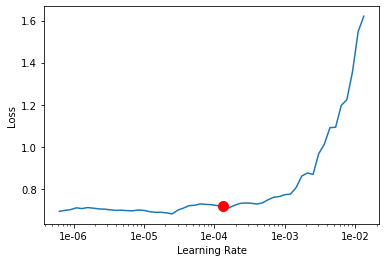

In [66]:
learner.recorder.plot(suggestion=True)

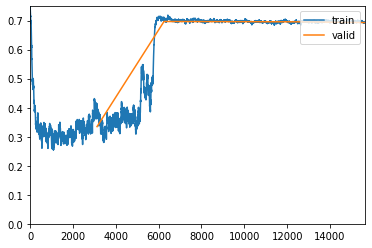

In [67]:
learner.fit_one_cycle(5, 1e-4, moms=(0.8,0.7))

In [51]:
learner.save('albert-no-pre-training-freezed')

In [40]:
# learner.load('no-pre-training-freezed');

## we only have 4 layer groups

In [52]:
len(learner.layer_groups)

4

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-04
Min loss divided by 10: 2.29E-07


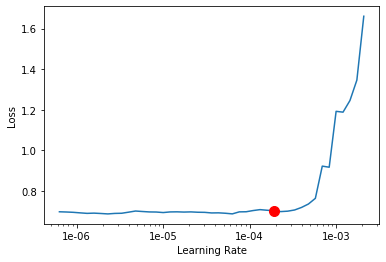

In [53]:
# since we have 14 layer_groups, we will unfreeze 2-3 layers to speed up the process
learner.freeze_to(-2)
torch.cuda.empty_cache()
learner.lr_find()
learner.recorder.plot(suggestion=True)

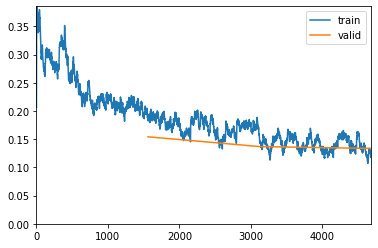

In [47]:
# ignore suggestion
learner.fit_one_cycle(3, 5e-5, moms=(0.8,0.7))

In [48]:
learner.save('no-pre-training-freez_to_-3')

In [ ]:
# learner.load('no-pre-training-freez_to_-3');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 3.31E-07


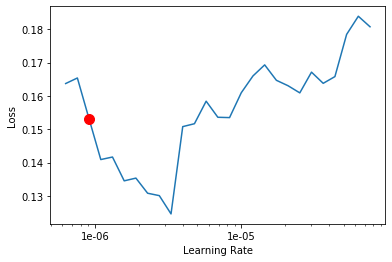

In [49]:
# since we have 14 layer_groups, we will unfreeze 2-3 layers to speed up the process
learner.freeze_to(-5)
torch.cuda.empty_cache()
learner.lr_find()
learner.recorder.plot(skip_end = 10, suggestion=True)

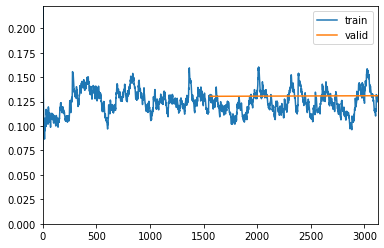

In [50]:
# ignore suggestion
learner.fit_one_cycle(2, 9.12E-07, moms=(0.8,0.7))

In [52]:
learner.save('no-pre-training-freez_to_-5')

In [38]:
learner.load('no-pre-training-freez_to_-5');

### We are able to get 95.3% accuracy without pre-finetuning

In the original guide of Jeremy Howard's ULMFiT for IMDB, he achieved **94.7%** accuracy. All the training strategies, like gradual unfreezing, learning rate annealing, batching are the same when constructing our `Learner`. Therefore, it's obvious that the `transformer` in stronger than `AWD_LSTM` for this task in terms of architecture.<br>

In the next notebook, we are going to push things further by incorporate the **ULMFiT** training procedure to the `transformer` training and see if we can get even better result.